In [3]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import aux.ts_functions as ts
import seaborn as sns; sns.set()
import numpy as np
import warnings
import os
import glob
from scipy.stats import pearsonr
from IPython.display import Image
import matplotlib
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from functions.automts.imputation_methods import impute_missing_values
from functools import reduce

from functions.automts.bayesian import hyperparameter_tuning_bayesian

data_dir = "./../data/"
dict_dir = "./imputation_dicts/"
rs=42

# Functions

In [4]:
def get_ts(df, area, specie, toxin, resample_code, plot=True, show_df=False):
    if not isinstance(toxin, list):
        toxin = [toxin]
    if specie != None:
        ts = df[ (df["Production_Area"]==area) & (df["Species"]==specie)]
    else:
        ts = df[ (df["Production_Area"]==area) ]
    ts = ts.resample(resample_code).mean()
    if plot:
        fig, ax = plt.subplots(1,1, figsize=(14,7))
        ts.plot(ax=ax, marker='o', markersize=2)
    if show_df: 
        display(ts[toxin].head())
    return ts[toxin]


In [5]:
def get_segments_for_imputation(ts_original, targets, n_segments, n_mult,  verbose=2, rs=42):
    if verbose>=2:
        fig, axes = plt.subplots(len(targets), 1, figsize=(12,6), constrained_layout=True, squeeze=False)
        axes = axes.ravel()
        for i in range(len(targets)):
            imp = ts_original[targets[i]].interpolate(method="linear")
            imp.plot(ax=axes[i], style='-r')
            ts_original[targets[i]].plot(ax=axes[i], style='-b')
        
    ######################################################################################

    dfs_complete = []
    dfs_missing = []
    ts = ts_original.copy()

    fracs_to_remove = {}
    for t in targets:
        fracs_to_remove[t] = round((ts[t].shape[0] - ts[t].dropna().shape[0]) / ts[t].shape[0],2)
        
    if verbose >=1:
        print("Fractions to remove: ",fracs_to_remove)
    
    whole_ts = False
    if n_segments == -1:
        n_segments = 1
        whole_ts = True
        
    for _ in range(n_segments):
        if not whole_ts:
            m = np.concatenate(( [True], np.isnan(a), [True] ))  # Mask
            ss = np.flatnonzero(m[1:] != m[:-1]).reshape(-1,2)   # Start-stop limits
            start,stop = ss[(ss[:,1] - ss[:,0]).argmax()]  # Get max interval, interval limits
            stop = stop-1
            print(f"lenght: {stop-start+1} || start: {ts.index[start]} || stop: {ts.index[stop]}")

            start = ts.index[start]
            stop = ts.index[stop]
        else:
            start = ts.index[0]
            stop = ts.index[-1]
        
        if verbose>=2:
            for i in range(len(targets)):
                axes[i].axvline(start, linestyle="--", color="g", linewidth=1)
                axes[i].axvline(stop, linestyle="--", color="g", linewidth=1)

        for n in range(n_mult):
            #add segment without NaNs
            dfs_complete.append(ts.loc[start:stop, :].copy())

            #create segments with artificial NaNs
            df = ts.loc[start:stop, :].copy()
            for t in targets:
                indexes = df[1:-1].dropna().sample(frac=fracs_to_remove[t], random_state=rs+n).index
                df.loc[indexes, t] = np.nan
            dfs_missing.append(df)

        ts.loc[start:stop] = np.nan
    plt.show()
    
    return dfs_complete, dfs_missing

# Loading

In [33]:
biotoxins_ts = pd.read_excel(data_dir + 'biotoxins_preprocessed.xlsx', index_col='Date', parse_dates=True,
                             engine="openpyxl")
biotoxins_ts

,Sample,Species,Sample_Point,Production_Area,dsp_toxins,asp_toxins,psp_toxins
Date,,,,,,,
2015-01-05,1,Mexilhão,Jangada,LAL,20.0,1.8,71.0
2015-01-05,20,Berbigão,Canal do Espinheiro,RIAV3,36.0,1.8,71.0
2015-01-05,19,Berbigão,Costa Nova,RIAV2,26.0,1.8,71.0
2015-01-05,18,Berbigão,Moacha,RIAV1,36.0,1.8,71.0
2015-01-05,17,Amêijoa-branca,Torreira,L3,36.0,1.8,71.0
...,...,...,...,...,...,...,...
2020-12-29,2211,Mexilhão,Povoação,POR2,36.0,1.8,NaN
2020-12-29,2212,Mexilhão,Aljezur,L7a,36.0,NaN,NaN
2020-12-29,2213,Mexilhão,Garganta,OLH4,36.0,NaN,NaN


In [34]:
phyto_ts = pd.read_excel(data_dir + 'phytoplankton_preprocessed.xlsx', index_col='Date', parse_dates=True,
                             engine="openpyxl")
phyto_ts

,Sample,Production_Area,asp_phyto,dsp_phyto,psp_phyto
Date,,,,,
2014-10-31,1809.0,L6,20.0,20.0,20.0
2014-11-03,1785.0,LAL,20.0,20.0,20.0
2014-11-03,1820.0,RIAV4,20.0,20.0,20.0
2014-11-03,1821.0,L3,20.0,20.0,200.0
2014-11-03,1823.0,RIAV2,20.0,20.0,20.0
...,...,...,...,...,...
2020-12-29,1612.0,L1,20.0,20.0,20.0
2020-12-29,1614.0,POR2,440.0,40.0,20.0
2020-12-29,1615.0,LAG,4760.0,20.0,20.0


# Analysis of NaN relation between species

,dsp_toxins_x,dsp_toxins_y
Date,,
2015-01-11,36.0,52.0
2015-01-18,40.0,41.0
2015-01-25,36.0,42.0
2015-02-01,36.0,35.0
2015-02-08,36.0,42.5
...,...,...
2020-12-06,67.0,NaN
2020-12-13,36.0,NaN
2020-12-20,36.0,243.0


All NaN:  11
Any NaN:  43


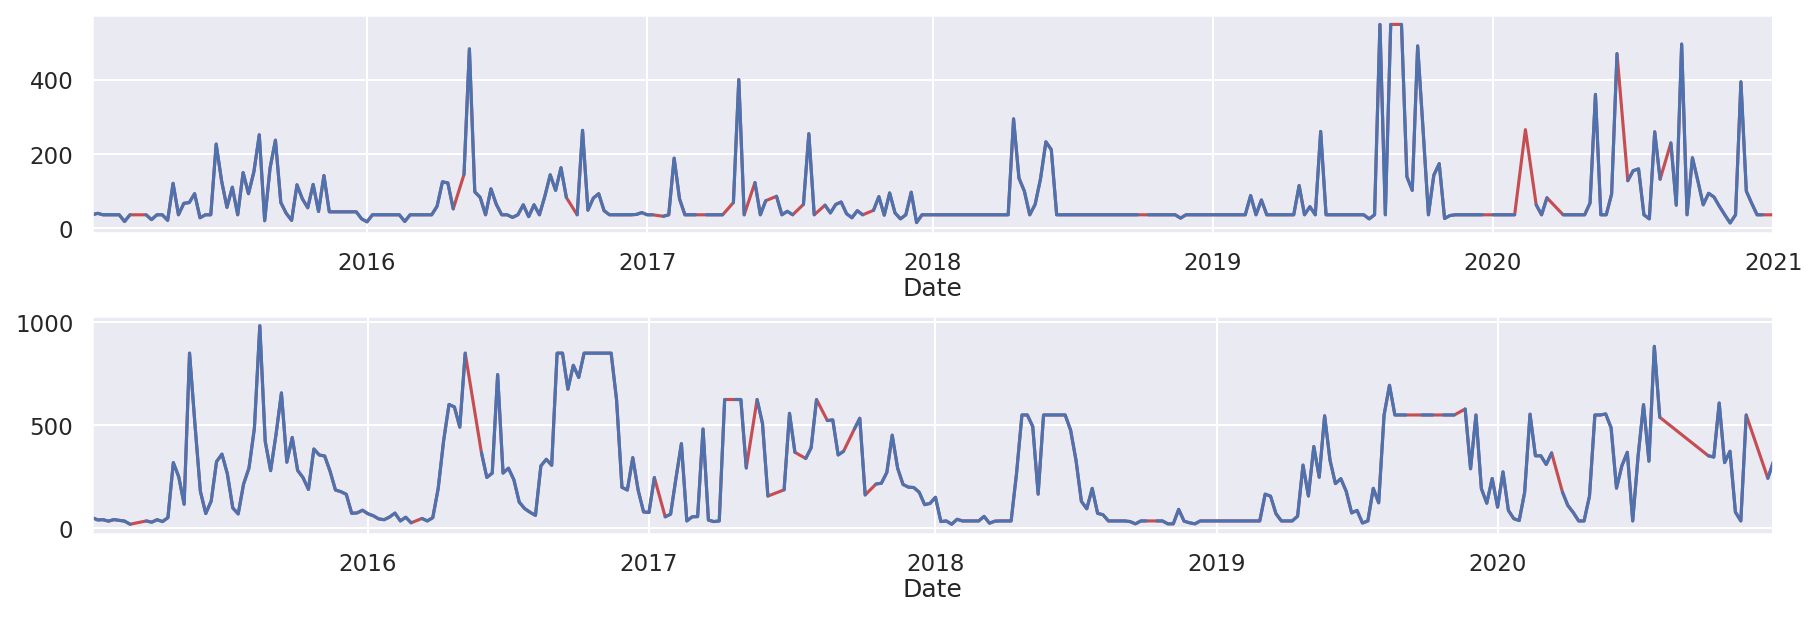

In [13]:
targets = ["dsp_toxins", "asp_toxins", "psp_toxins"]
target = "dsp_toxins"
#print(biotoxins_ts[ biotoxins_ts["Production_Area"]=="RIAV1" ]["Species"].value_counts())

ts_b = get_ts(biotoxins_ts, "RIAV1", "Berbigão", targets, "W", plot=False)
ts_m = get_ts(biotoxins_ts, "RIAV1", "Mexilhão", targets, "W", plot=False)

fig, ax = plt.subplots(2,1, figsize=(12,4), constrained_layout=True)

imp = ts_b[target].interpolate(method="linear")
imp.plot(ax=ax[0], style='-r')
ts_b[target].plot(ax=ax[0], style='-b')

imp = ts_m[target].interpolate(method="linear")
imp.plot(ax=ax[1], style='-r')
ts_m[target].plot(ax=ax[1], style='-b')

df = pd.merge(ts_b[[target]], ts_m[[target]], left_index=True, right_index=True, how="outer")
display(df)
print("All NaN: ",df.isna().all(1).sum())
print("Any NaN: ",df.isna().any(1).sum())

# Imputation

## Area

In [14]:
all_areas = biotoxins_ts["Production_Area"].unique()
all_areas

array(['LAL', 'RIAV3', 'RIAV2', 'RIAV1', 'L3', 'RIAV4', 'L2', 'L9',
       'FAR2', 'L8', 'FAR1', 'OLH2', 'VT', 'POR2', 'LAG', 'OLH3', 'OLH4',
       'L7a', 'L1', 'FUZ', 'OLH5', 'EMN2', 'LOB', 'L7c2', 'L7c1', 'L5a',
       'ESD2', 'L6', 'ESD1', 'OLH1', 'L5b', 'TAV', 'ETJ1', 'EMR', 'EMI',
       'ELM', 'L7c', 'EMN1', 'L5', 'L4', 'POR3', 'L7b', 'GUA', 'ETJ2'],
      dtype=object)

In [17]:
specie = "Mexilhão"
min_per_specie = 200
min_per_second_specie = 0.5
species_to_impute = {}

for area in all_areas:
    vc = biotoxins_ts[ biotoxins_ts["Production_Area"] == area]["Species"].value_counts()
    if specie in vc.keys() and vc[specie] > min_per_specie:
        species_list = []
        count = vc[specie]
        for k in vc.keys():
            if vc[k] > count * min_per_second_specie:
                species_list.append(k)
        species_to_impute[area] = species_list

print(species_to_impute.keys())
species_to_impute

dict_keys(['LAL', 'RIAV2', 'RIAV1', 'L2', 'FAR1', 'OLH2', 'POR2', 'LAG', 'OLH3', 'OLH4', 'L1', 'LOB', 'L7c2', 'L7c1', 'L5b', 'TAV', 'ETJ1'])


{'LAL': ['Mexilhão'],
 'RIAV2': ['Berbigão', 'Mexilhão'],
 'RIAV1': ['Berbigão', 'Mexilhão'],
 'L2': ['Mexilhão', 'Amêijoa-branca'],
 'FAR1': ['Mexilhão'],
 'OLH2': ['Mexilhão'],
 'POR2': ['Mexilhão'],
 'LAG': ['Mexilhão'],
 'OLH3': ['Mexilhão'],
 'OLH4': ['Mexilhão'],
 'L1': ['Mexilhão'],
 'LOB': ['Berbigão', 'Mexilhão'],
 'L7c2': ['Mexilhão'],
 'L7c1': ['Mexilhão'],
 'L5b': ['Mexilhão'],
 'TAV': ['Mexilhão'],
 'ETJ1': ['Mexilhão']}

['psp_toxins_Mexilhão']
Fractions to remove:  {'psp_toxins_Mexilhão': 0.13}


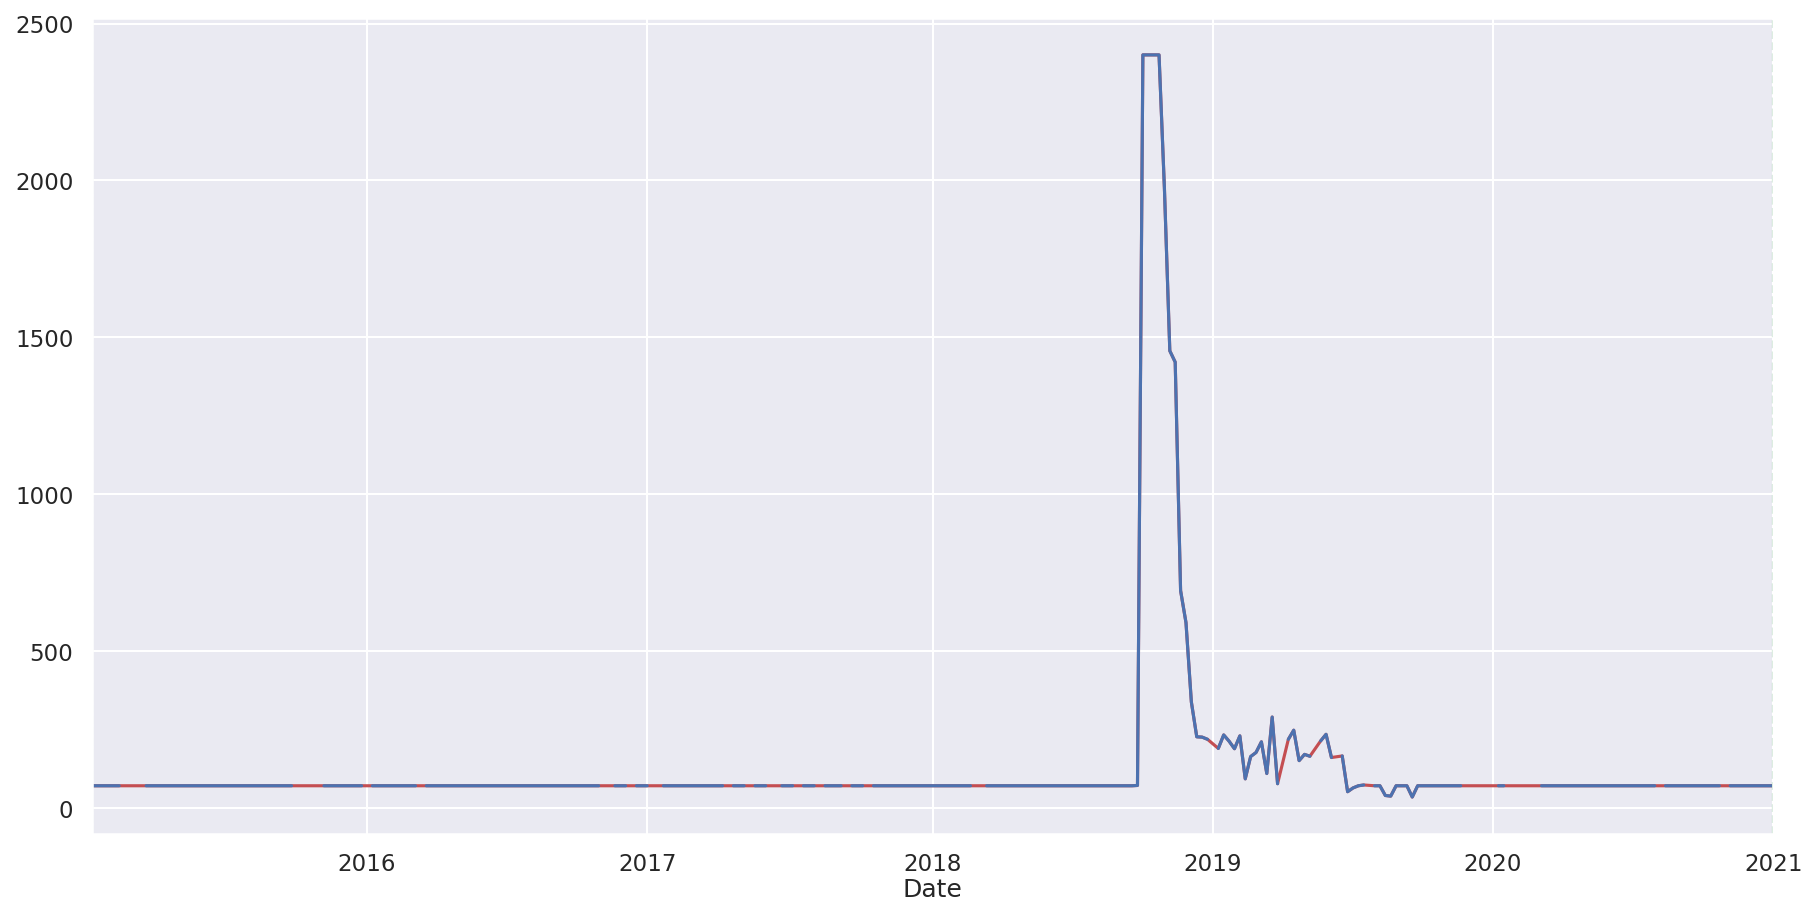

Fractions to remove:  {'psp_toxins_Mexilhão': 0.23}


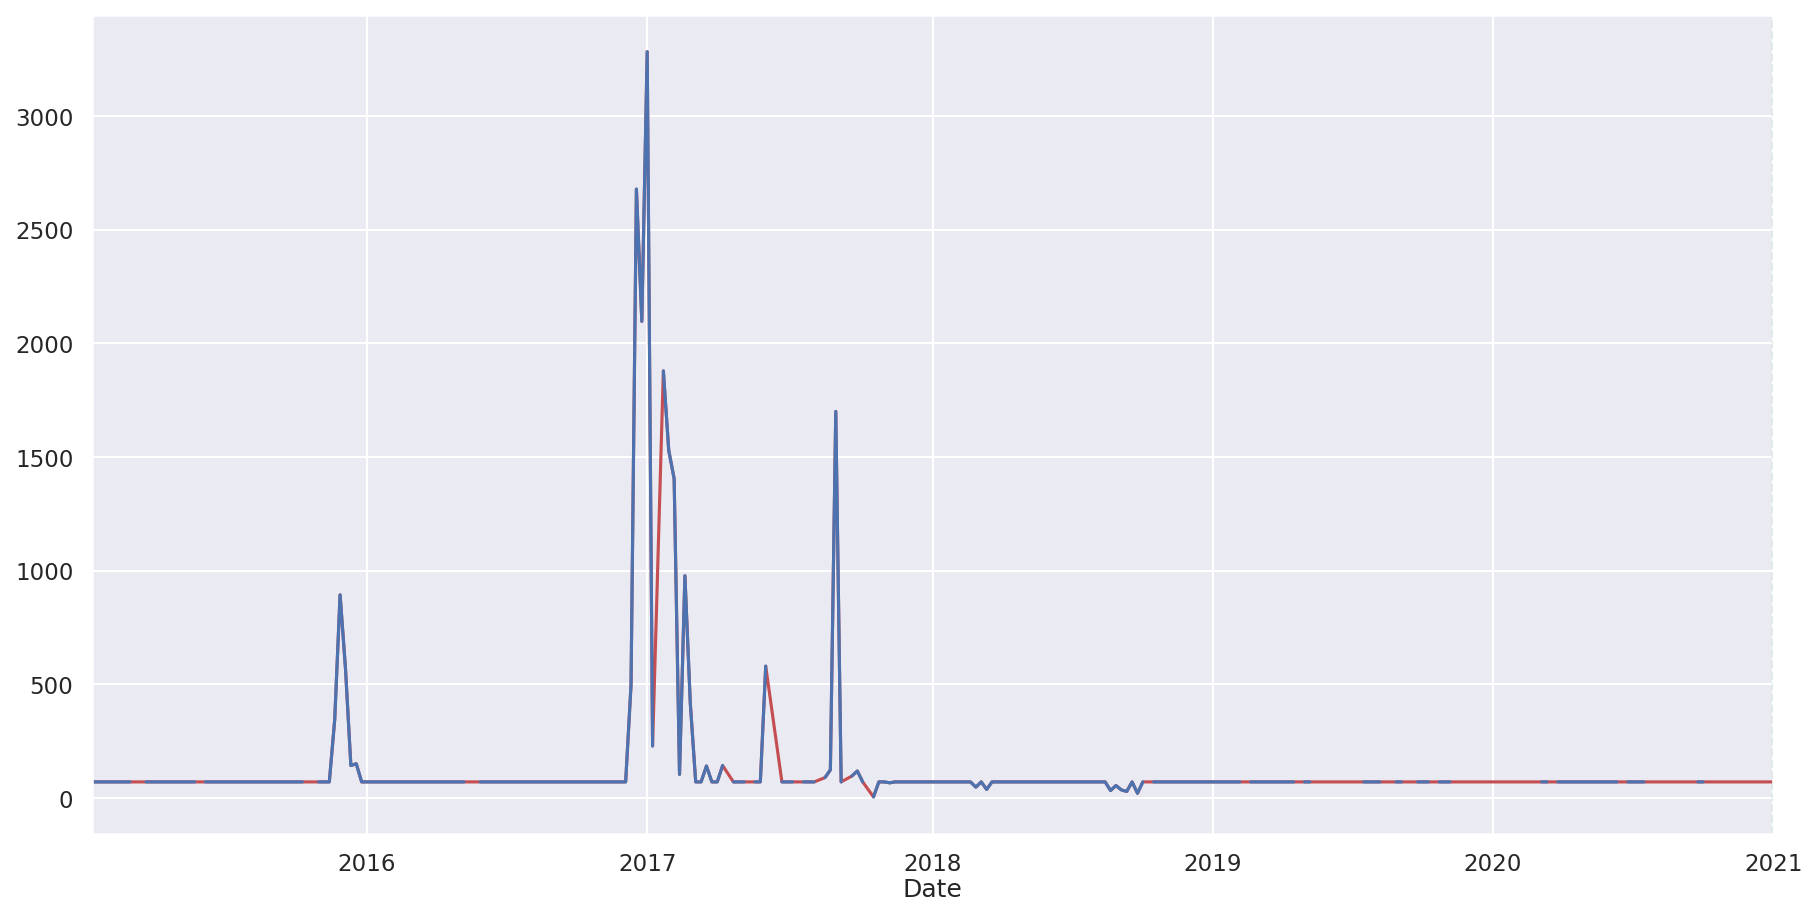

Fractions to remove:  {'psp_toxins_Mexilhão': 0.15}


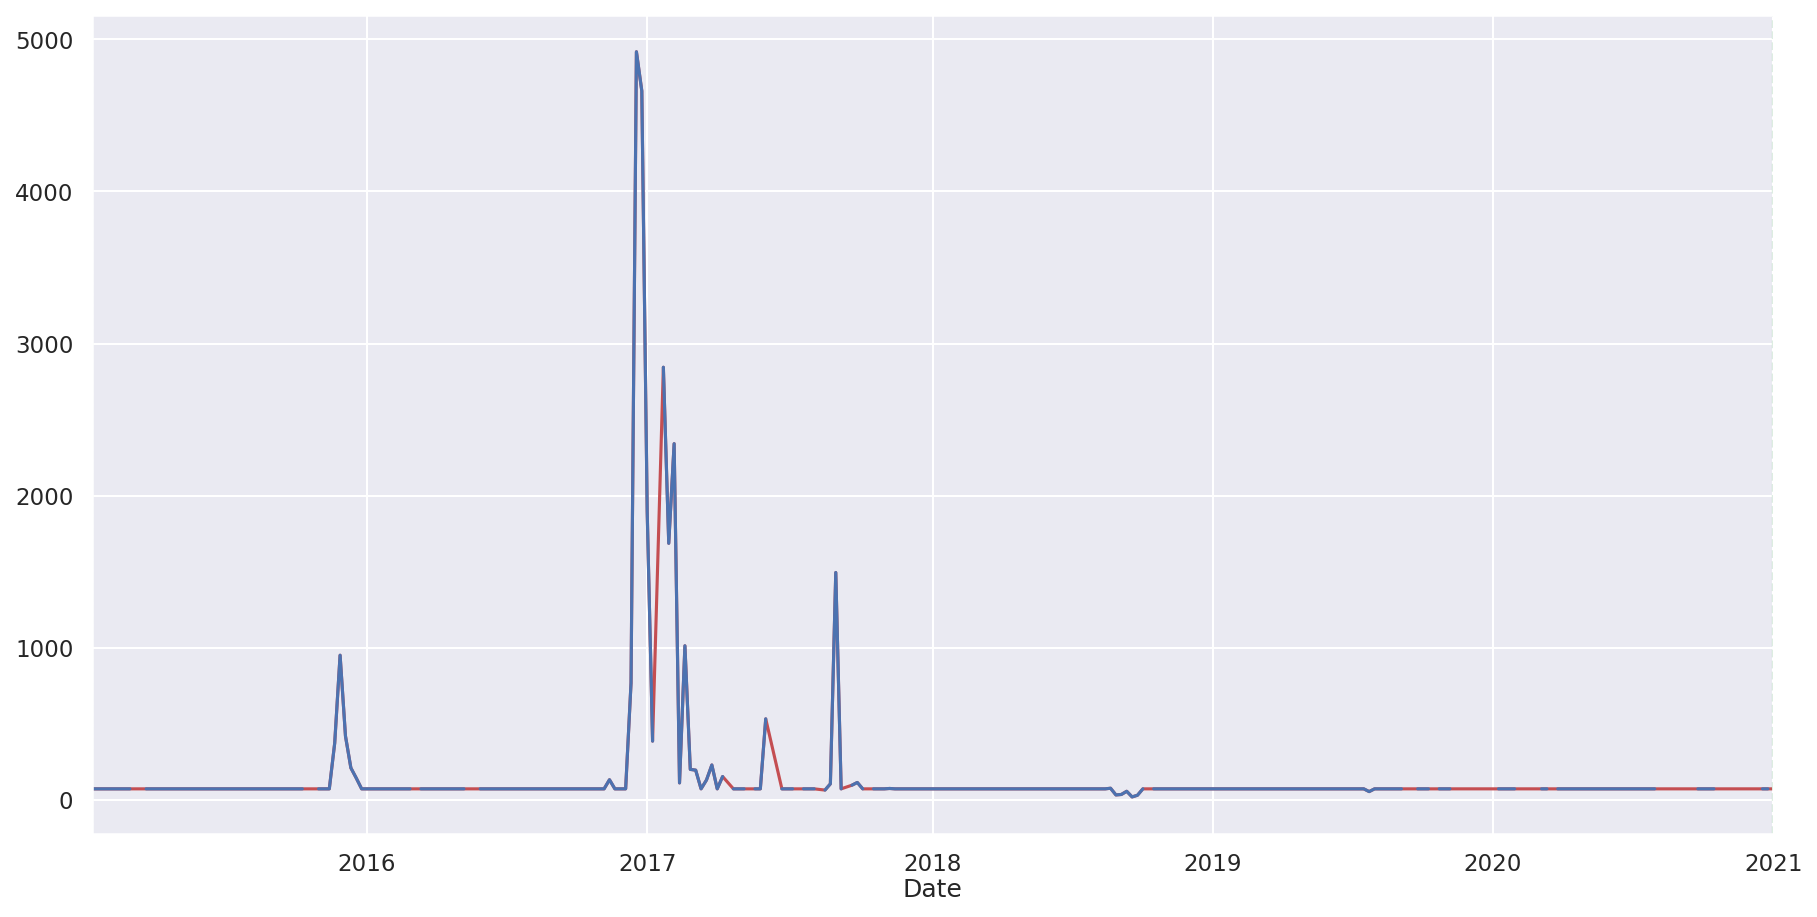

Fractions to remove:  {'psp_toxins_Mexilhão': 0.26}


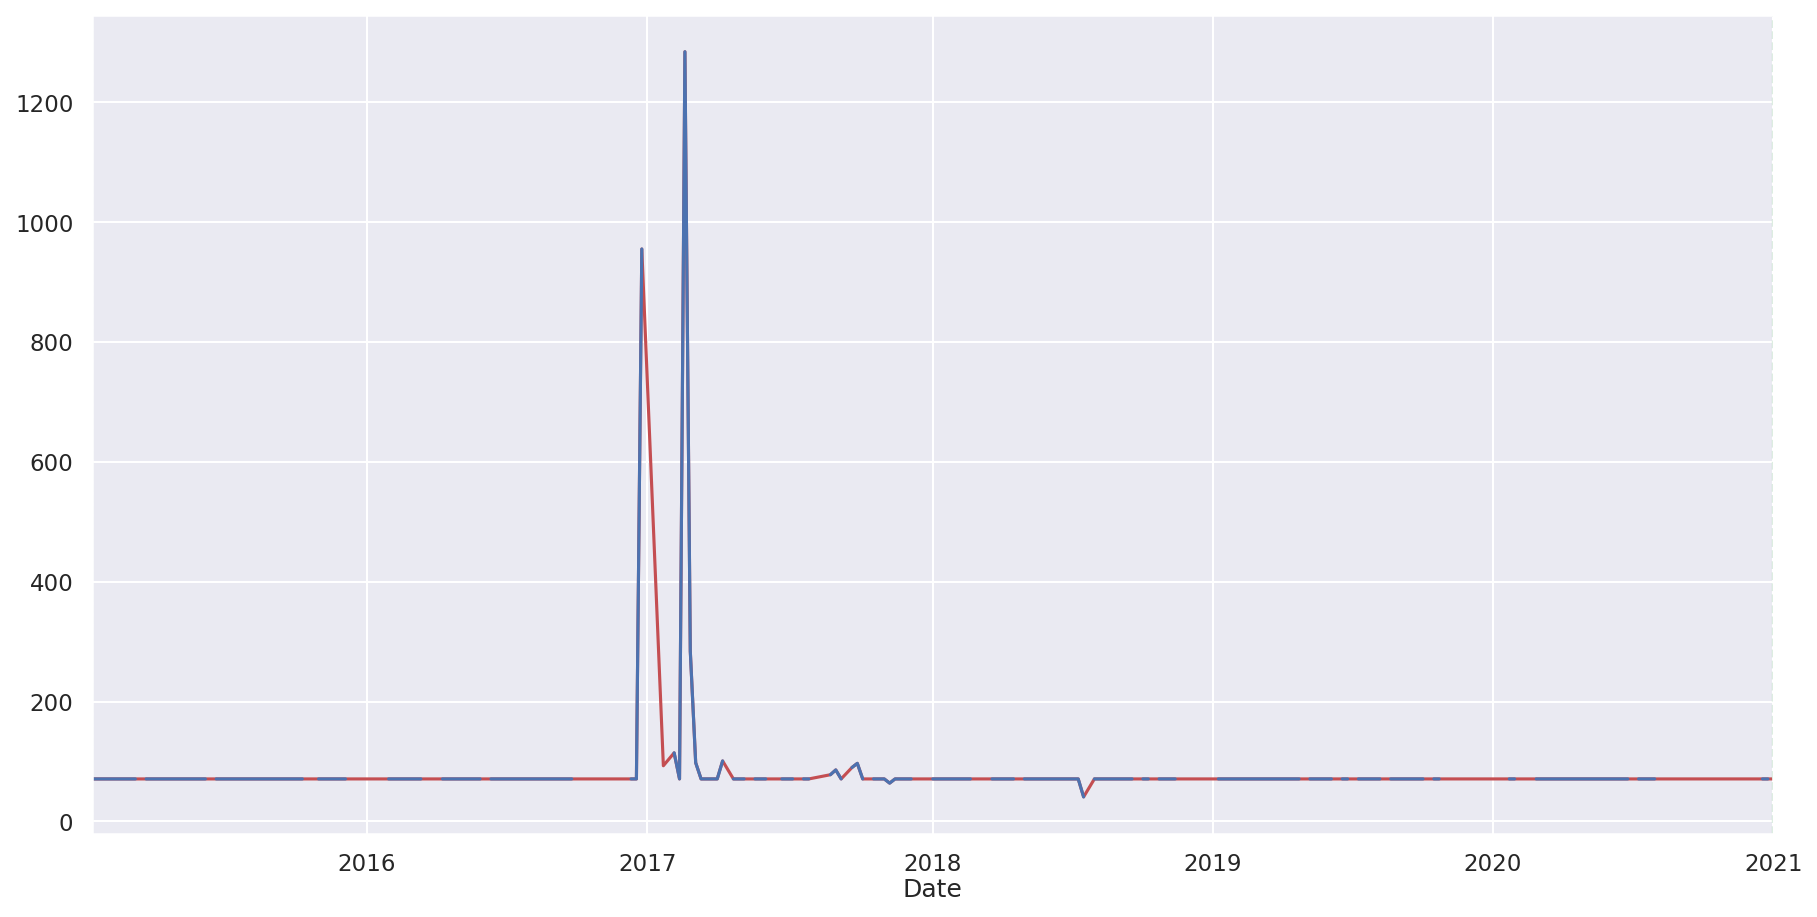

Fractions to remove:  {'psp_toxins_Mexilhão': 0.32}


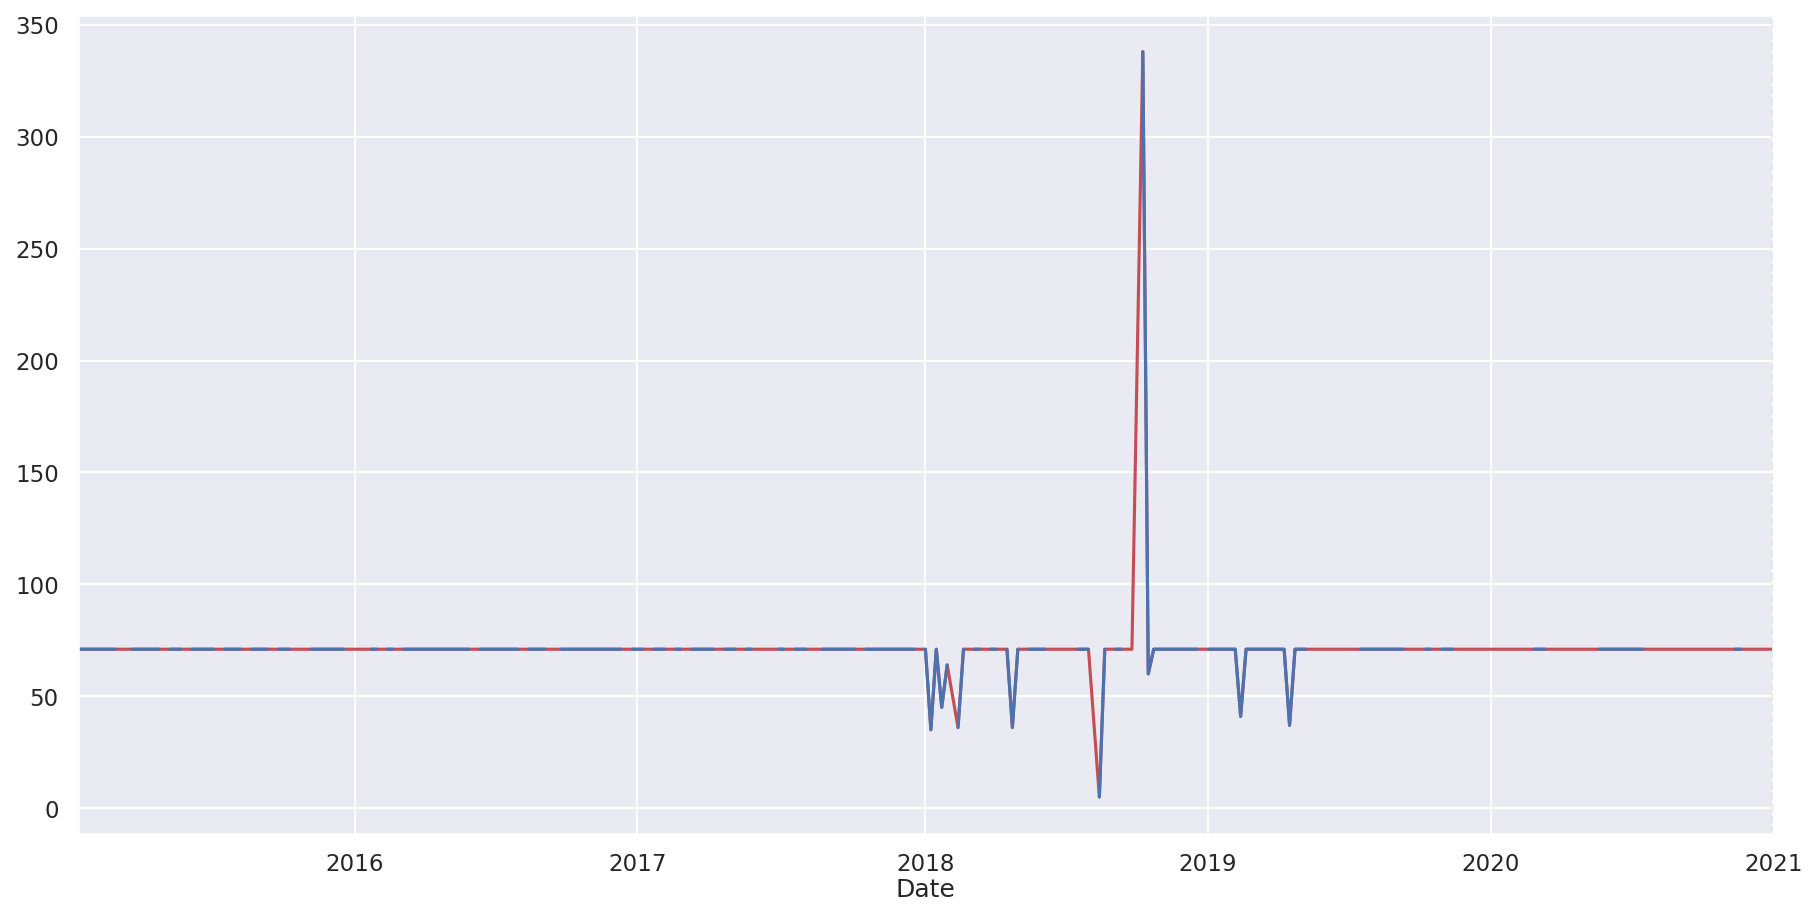

Fractions to remove:  {'psp_toxins_Mexilhão': 0.25}


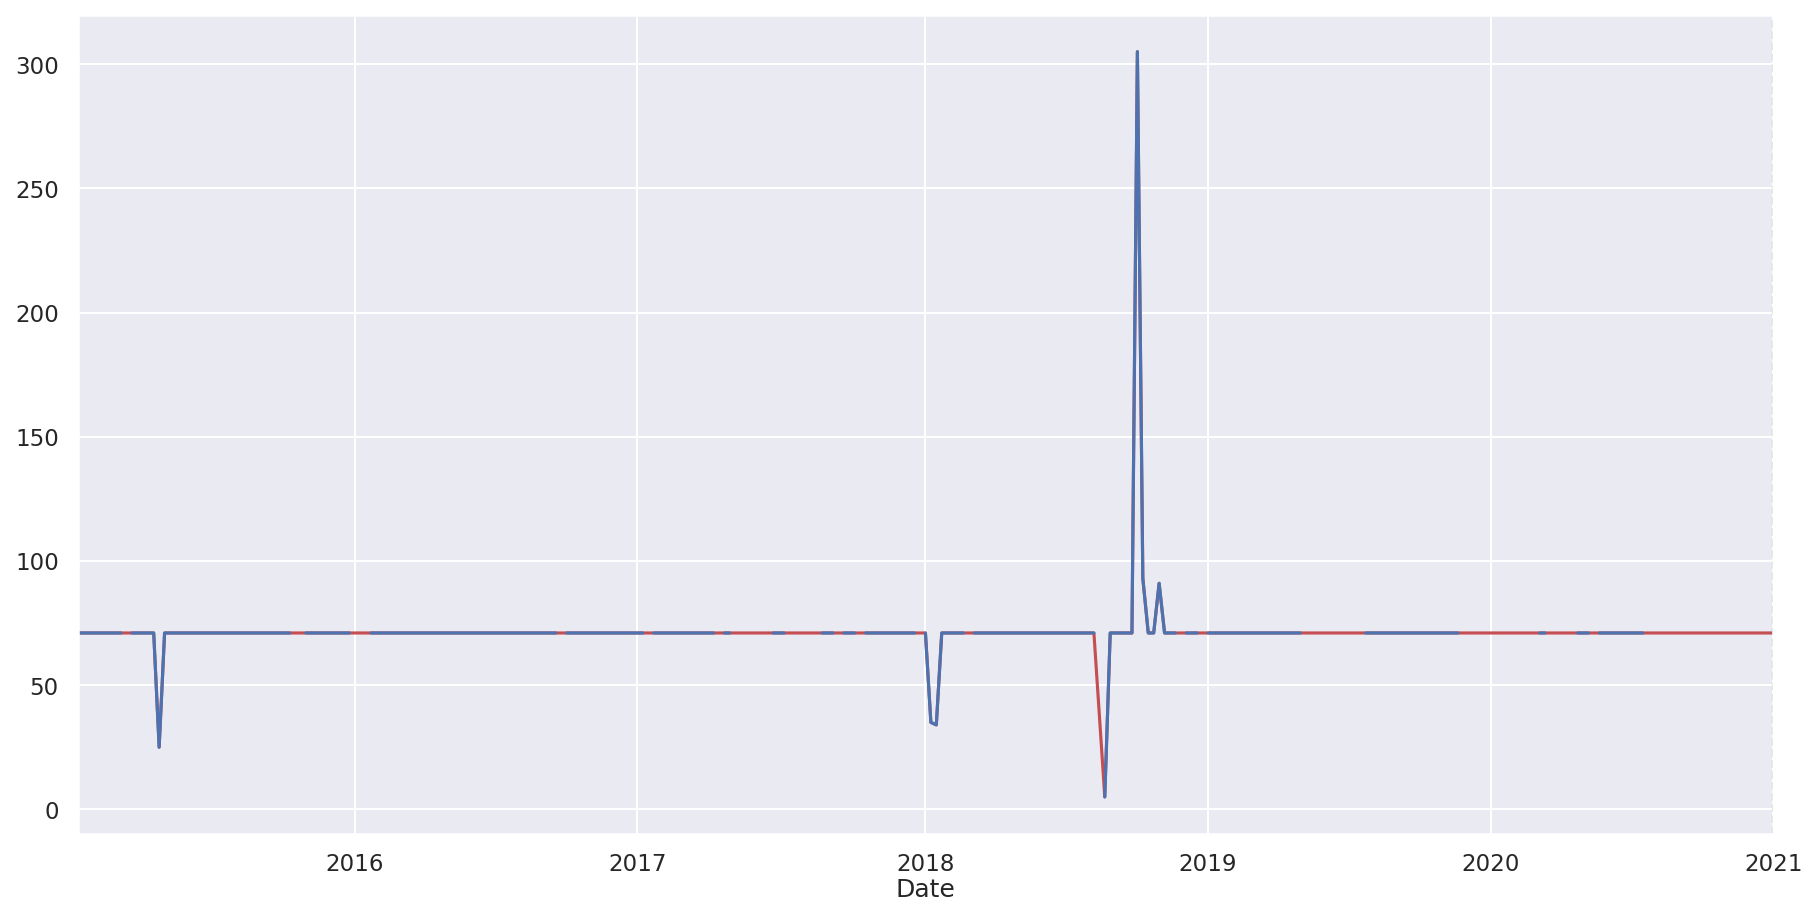

Fractions to remove:  {'psp_toxins_Mexilhão': 0.36}


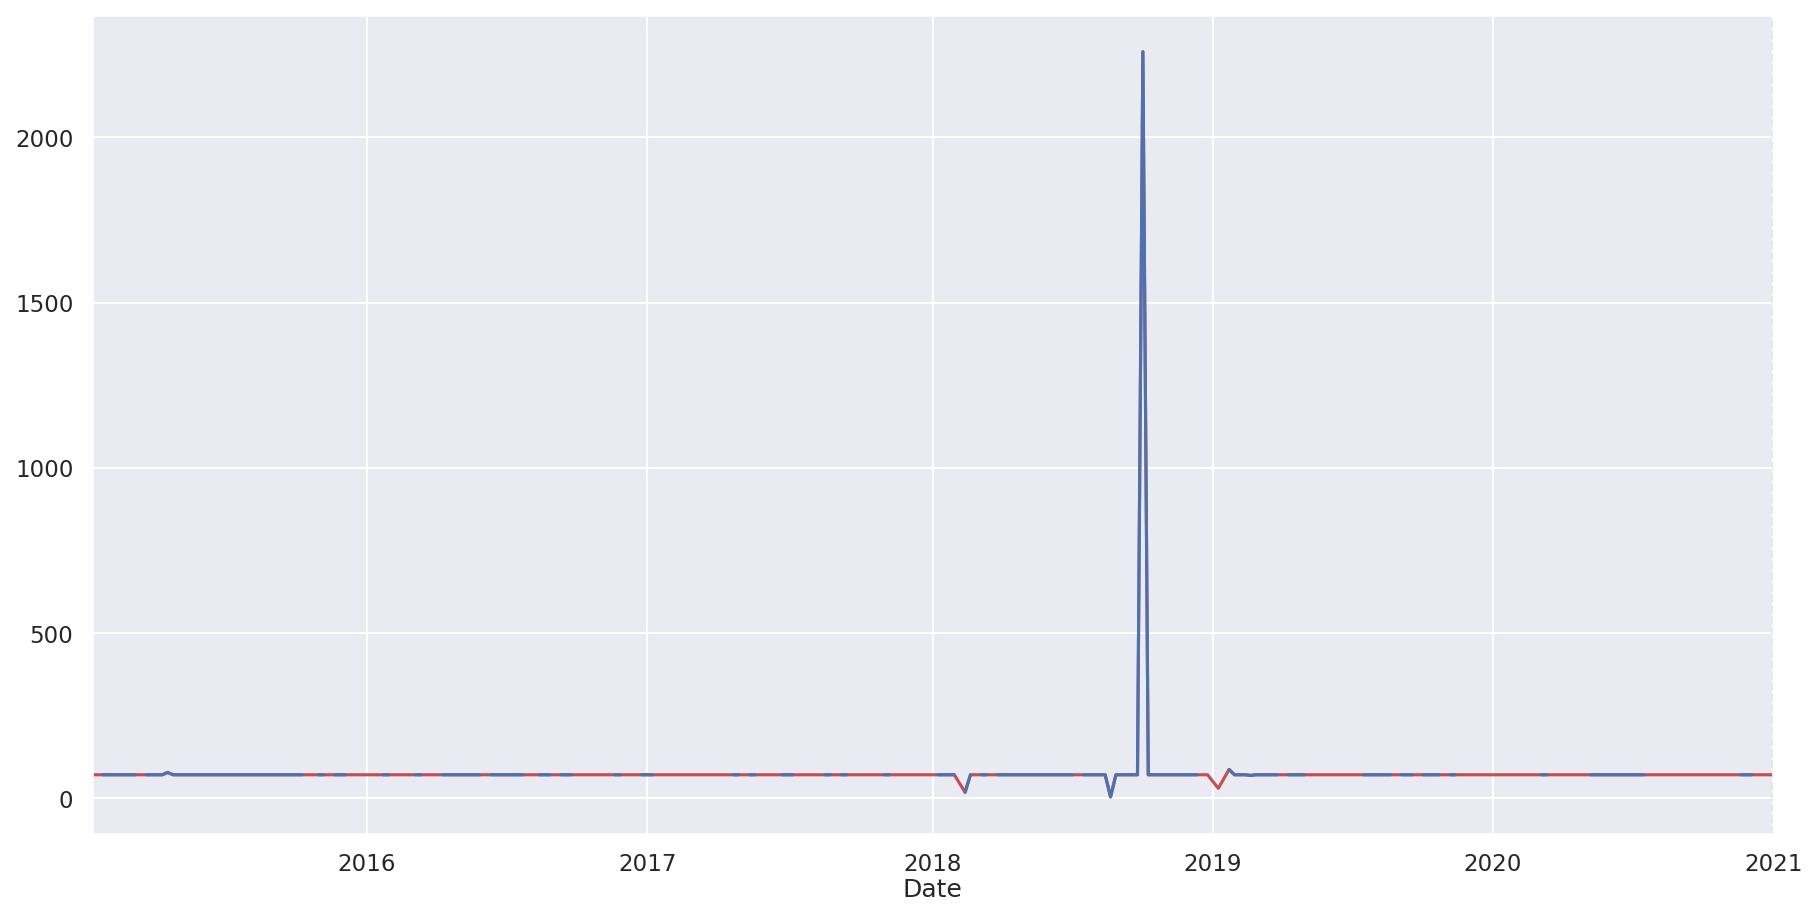

Fractions to remove:  {'psp_toxins_Mexilhão': 0.23}


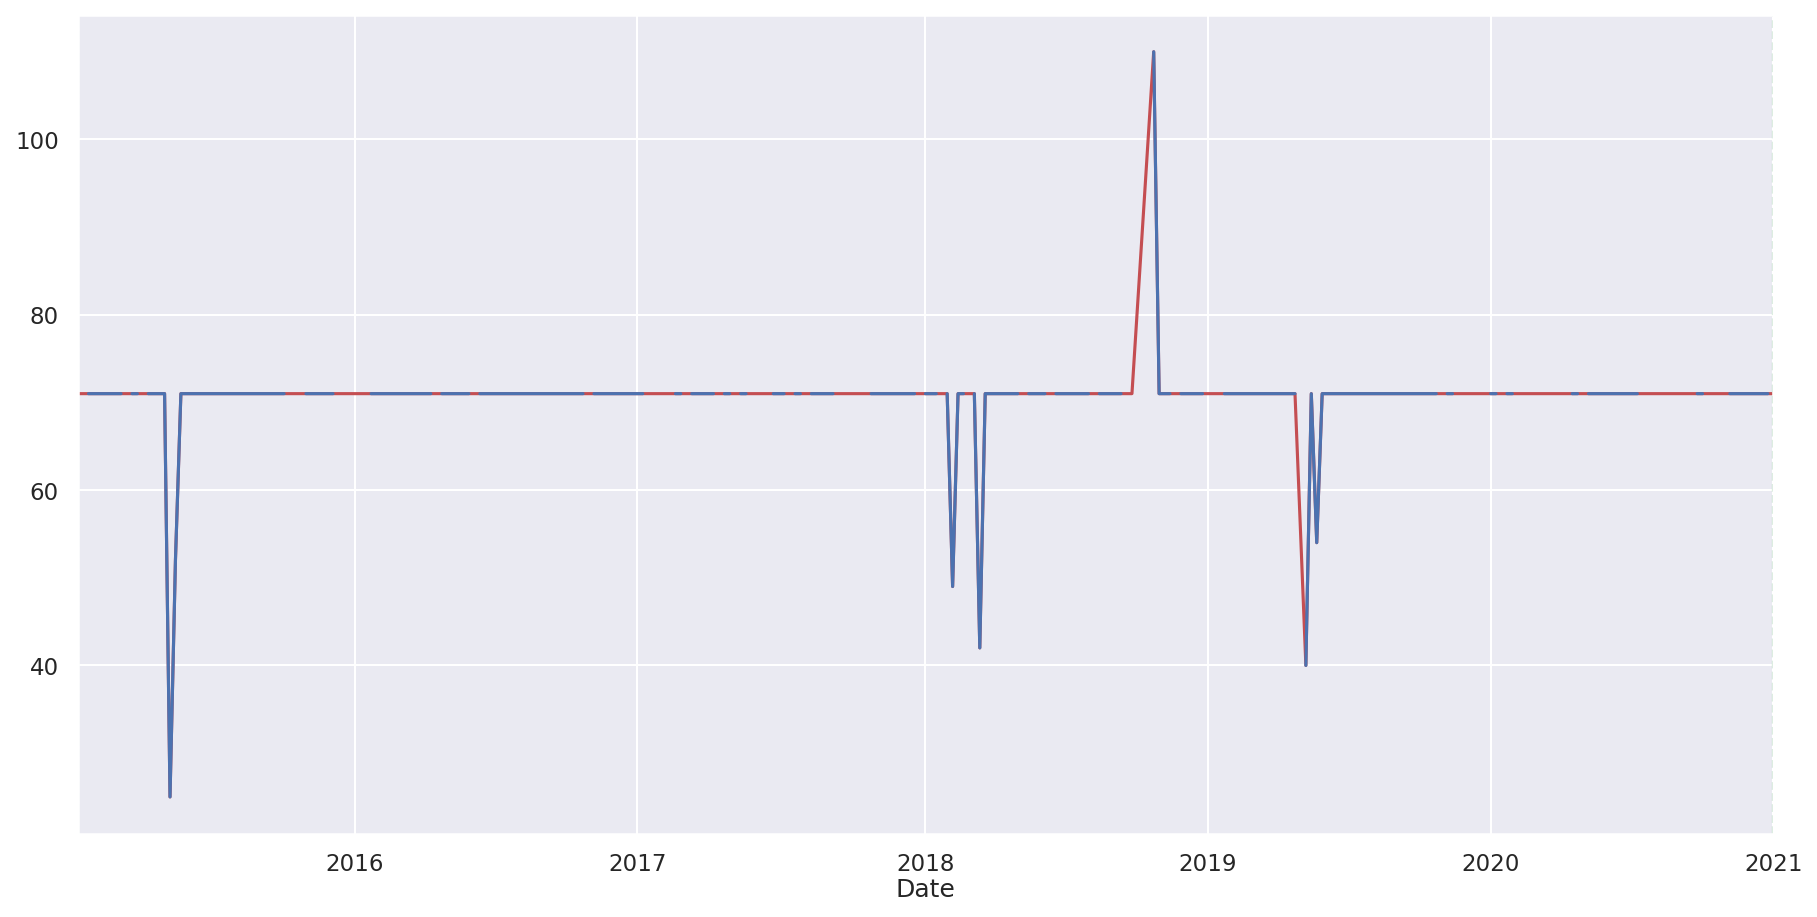

Fractions to remove:  {'psp_toxins_Mexilhão': 0.13}


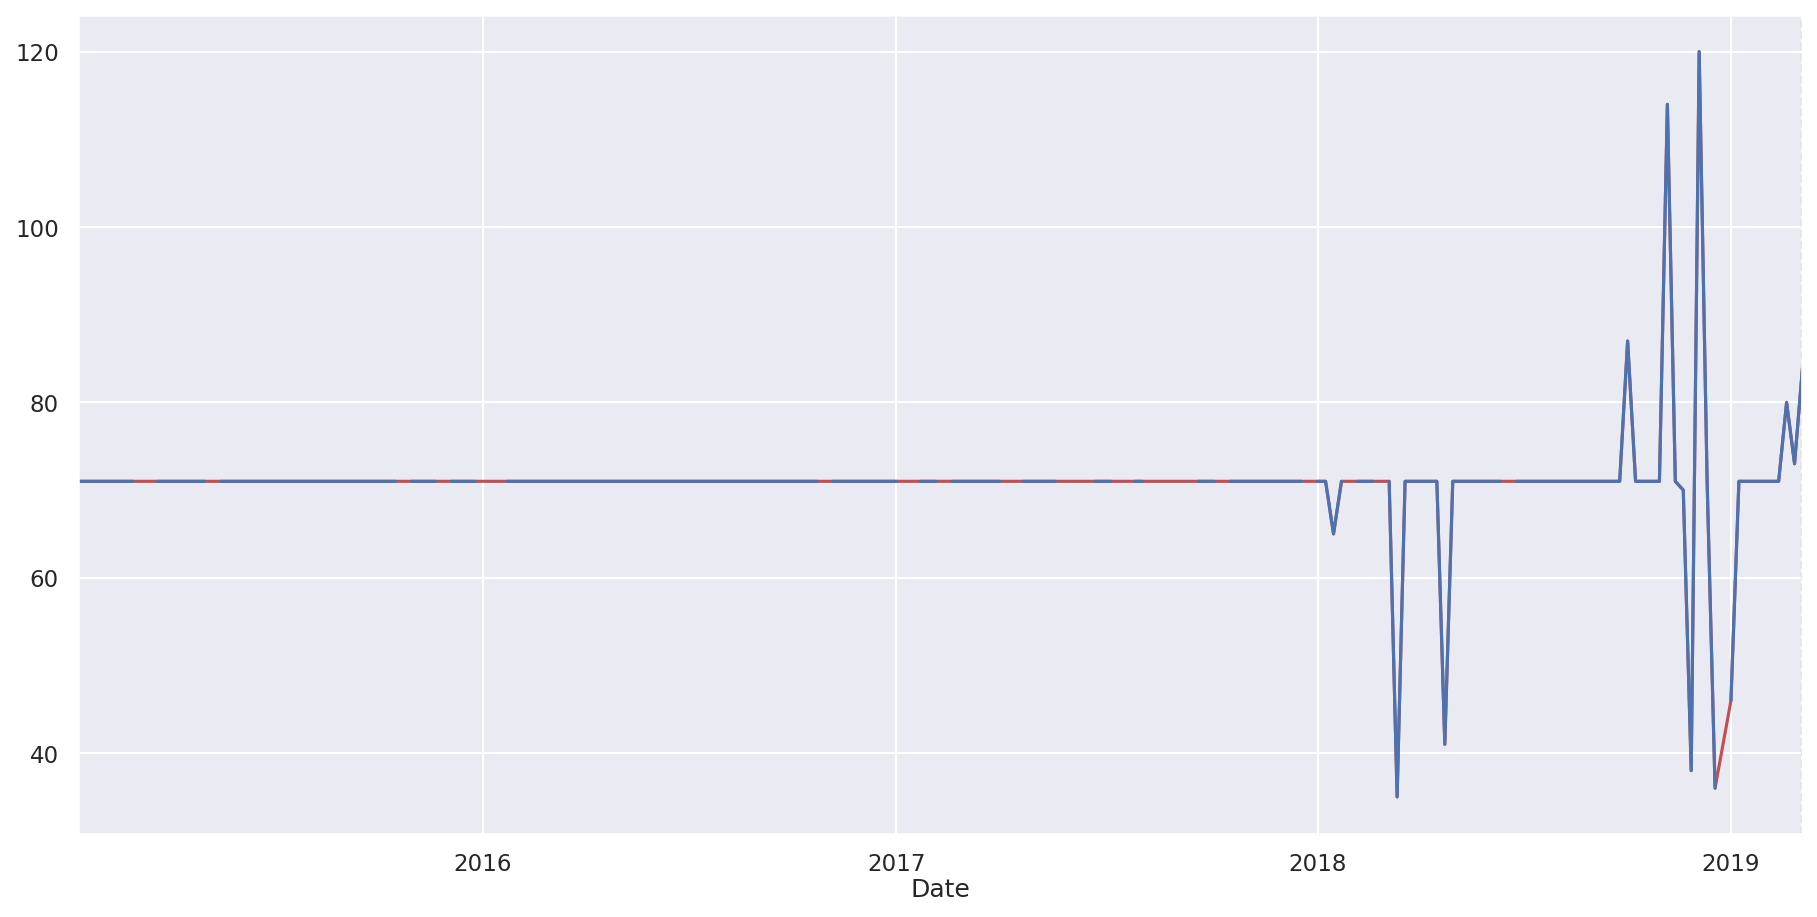

Fractions to remove:  {'psp_toxins_Mexilhão': 0.26}


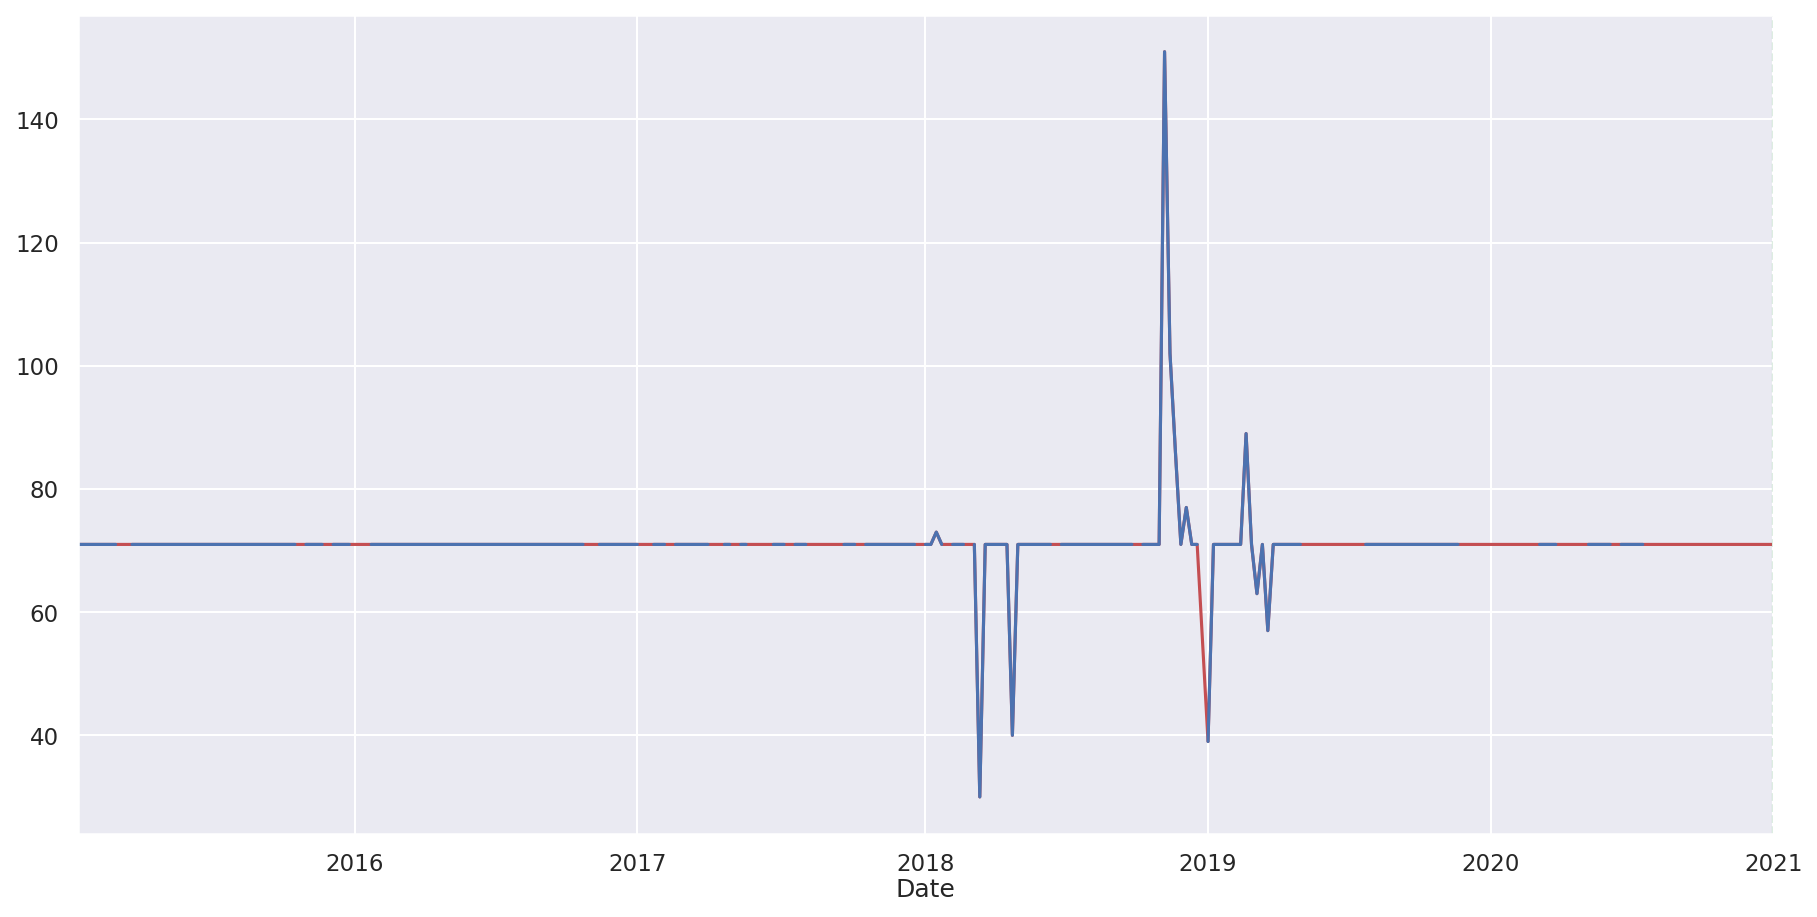

Fractions to remove:  {'psp_toxins_Mexilhão': 0.35}


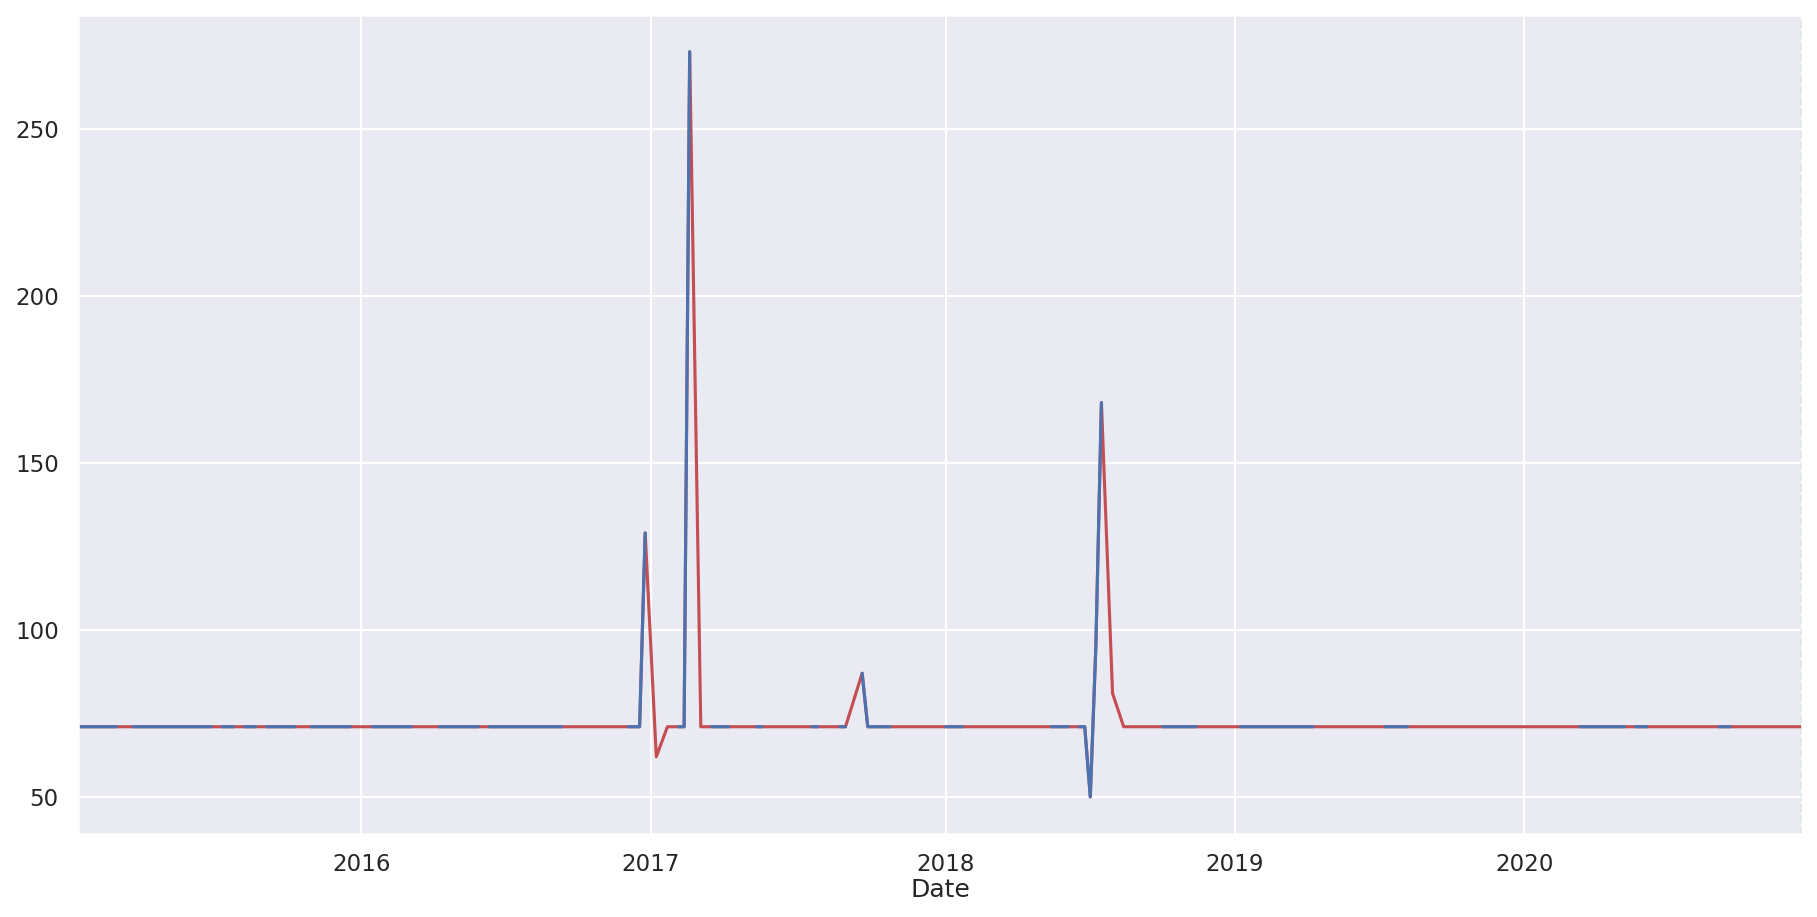

Fractions to remove:  {'psp_toxins_Mexilhão': 0.2}


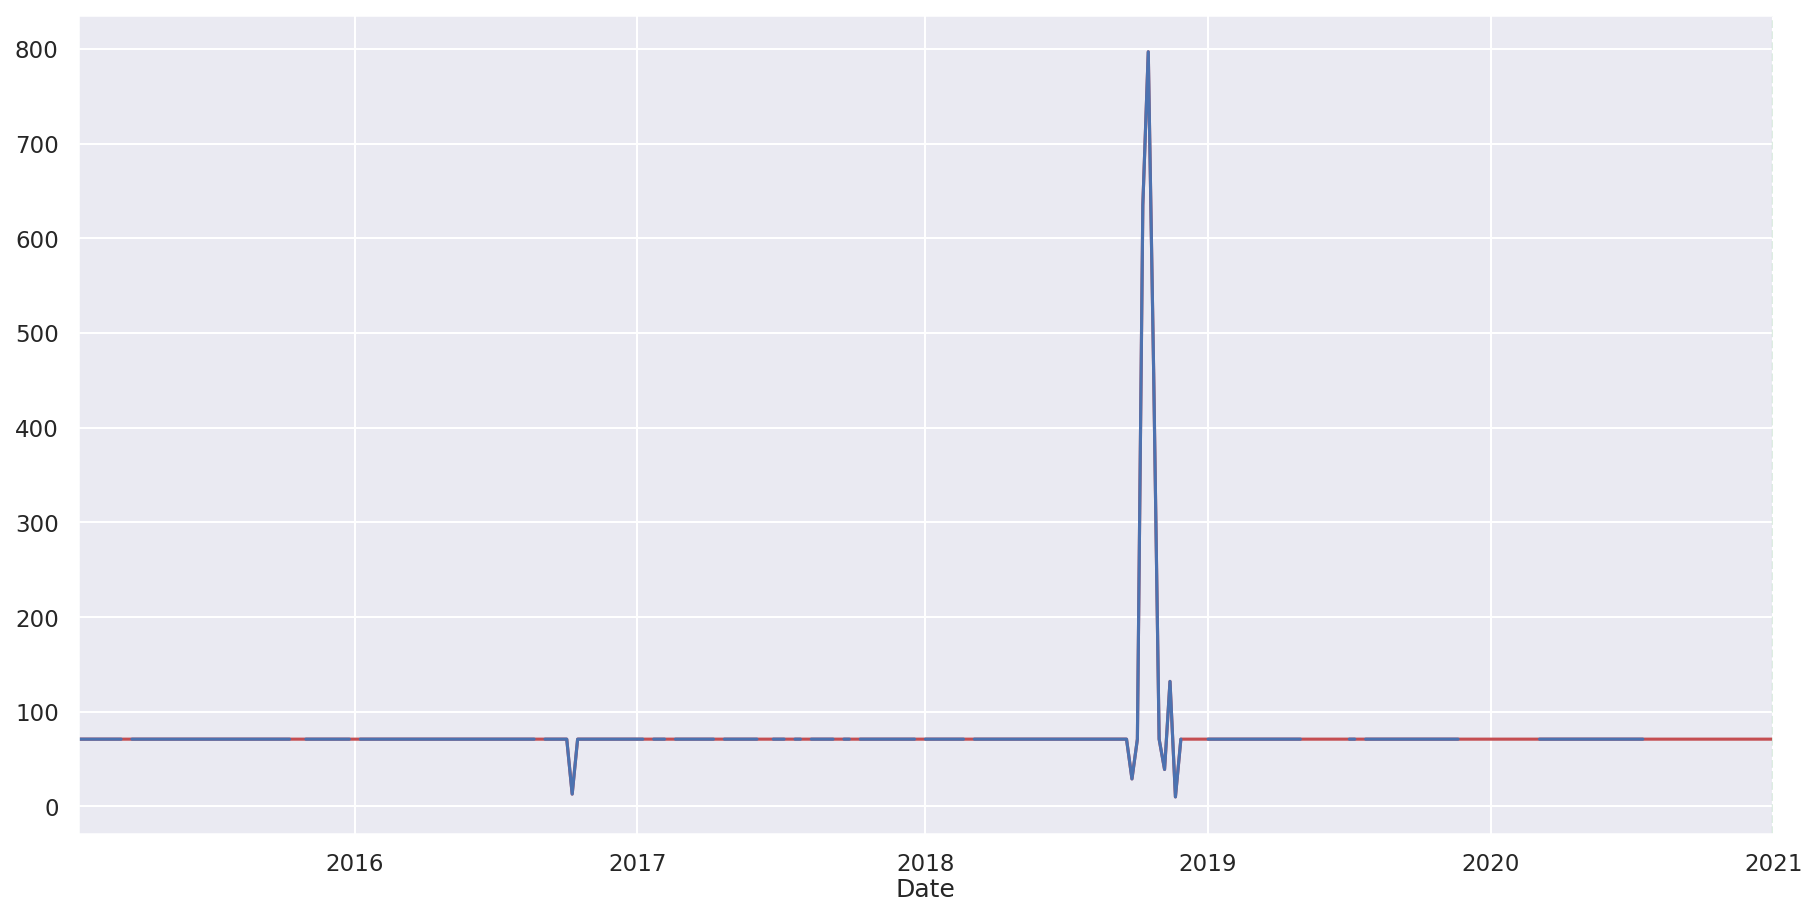

Fractions to remove:  {'psp_toxins_Mexilhão': 0.26}


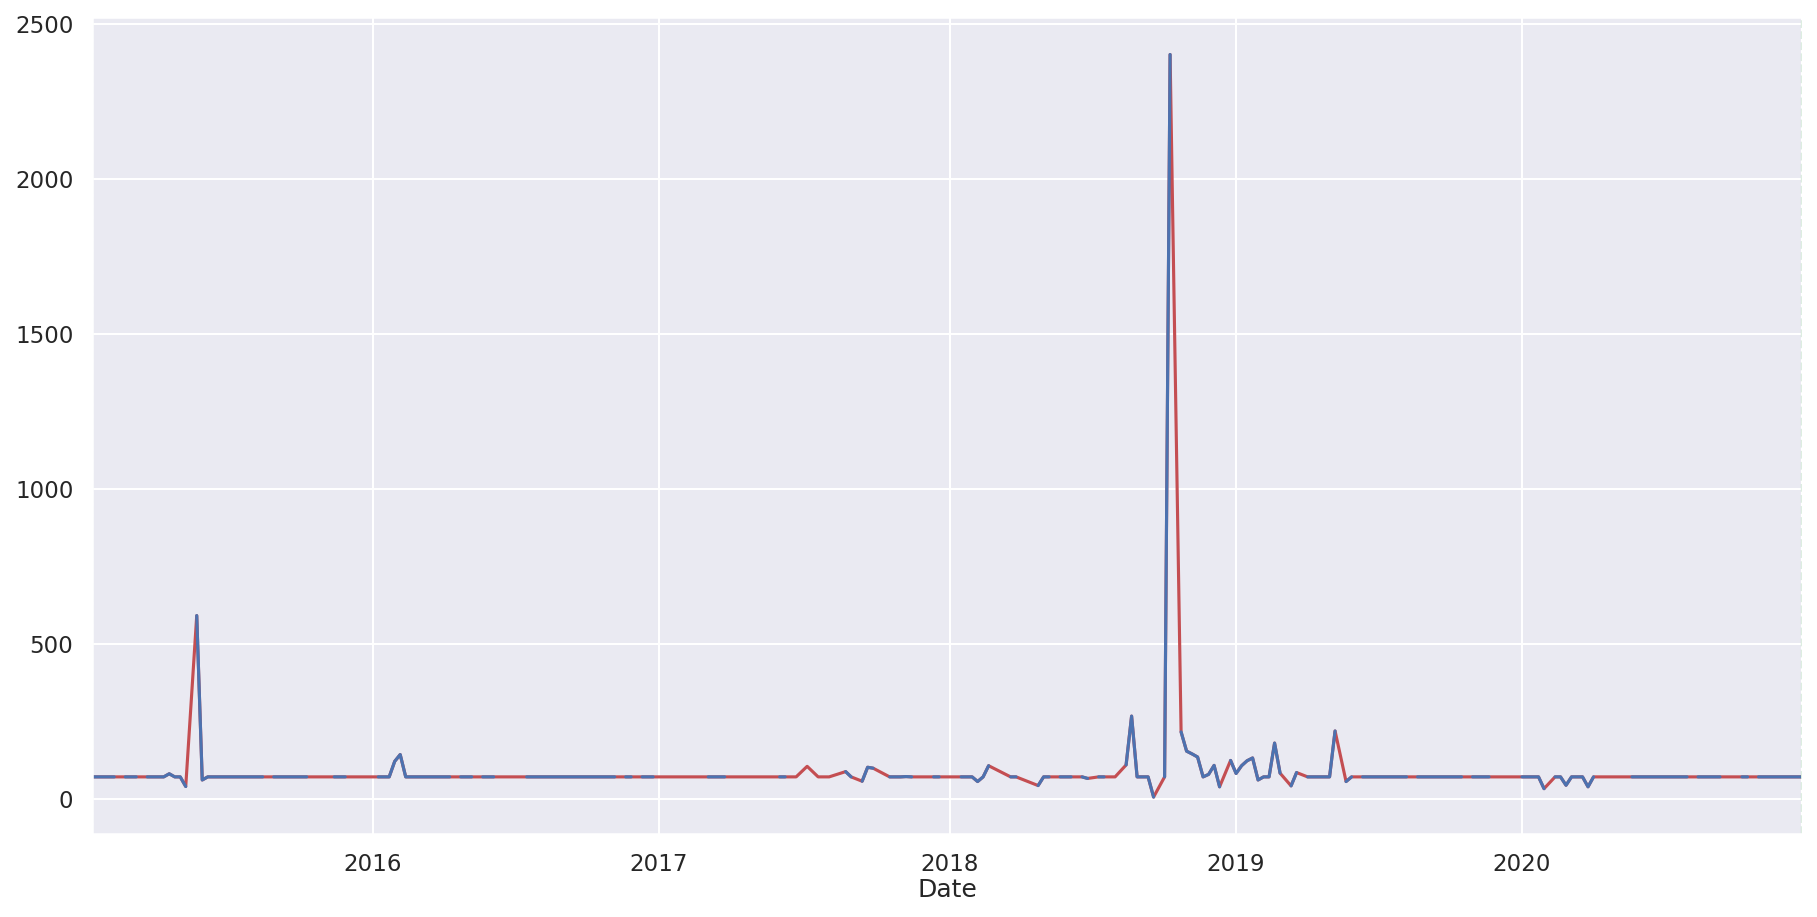

Fractions to remove:  {'psp_toxins_Mexilhão': 0.19}


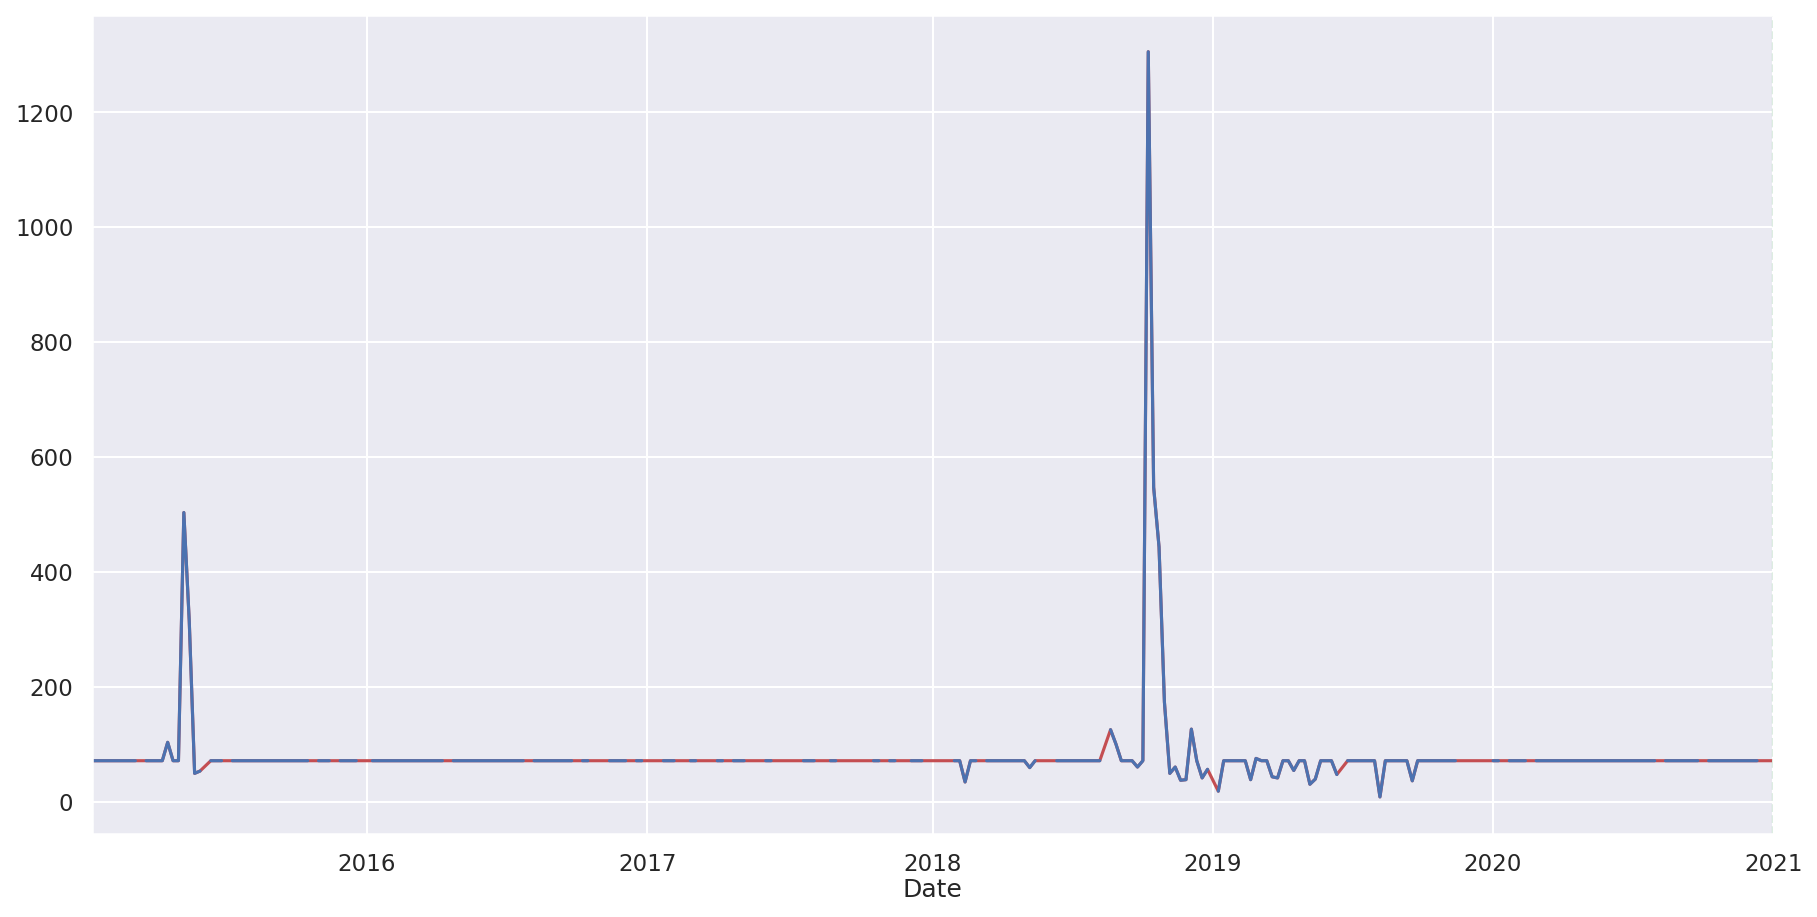

Fractions to remove:  {'psp_toxins_Mexilhão': 0.18}


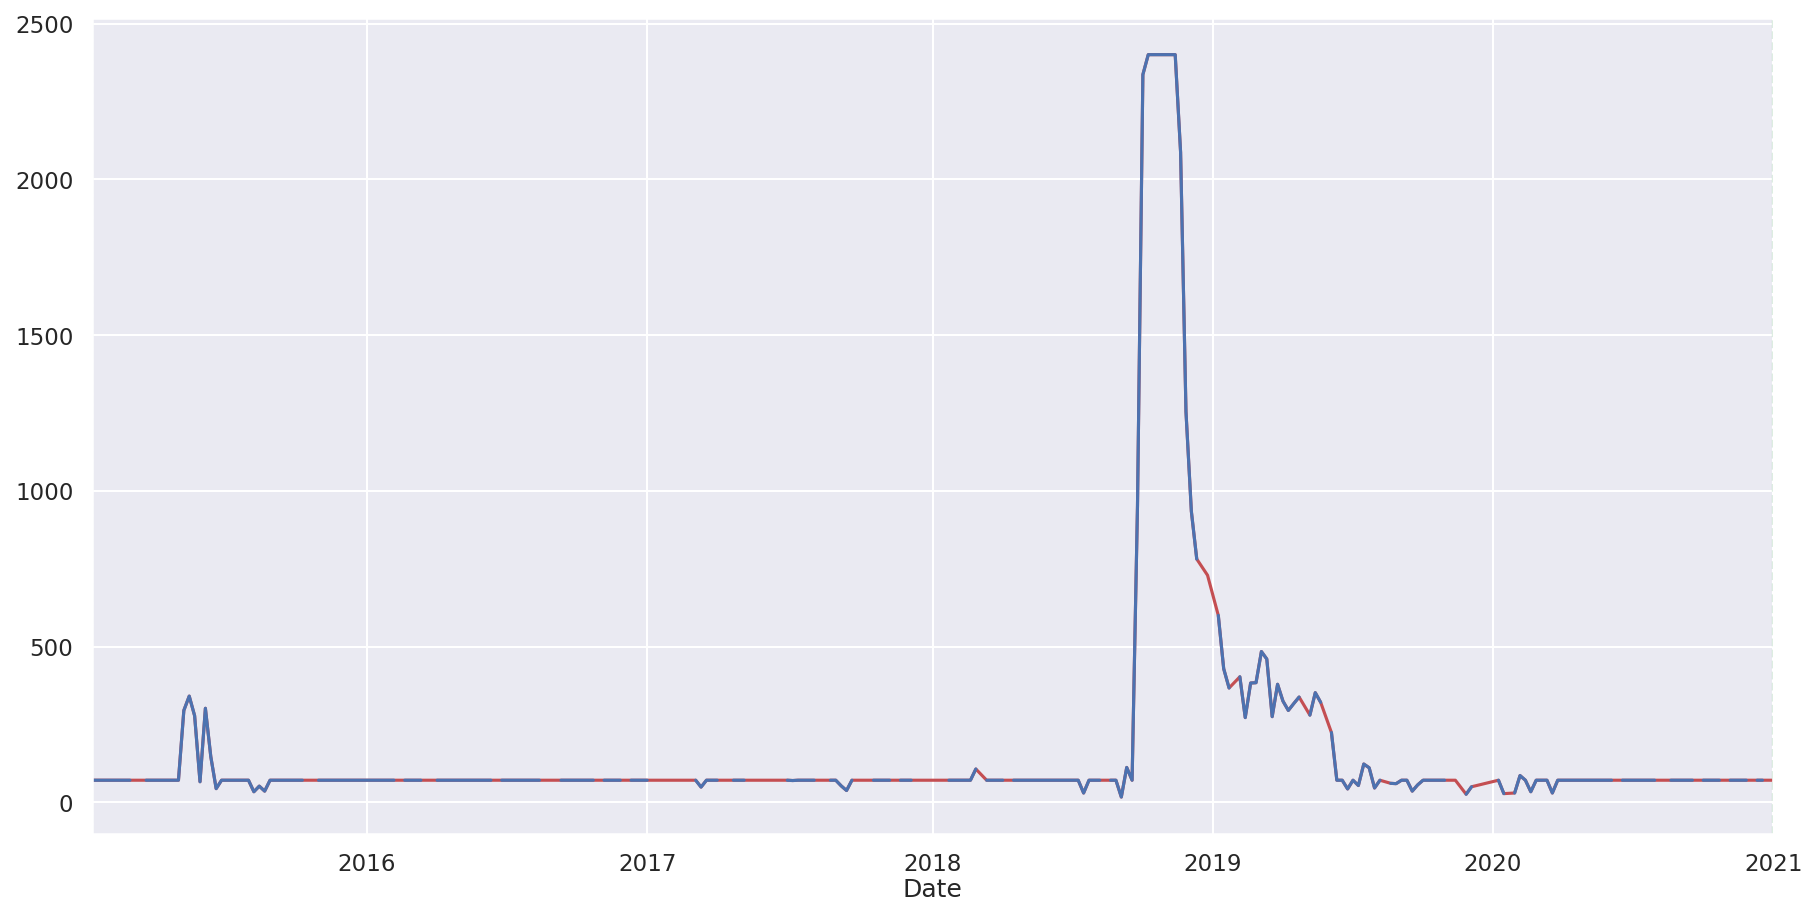

Fractions to remove:  {'psp_toxins_Mexilhão': 0.28}


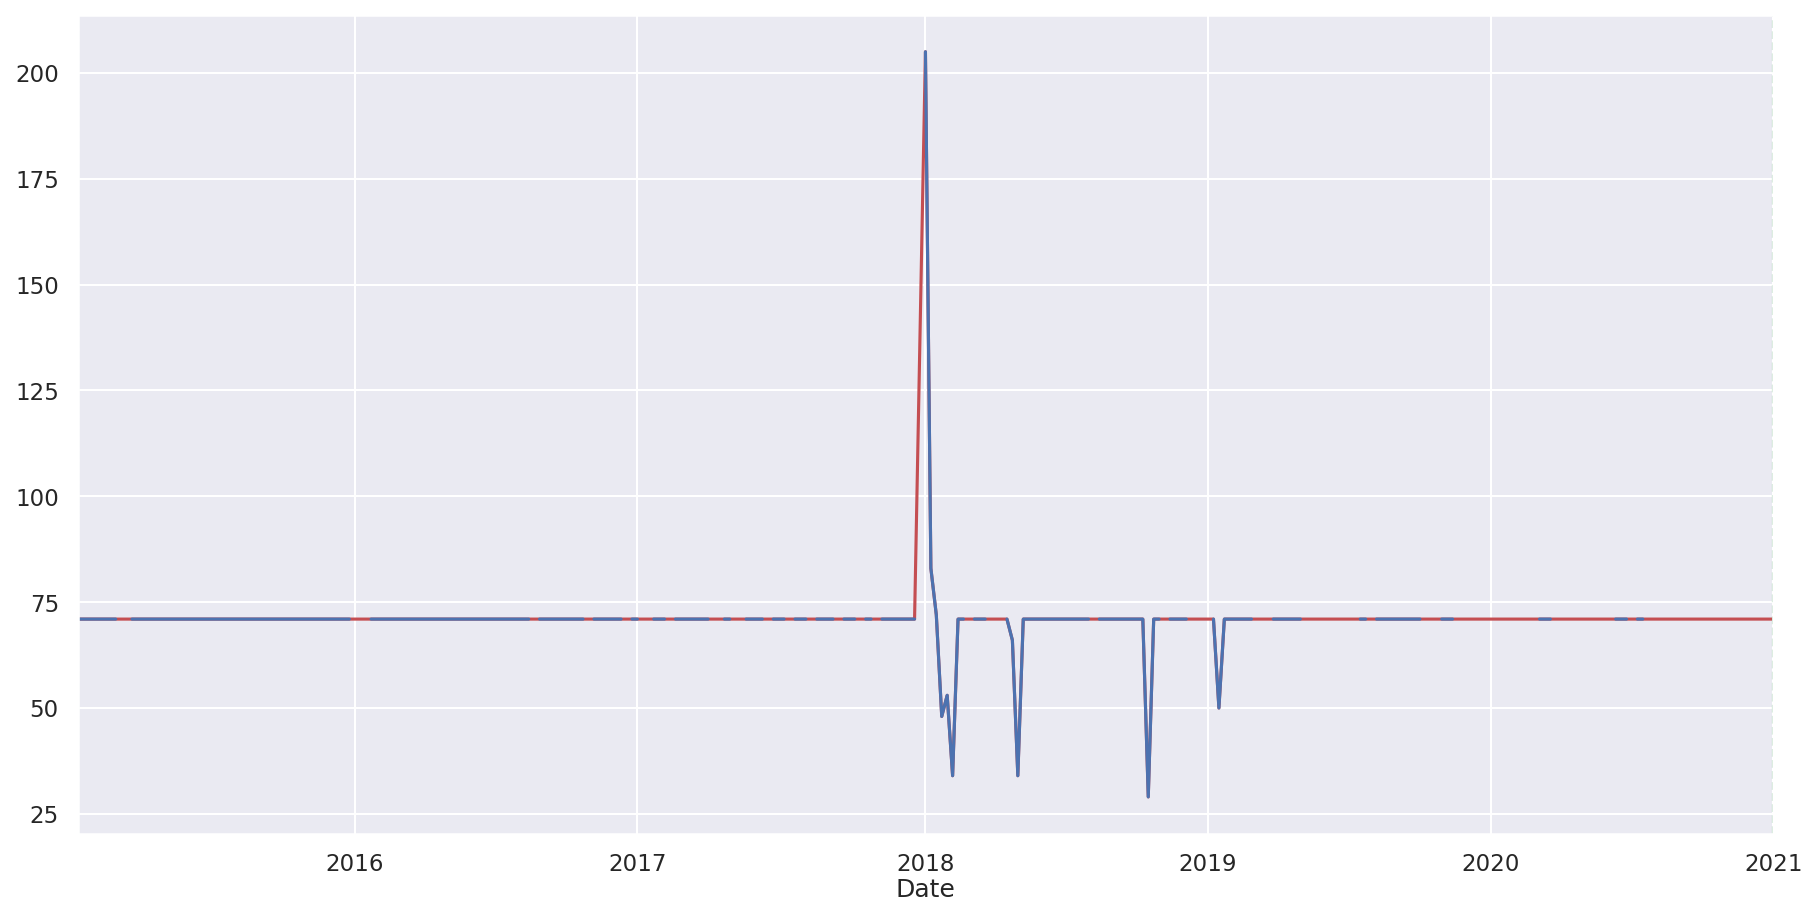

Fractions to remove:  {'psp_toxins_Mexilhão': 0.19}


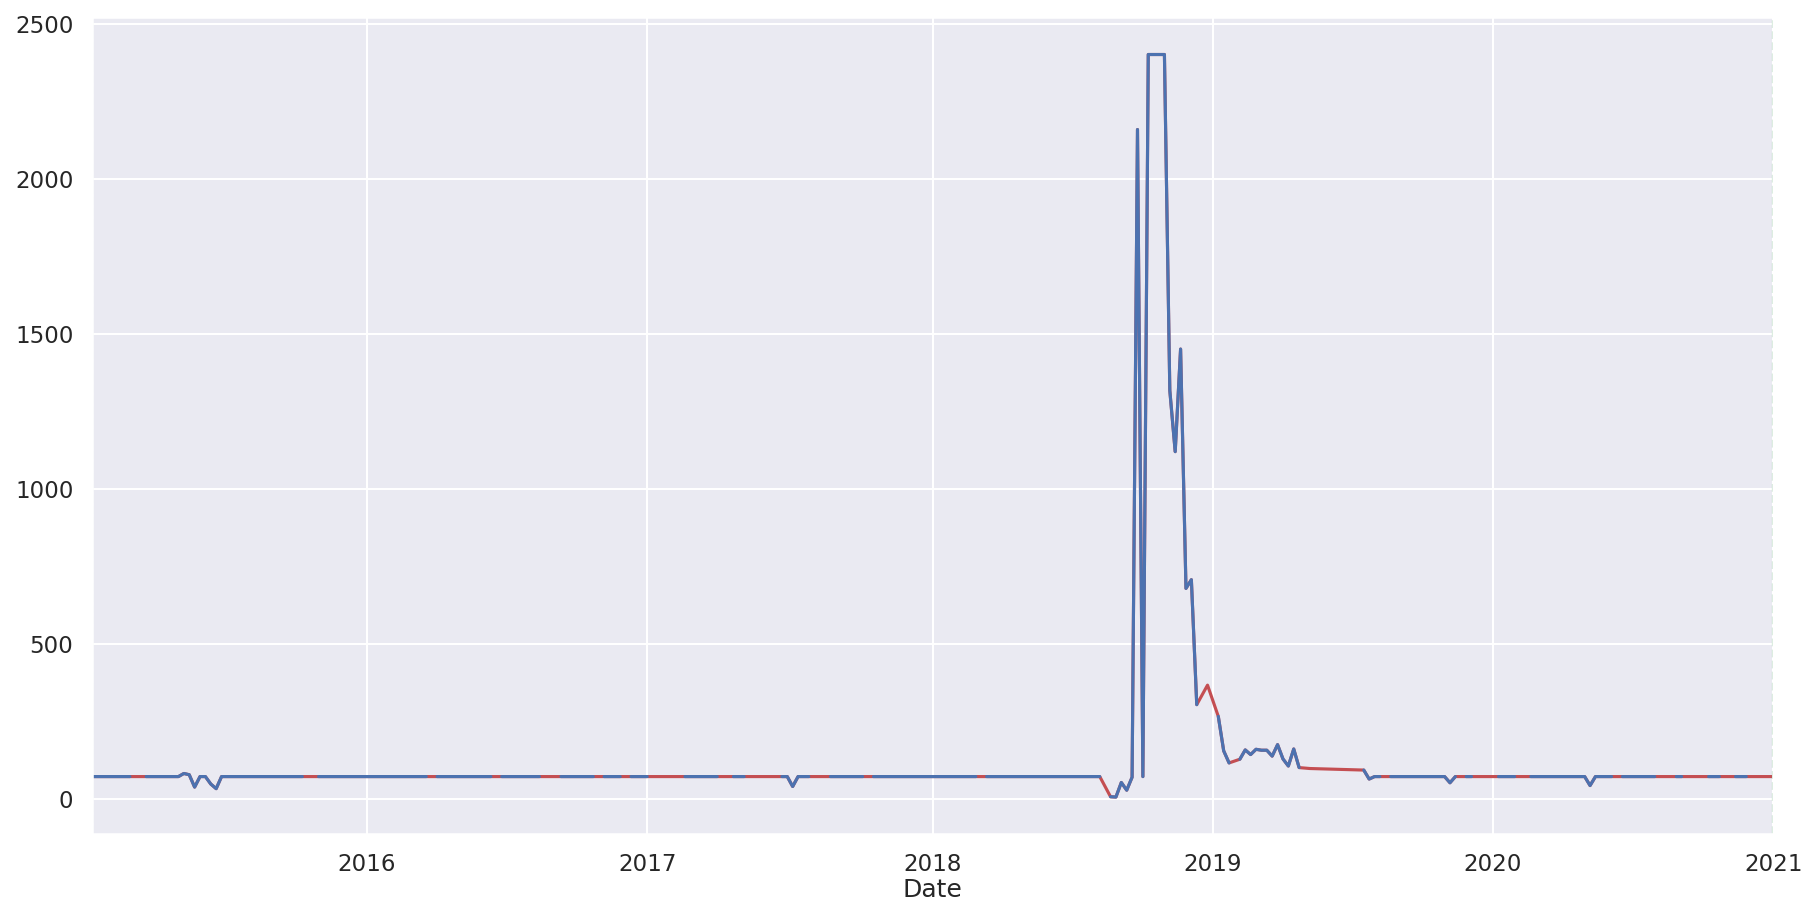

17

In [8]:
n_segments = -1
n_mult_per_segment = 5

columns_to_get = ["dsp_toxins", "asp_toxins", "psp_toxins"]
targets= ["psp_toxins"]
targets_imputation = [t+'_'+specie for t in targets]
print(targets_imputation)

dfs_per_area = {}
ts_to_impute = {}

#for area in list(to_impute.keys())[1:2]:
for area in species_to_impute:
    ts_list = []
    for specie in species_to_impute[area]:
        ts_list.append(get_ts(biotoxins_ts, area, specie, columns_to_get, "W", plot=False))
        ts_list[-1].columns = [c+"_"+specie for c in ts_list[-1].columns]

    ts_week = reduce(lambda left,right: pd.merge(left,right,left_index=True, right_index=True, how="outer"),ts_list)
    ts_to_impute[area] = ts_week
    dfs_complete, dfs_missing = get_segments_for_imputation(ts_week.copy(), targets_imputation, n_segments, n_mult_per_segment)
    dfs_per_area[area] = {"complete": dfs_complete, "missing": dfs_missing}

len(dfs_per_area)

In [9]:

#Random Forest, Mice e Amelia precisam que seja multivariado
#Amelia nao funciona quando todas/+1 variaveis sao NaN
#Amelia pode ser cross-sectional ou time series
#RF, EM, KNN e MICE são cross-sectional, logo, não tem em conta dependencia temporal
#Algoritmos cross-sectional podem ser uteis para tirar partido de conhecermos toxicidade de outros bivalves

imp_data_dir = "./imputed_data/"
    
imputationMethods = ['Mean', 'Median', 'Random sample', 'Interpolation', 'Locf', 'Nocb', 
                     'Moving average', 'Random forests', 
                     'Expectation maximization', 'Knn', 'Mice']

imputationMethods = ['Mean', 'Median', 'Random sample', 'Interpolation', 'Locf', 'Nocb', 
                     'Moving average', 'Expectation maximization', 'Knn']

run_imputation = True
suf = ''
if run_imputation:
    for area in dfs_per_area:
        print("#"*20)
        print("#",' '*5, area)
        print("# ", "-".join(species_to_impute[area]))
        print("#"*20)
        #print("Before:\n\n")
        #display(dfs_per_area[area]["complete"])
        #display(dfs_per_area[area]["missing"])
        #print("\n\n")
        sensor_dict = hyperparameter_tuning_bayesian(dfs_per_area[area]["complete"], 
                                                     dfs_per_area[area]["missing"], 
                                                     imputationMethods, targets_imputation, max_evals=100)
        print(sensor_dict)
        ts_imputed = impute_missing_values(ts_to_impute[area], sensor_dict, "none", rs)
        key = f'areacorr__{area}__{"_".join(targets_imputation)}{suf}'
        print(key)
        ts_imputed.to_csv(f"{imp_data_dir}{key}.csv")


####################
#       LAL
#  Mexilhão
####################
-------SENSOR------ psp_toxins_Mexilhão
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|████████| 100/100 [00:00<00:00, 394.44trial/s, best loss: 35.5192591216749]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|███████| 100/100 [00:00<00:00, 150.98trial/s, best loss: 50.06867122106776]
METHOD Expectation maximization
100%|███████| 100/100 [00:02<00:00, 34.76trial/s, best loss: 146.23083456729887]
METHOD Knn
100%|███████| 100/100 [00:01<00:00, 75.16trial/s, best loss: 125.43586003033508]
{'psp_toxins_Mexilhão': ['Nocb', []]}
areacorr__LAL__psp_toxins_Mexilhão
####################
#       RIAV2
#  Berbigão-Mexilhão
####################
-------SENSOR------ psp_toxins_Mexilhão
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|██████| 100/100 [00:00<00:00, 356.77trial/s, best loss: 139.10688391873808]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|██████| 100/100 [00:00<

/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:221: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:279: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  warnings.warn(


100%|███████| 100/100 [00:00<00:00, 269.62trial/s, best loss: 11.32634709930176]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|███████| 100/100 [00:01<00:00, 73.56trial/s, best loss: 10.630717912646944]
METHOD Expectation maximization
100%|███████| 100/100 [00:14<00:00,  6.84trial/s, best loss: 13.240999244961271]
METHOD Knn
100%|███████| 100/100 [00:03<00:00, 26.07trial/s, best loss: 10.818804677664966]
{'psp_toxins_Mexilhão': ['Moving average', [10, 0, False]]}
areacorr__L1__psp_toxins_Mexilhão
####################
#       LOB
#  Berbigão-Mexilhão
####################
-------SENSOR------ psp_toxins_Mexilhão
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|██████| 100/100 [00:00<00:00, 145.35trial/s, best loss: 12.545729774092996]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|███████| 100/100 [00:01<00:00, 56.53trial/s, best loss: 24.826644736832417]
METHOD Expectation maximization
100%|████████| 100/100 [00:11<00:00,  8.81trial/s, best loss: 39.60693

## Species

In [35]:
#ADD CONQUILHA
areas = ["OLH2", "L9"]
species = ["Mexilhão", "Conquilha"]

t = pd.DataFrame(columns=biotoxins_ts.columns)
for i in range(len(areas)):
    t = t.append(biotoxins_ts[ (biotoxins_ts["Production_Area"]==areas[i]) & (biotoxins_ts["Species"]==species[i]) ] )
    
t["Production_Area"] = "-".join(areas)
display(t)
biotoxins_ts = biotoxins_ts.append(t)
biotoxins_ts

,Sample,Species,Sample_Point,Production_Area,dsp_toxins,asp_toxins,psp_toxins
2015-01-05,5,Mexilhão,Fortaleza,OLH2-L9,40.0,1.8,71.0
2015-01-12,46,Mexilhão,Fortaleza,OLH2-L9,36.0,1.8,71.0
2015-01-19,85,Mexilhão,Fortaleza,OLH2-L9,32.0,1.8,71.0
2015-01-26,126,Mexilhão,Fortaleza,OLH2-L9,29.0,1.8,71.0
2015-02-03,178,Mexilhão,Fortaleza,OLH2-L9,37.0,1.8,71.0
...,...,...,...,...,...,...,...
2020-12-04,2099,Conquilha,Monte Gordo,OLH2-L9,36.0,1.8,71.0
2020-12-09,2116,Conquilha,Monte Gordo,OLH2-L9,36.0,1.8,71.0
2020-12-14,2137,Conquilha,Monte Gordo,OLH2-L9,36.0,NaN,71.0
2020-12-21,2170,Conquilha,Monte Gordo,OLH2-L9,36.0,1.8,71.0


,Sample,Species,Sample_Point,Production_Area,dsp_toxins,asp_toxins,psp_toxins
2015-01-05,1,Mexilhão,Jangada,LAL,20.0,1.8,71.0
2015-01-05,20,Berbigão,Canal do Espinheiro,RIAV3,36.0,1.8,71.0
2015-01-05,19,Berbigão,Costa Nova,RIAV2,26.0,1.8,71.0
2015-01-05,18,Berbigão,Moacha,RIAV1,36.0,1.8,71.0
2015-01-05,17,Amêijoa-branca,Torreira,L3,36.0,1.8,71.0
...,...,...,...,...,...,...,...
2020-12-04,2099,Conquilha,Monte Gordo,OLH2-L9,36.0,1.8,71.0
2020-12-09,2116,Conquilha,Monte Gordo,OLH2-L9,36.0,1.8,71.0
2020-12-14,2137,Conquilha,Monte Gordo,OLH2-L9,36.0,NaN,71.0
2020-12-21,2170,Conquilha,Monte Gordo,OLH2-L9,36.0,1.8,71.0


In [36]:
all_areas = biotoxins_ts["Production_Area"].unique()
all_areas

array(['LAL', 'RIAV3', 'RIAV2', 'RIAV1', 'L3', 'RIAV4', 'L2', 'L9',
       'FAR2', 'L8', 'FAR1', 'OLH2', 'VT', 'POR2', 'LAG', 'OLH3', 'OLH4',
       'L7a', 'L1', 'FUZ', 'OLH5', 'EMN2', 'LOB', 'L7c2', 'L7c1', 'L5a',
       'ESD2', 'L6', 'ESD1', 'OLH1', 'L5b', 'TAV', 'ETJ1', 'EMR', 'EMI',
       'ELM', 'L7c', 'EMN1', 'L5', 'L4', 'POR3', 'L7b', 'GUA', 'ETJ2',
       'OLH2-L9'], dtype=object)

In [37]:
min_per_specie = 200
species_to_impute = {}
for area in all_areas:
    vc = biotoxins_ts[ biotoxins_ts["Production_Area"] == area]["Species"].value_counts()
    vc = vc[vc > min_per_specie]
    if len(vc)>1:
        species_to_impute[area] = vc.keys().tolist()

species_to_impute

{'RIAV2': ['Berbigão', 'Mexilhão'],
 'RIAV1': ['Berbigão', 'Mexilhão'],
 'L2': ['Mexilhão', 'Amêijoa-branca'],
 'LOB': ['Berbigão', 'Mexilhão'],
 'OLH2-L9': ['Conquilha', 'Mexilhão']}

In [38]:
for area in all_areas:
    vc = biotoxins_ts[ biotoxins_ts["Production_Area"] == area]["Species"].value_counts()
    print(vc[vc>200])
    print("------------------------")

Mexilhão    300
Name: Species, dtype: int64
------------------------
Berbigão    283
Name: Species, dtype: int64
------------------------
Berbigão    302
Mexilhão    288
Name: Species, dtype: int64
------------------------
Berbigão    308
Mexilhão    293
Name: Species, dtype: int64
------------------------
Series([], Name: Species, dtype: int64)
------------------------
Series([], Name: Species, dtype: int64)
------------------------
Mexilhão          251
Amêijoa-branca    240
Name: Species, dtype: int64
------------------------
Conquilha    289
Name: Species, dtype: int64
------------------------
Series([], Name: Species, dtype: int64)
------------------------
Conquilha    261
Name: Species, dtype: int64
------------------------
Mexilhão    255
Name: Species, dtype: int64
------------------------
Mexilhão    284
Name: Species, dtype: int64
------------------------
Series([], Name: Species, dtype: int64)
------------------------
Mexilhão    246
Name: Species, dtype: int64
-------------

OLH2-L9
Conquilha
Fractions to remove:  {'dsp_toxins': 0.23}


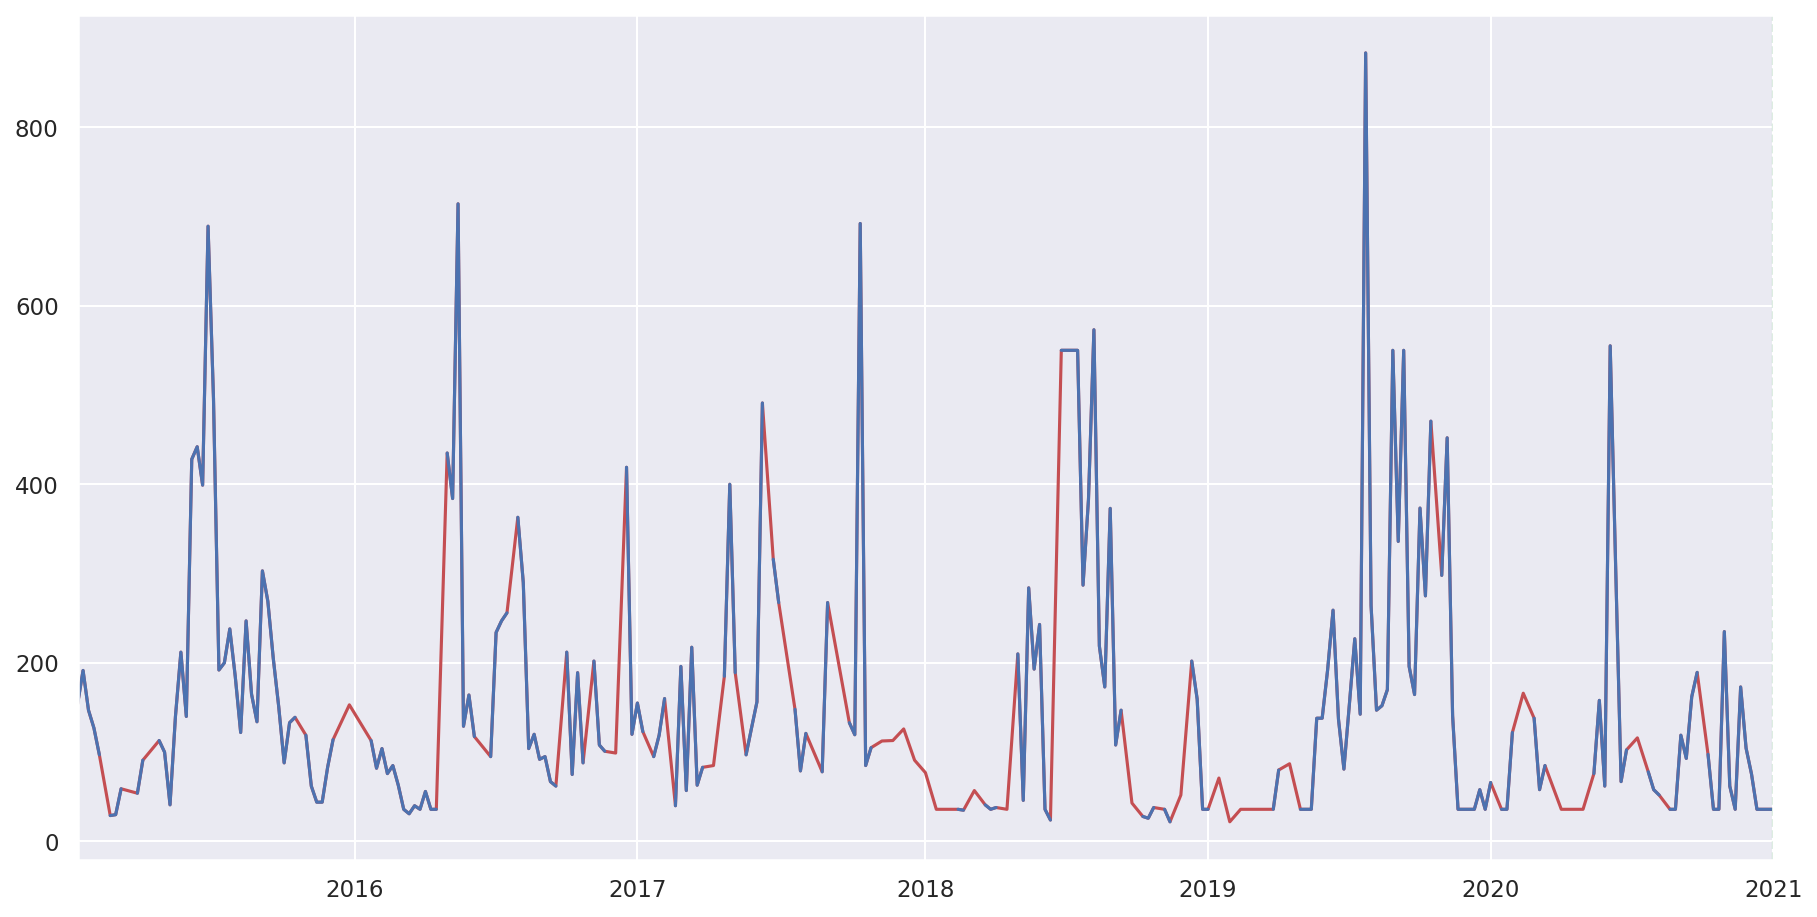

Mexilhão
Fractions to remove:  {'dsp_toxins': 0.13}


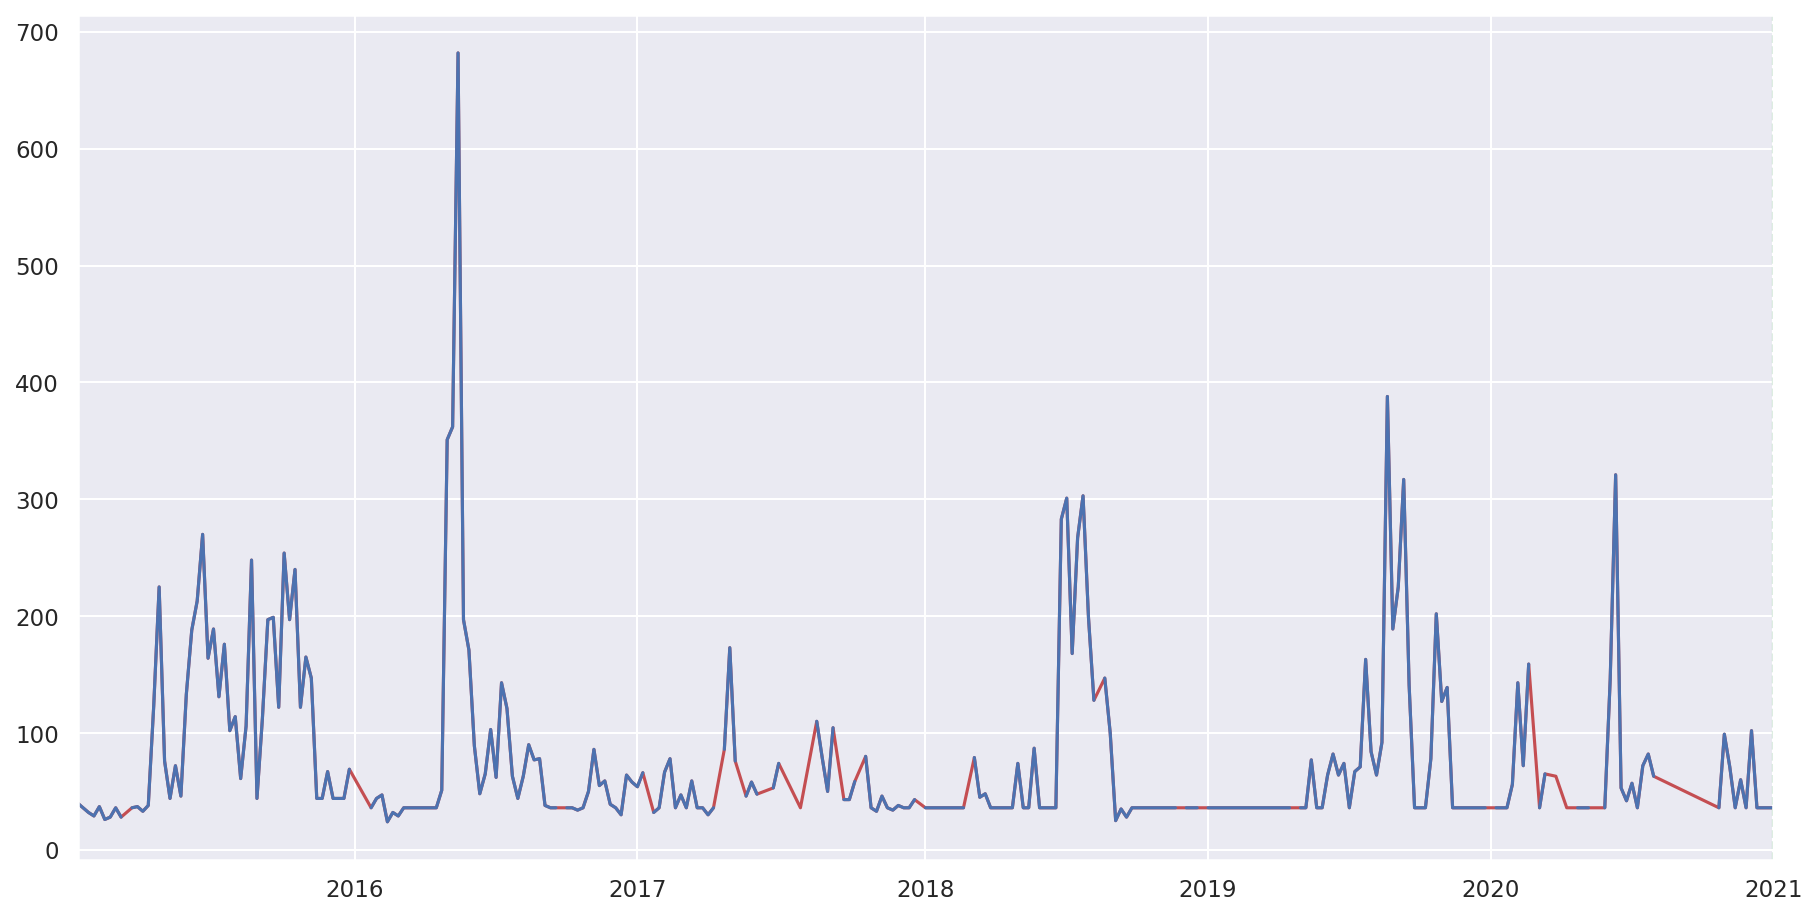

5

In [46]:
n_segments = -1
n_mult_per_segment = 5

columns_to_get = ["dsp_toxins", "asp_toxins", "psp_toxins"]
targets= ["dsp_toxins"]
#targets_imputation = [t+'_'+specie for t in targets]
#print(targets_imputation)

dfs_per_area = {}
ts_to_impute = {}

#for area in list(to_impute.keys())[1:2]:
for area in species_to_impute:
    print(area)
    ts_list = []
    for specie in species_to_impute[area]:
        print(specie)
        key = area + '_' + specie
        ts_week = get_ts(biotoxins_ts, area, specie, columns_to_get, "W", plot=False)
        ts_to_impute[key] = ts_week
        dfs_complete, dfs_missing = get_segments_for_imputation(ts_week.copy(), targets, n_segments, n_mult_per_segment)
        dfs_per_area[key] = {"complete": dfs_complete, "missing": dfs_missing}


len(dfs_per_area[key]["complete"])

In [49]:
from functions.automts.bayesian import hyperparameter_tuning_bayesian

#Random Forest, Mice e Amelia precisam que seja multivariado
#Amelia nao funciona quando todas/+1 variaveis sao NaN
#Amelia pode ser cross-sectional ou time series
#RF, EM, KNN e MICE são cross-sectional, logo, não tem em conta dependencia temporal
#Algoritmos cross-sectional podem ser uteis para tirar partido de conhecermos toxicidade de outros bivalves

imp_data_dir = "./imputed_data/"
    
imputationMethods = ['Mean', 'Median', 'Random sample', 'Interpolation', 'Locf', 'Nocb', 
                     'Moving average', 'Random forests', 
                     'Expectation maximization', 'Knn', 'Mice']

imputationMethods = ['Mean', 'Median', 'Random sample', 'Interpolation', 'Locf', 'Nocb', 
                     'Moving average','Expectation maximization', 'Knn']

run_imputation = True
if run_imputation:
    for key in dfs_per_area:
        print("#"*20)
        print("#",' '*5, key)
        print("#"*20)
        sensor_dict = hyperparameter_tuning_bayesian(dfs_per_area[key]["complete"], 
                                                     dfs_per_area[key]["missing"], 
                                                     imputationMethods, targets, max_evals=100)
        print(sensor_dict)
        ts_imputed = impute_missing_values(ts_to_impute[key], sensor_dict, "none", rs)
        ts_imputed = ts_imputed.rename_axis("Date").reset_index()
        key = f'speciecorr__{key}__{"_".join(targets)}'
        print(key)
        ts_imputed.to_csv(f"{imp_data_dir}{key}.csv")


####################
#       OLH2-L9_Conquilha
####################
-------SENSOR------ dsp_toxins
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|███████| 100/100 [00:00<00:00, 361.41trial/s, best loss: 63.60353934033323]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|███████| 100/100 [00:00<00:00, 123.94trial/s, best loss: 62.09903794794896]
METHOD Expectation maximization
100%|█████████| 100/100 [00:05<00:00, 16.76trial/s, best loss: 92.2870658515121]
METHOD Knn
100%|████████| 100/100 [00:01<00:00, 56.11trial/s, best loss: 74.62158710596552]
{'dsp_toxins': ['Moving average', [10, 0, True]]}
speciecorr__OLH2-L9_Conquilha__dsp_toxins
####################
#       OLH2-L9_Mexilhão
####################
-------SENSOR------ dsp_toxins
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|███████| 100/100 [00:00<00:00, 237.83trial/s, best loss: 18.83224977958011]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|███████| 100/100 [00:01<00:00,

## Phyto

In [6]:
phyto_ts

,Sample,Production_Area,asp_phyto,dsp_phyto,psp_phyto
Date,,,,,
2014-10-31,1809.0,L6,20.0,20.0,20.0
2014-11-03,1785.0,LAL,20.0,20.0,20.0
2014-11-03,1820.0,RIAV4,20.0,20.0,20.0
2014-11-03,1821.0,L3,20.0,20.0,200.0
2014-11-03,1823.0,RIAV2,20.0,20.0,20.0
...,...,...,...,...,...
2020-12-29,1612.0,L1,20.0,20.0,20.0
2020-12-29,1614.0,POR2,440.0,40.0,20.0
2020-12-29,1615.0,LAG,4760.0,20.0,20.0


In [7]:
all_areas1 = phyto_ts["Production_Area"].unique()
all_areas2 = biotoxins_ts["Production_Area"].unique()
all_areas = list(set(list(all_areas1) + list(all_areas2)))
all_areas = phyto_ts["Production_Area"].unique()
all_areas

array(['L6', 'LAL', 'RIAV4', 'L3', 'RIAV2', 'RIAV3', 'L7c', 'L2', 'L1',
       'OLH4', 'L8', 'OLH2', 'OLH3', 'ETJ1', 'L9', 'FUZ', 'TAV', 'VT',
       'OLH1', 'OLH5', 'RIAV1', 'FAR2', 'EMN2', 'L7a', 'POR2', 'L5',
       'LAG', 'LOB', 'ESD1', 'ELM', 'EMI', 'ESD2', 'FAR1', 'EMR',
       'RIAV1/L3', 'LAG1', 'EMN1', 'L4', 'POR3', 'L7b', 'L5b', 'L5a',
       'GUA', 'L7c2', 'L7c1'], dtype=object)

In [14]:
min_per_specie = 200
areas_to_impute = []
toxin = "psp_phyto"

for area in all_areas:
    ts_week = get_ts(phyto_ts, area, None, [toxin], "W", plot=False)
    vc = ts_week[toxin].notnull().sum()
    if vc > min_per_specie:
        areas_to_impute.append(area)

areas_to_impute

['L6',
 'LAL',
 'RIAV4',
 'L3',
 'RIAV2',
 'RIAV3',
 'L7c',
 'L2',
 'L1',
 'L8',
 'OLH2',
 'OLH3',
 'ETJ1',
 'L9',
 'FUZ',
 'TAV',
 'VT',
 'OLH1',
 'OLH5',
 'RIAV1',
 'FAR2',
 'EMN2',
 'L7a',
 'POR2',
 'LAG',
 'LOB',
 'ESD1',
 'ELM',
 'FAR1']

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-02,20.0,20.0,20.0
2014-11-09,20.0,20.0,20.0
2014-11-16,20.0,3136.0,20.0
2014-11-23,20.0,3694.0,20.0
2014-11-30,20.0,578.0,50.0
...,...,...,...
2020-12-06,1720.0,180.0,20.0
2020-12-13,NaN,NaN,NaN
2020-12-20,20.0,25010.0,20.0


Fractions to remove:  {'psp_phyto': 0.04}


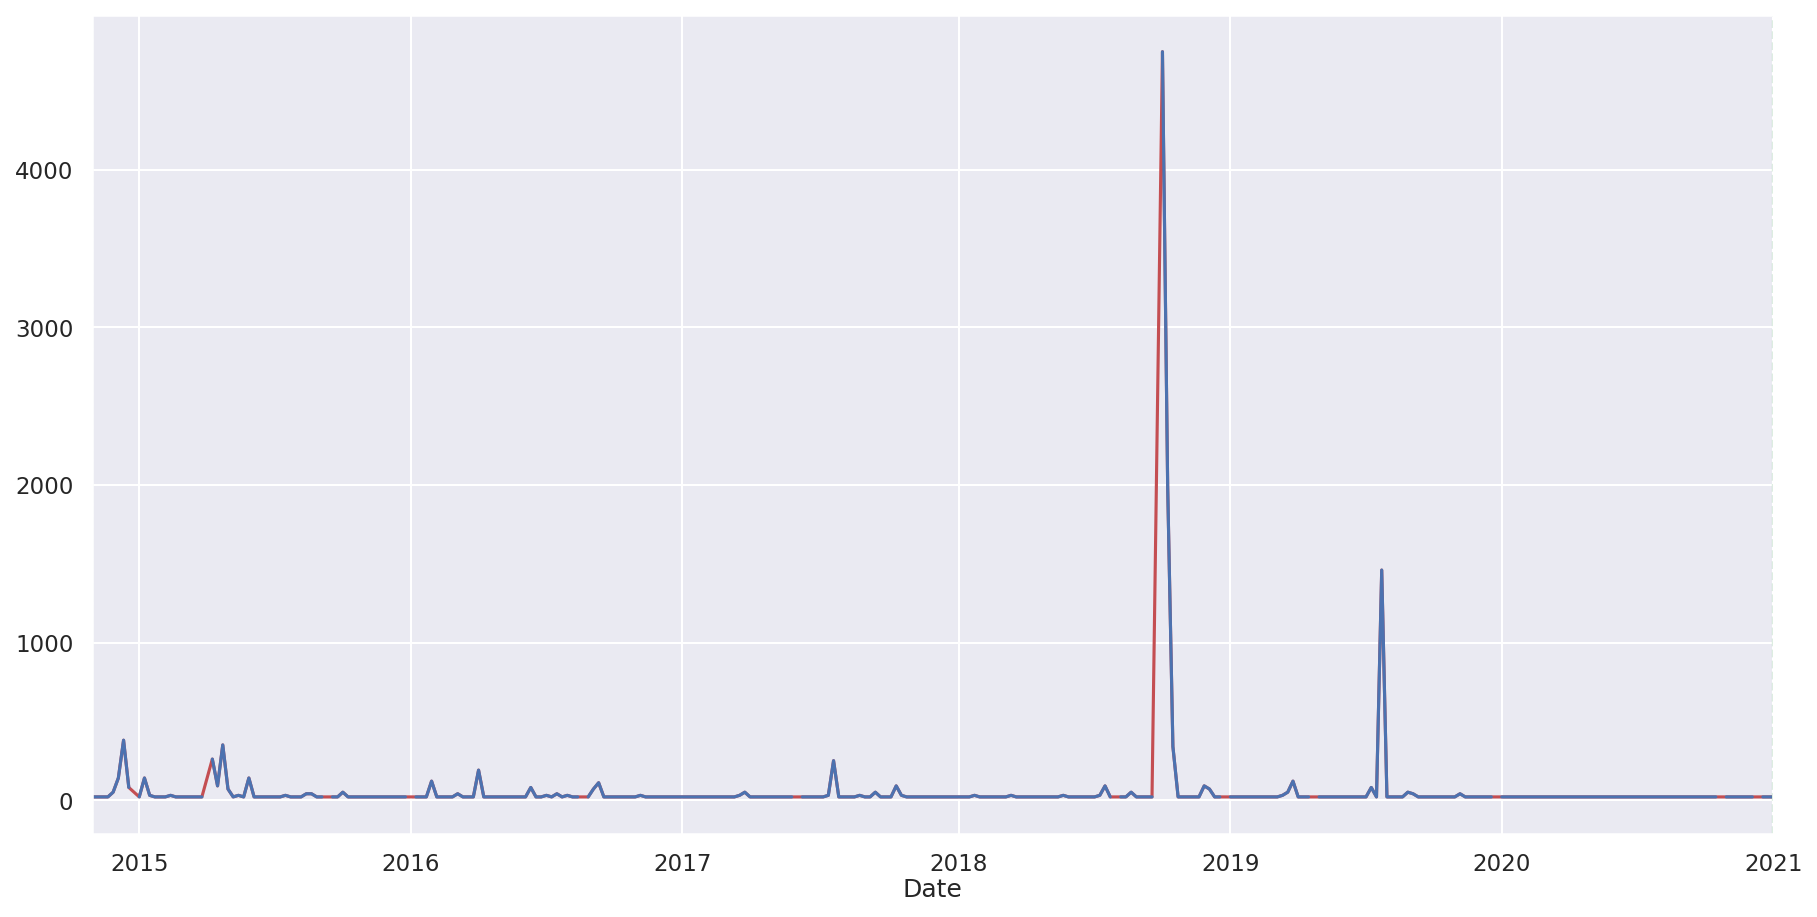

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,20.0,20.0,20.0
2014-11-16,20.0,20.0,440.0
2014-11-23,20.0,79200.0,160.0
2014-11-30,20.0,20.0,20.0
2014-12-07,20.0,20.0,20.0
...,...,...,...
2020-12-06,120.0,578100.0,20.0
2020-12-13,280.0,105780.0,20.0
2020-12-20,120.0,8040.0,20.0


Fractions to remove:  {'psp_phyto': 0.07}


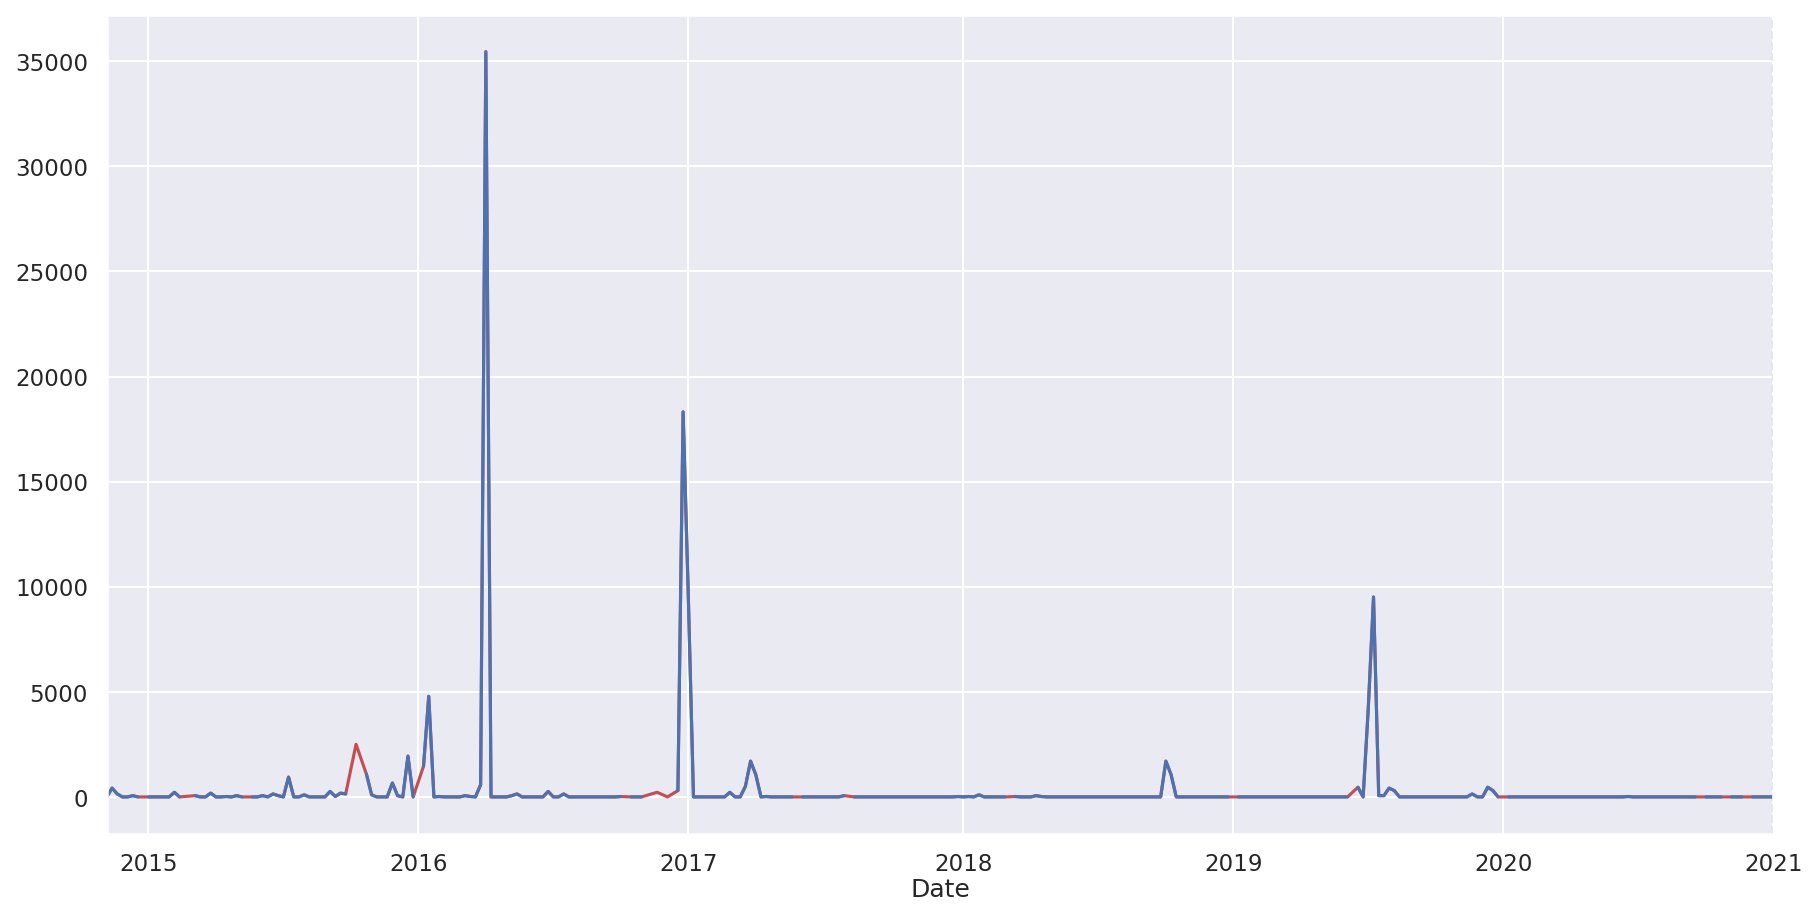

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,20.0,20.0,20.0
2014-11-16,20.0,20.0,20.0
2014-11-23,20.0,20.0,160.0
2014-11-30,20.0,20.0,20.0
2014-12-07,20.0,20.0,40.0
...,...,...,...
2020-11-29,20.0,2120.0,20.0
2020-12-06,20.0,20.0,20.0
2020-12-13,NaN,NaN,NaN


Fractions to remove:  {'psp_phyto': 0.07}


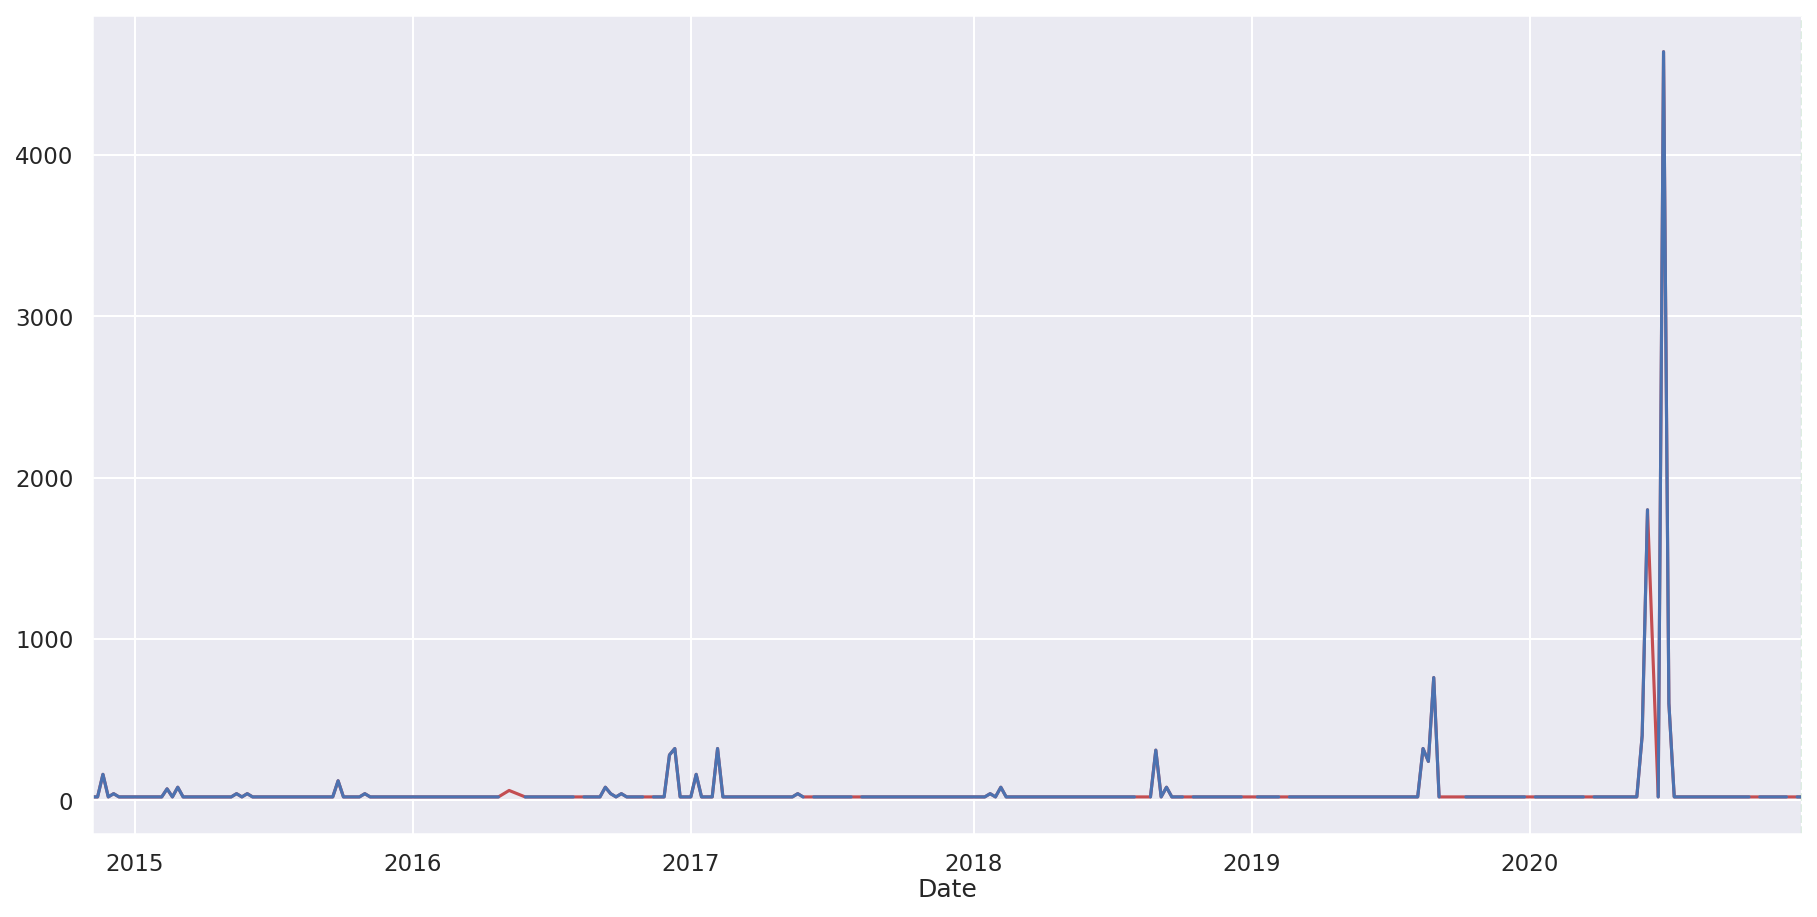

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,20.0,20.0,260.0
2014-11-16,20.0,20.0,30.0
2014-11-23,20.0,20.0,20.0
2014-11-30,20.0,20.0,40.0
2014-12-07,20.0,20.0,20.0
...,...,...,...
2020-11-29,3420.0,2200.0,20.0
2020-12-06,140.0,20.0,20.0
2020-12-13,80.0,420.0,20.0


Fractions to remove:  {'psp_phyto': 0.03}


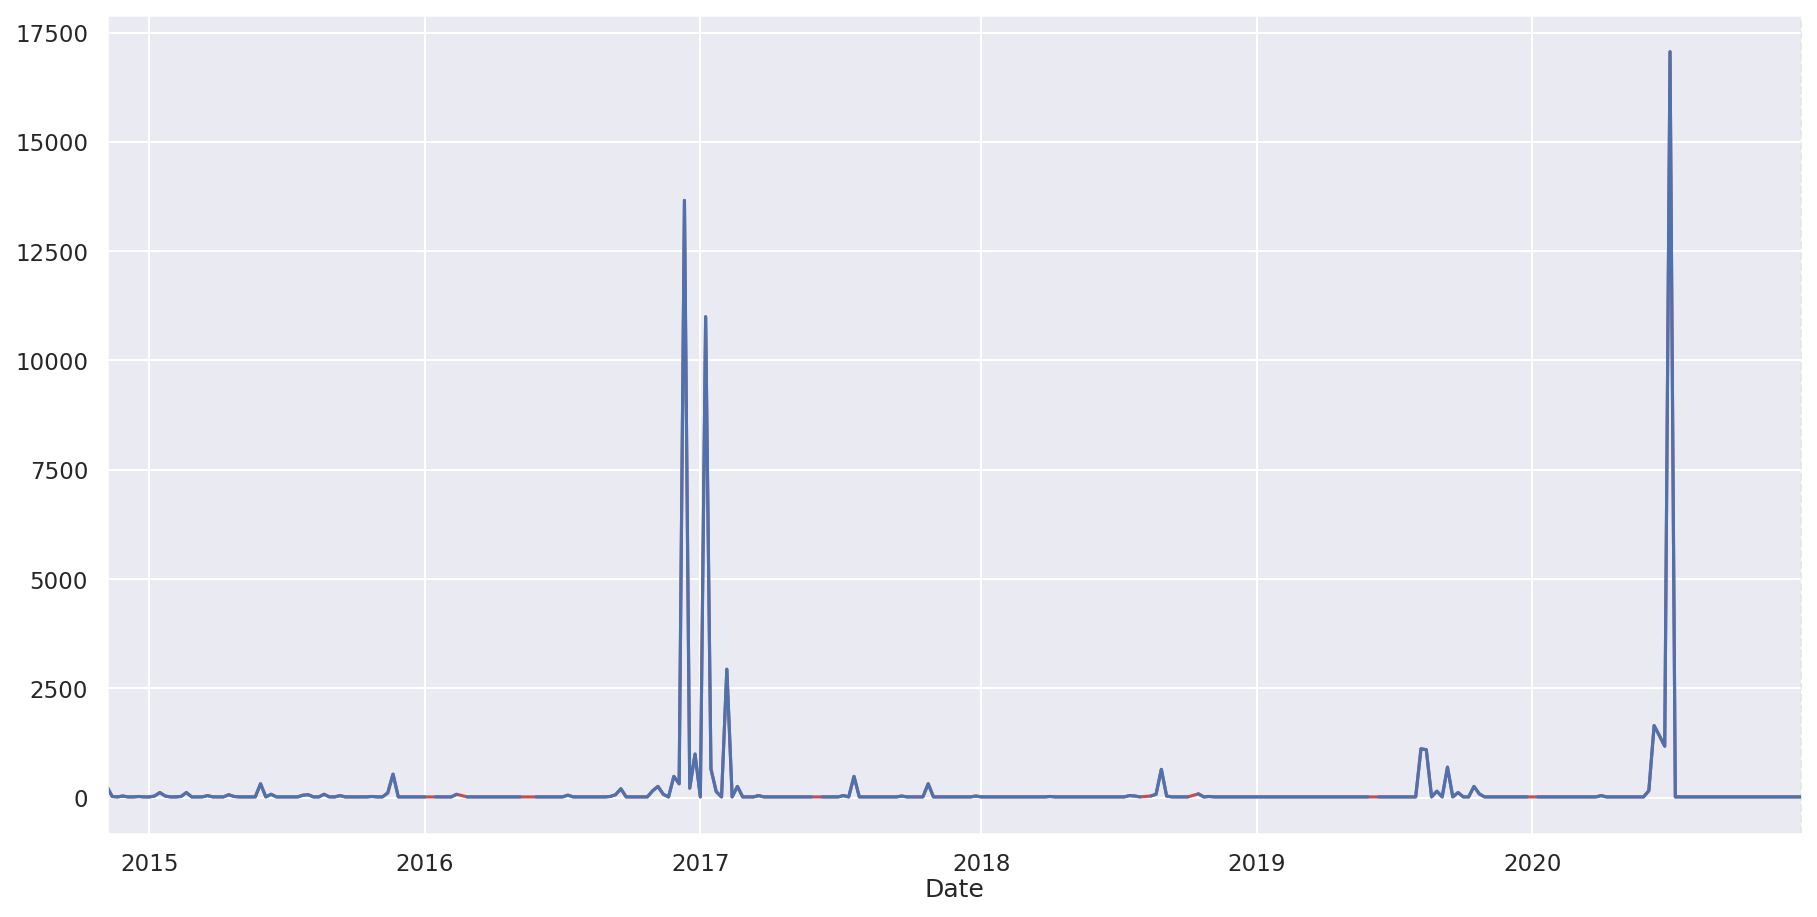

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,20.0,20.0,20.0
2014-11-16,20.0,20.0,20.0
2014-11-23,20.0,20.0,20.0
2014-11-30,20.0,20.0,20.0
2014-12-07,20.0,20.0,20.0
...,...,...,...
2020-11-29,520.0,440.0,20.0
2020-12-06,20.0,20.0,20.0
2020-12-13,40.0,760.0,20.0


Fractions to remove:  {'psp_phyto': 0.04}


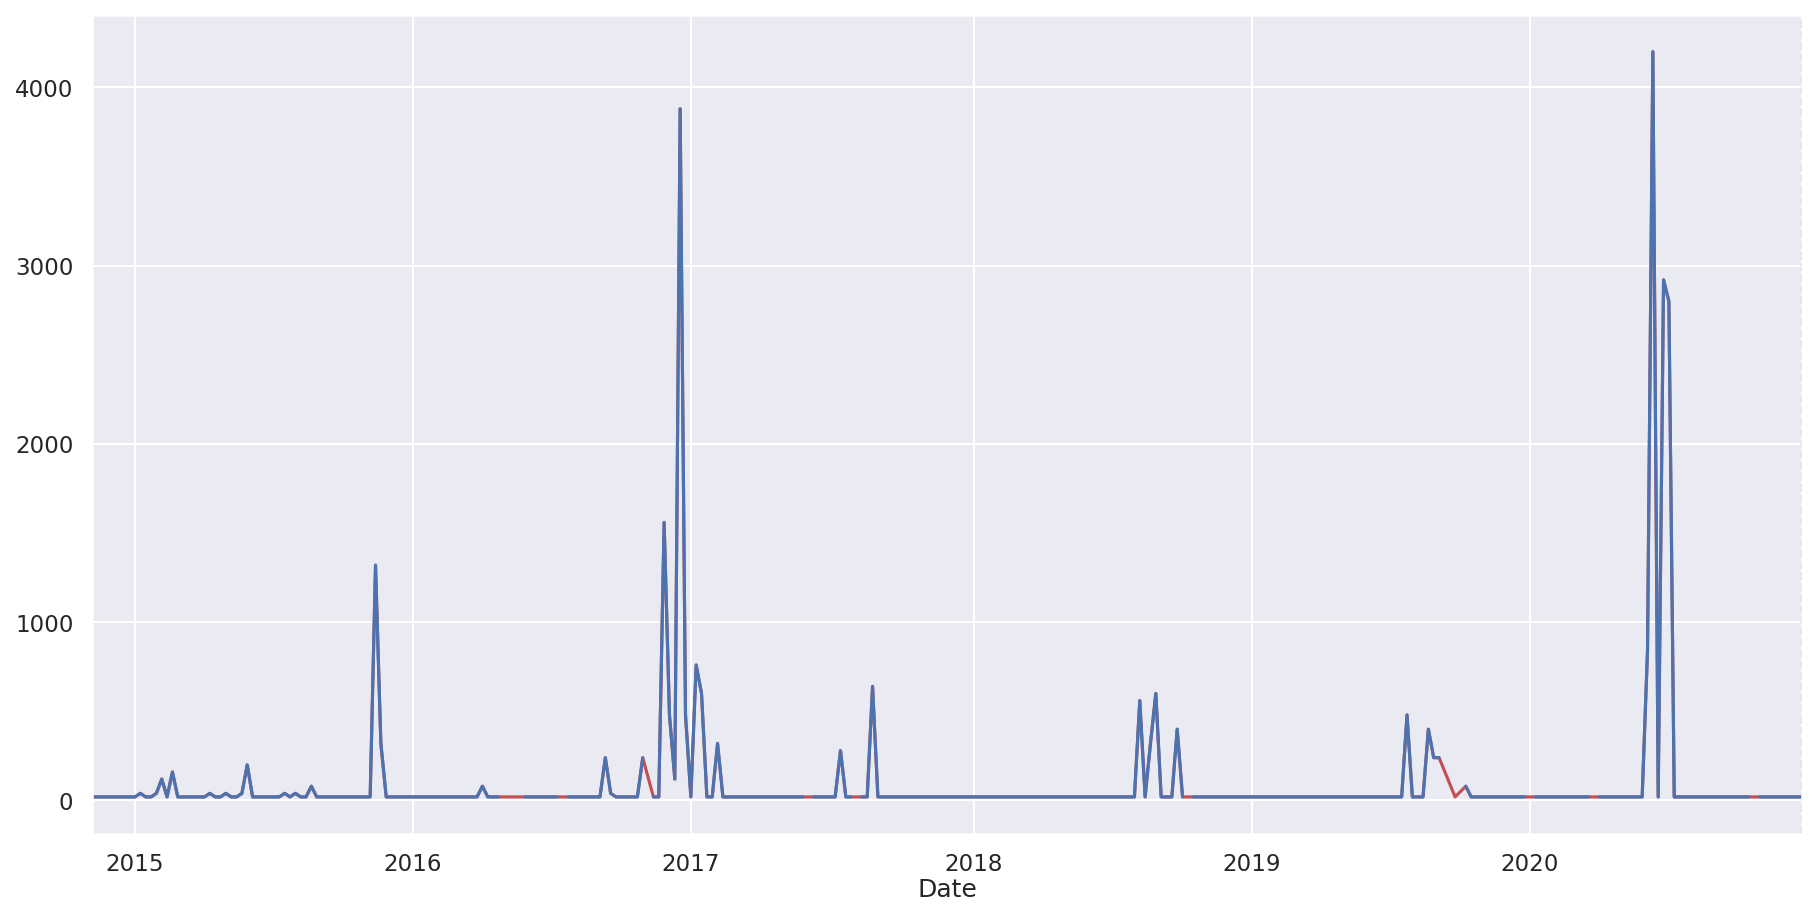

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,20.0,20.0,20.0
2014-11-16,20.0,20.0,20.0
2014-11-23,20.0,20.0,80.0
2014-11-30,20.0,20.0,20.0
2014-12-07,20.0,20.0,20.0
...,...,...,...
2020-11-29,360.0,1240.0,20.0
2020-12-06,120.0,20.0,20.0
2020-12-13,80.0,160.0,20.0


Fractions to remove:  {'psp_phyto': 0.06}


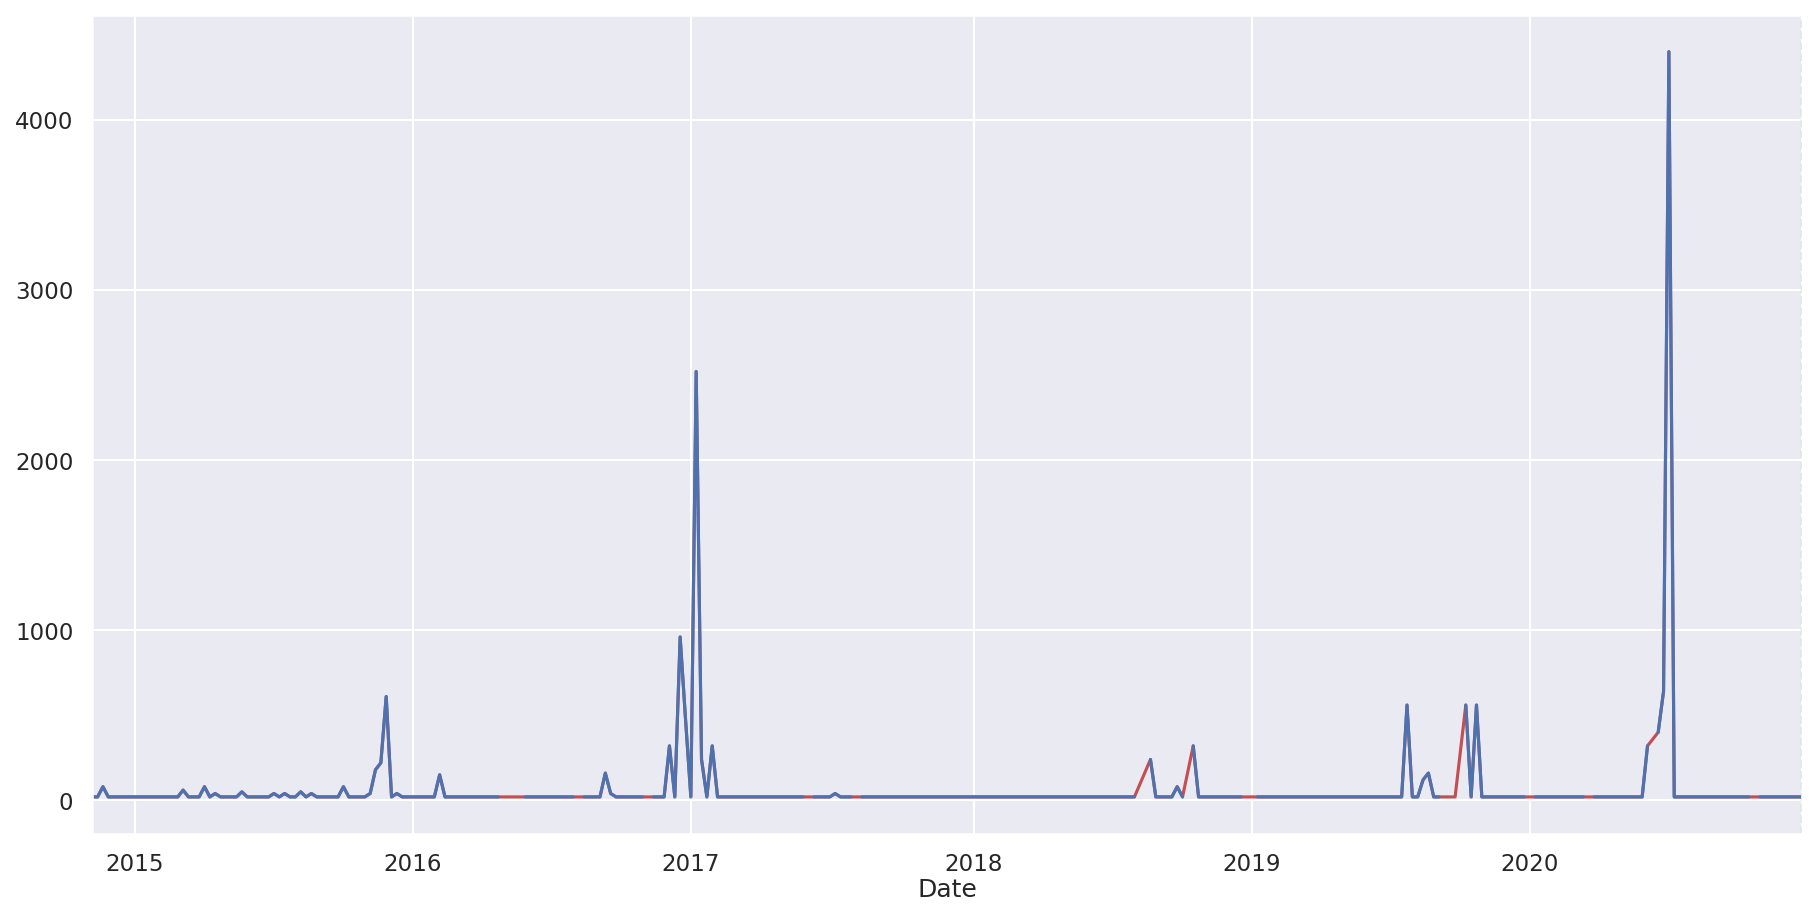

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,20.0,4939.333333,33.333333
2014-11-16,20.0,9332.333333,20.000000
2014-11-23,20.0,46367.666667,458.666667
2014-11-30,50.0,20.000000,20.000000
2014-12-07,20.0,20.000000,20.000000
...,...,...,...
2018-10-28,20.0,7595.000000,20.000000
2018-11-04,20.0,2870.000000,20.000000
2018-11-11,20.0,146780.000000,20.000000


Fractions to remove:  {'psp_phyto': 0.03}


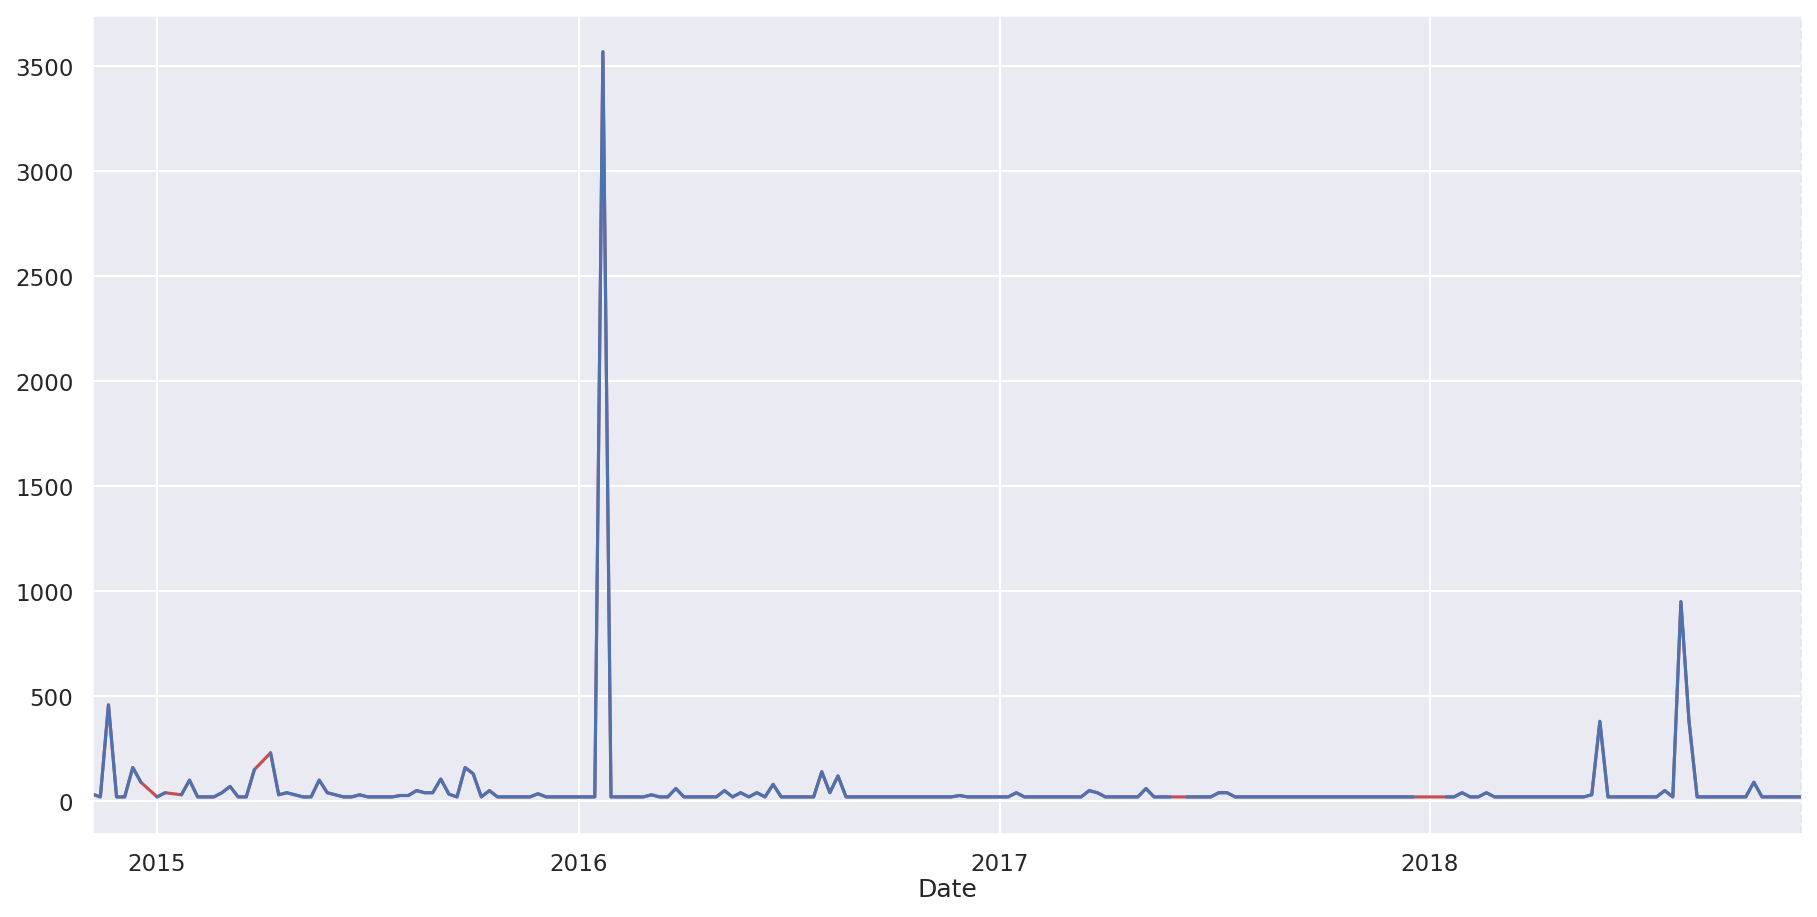

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,20.0,20.0,20.0
2014-11-16,20.0,20.0,20.0
2014-11-23,20.0,20.0,20.0
2014-11-30,20.0,20.0,20.0
2014-12-07,20.0,20.0,40.0
...,...,...,...
2020-12-06,140.0,110.0,20.0
2020-12-13,40.0,110.0,20.0
2020-12-20,20.0,20.0,20.0


Fractions to remove:  {'psp_phyto': 0.06}


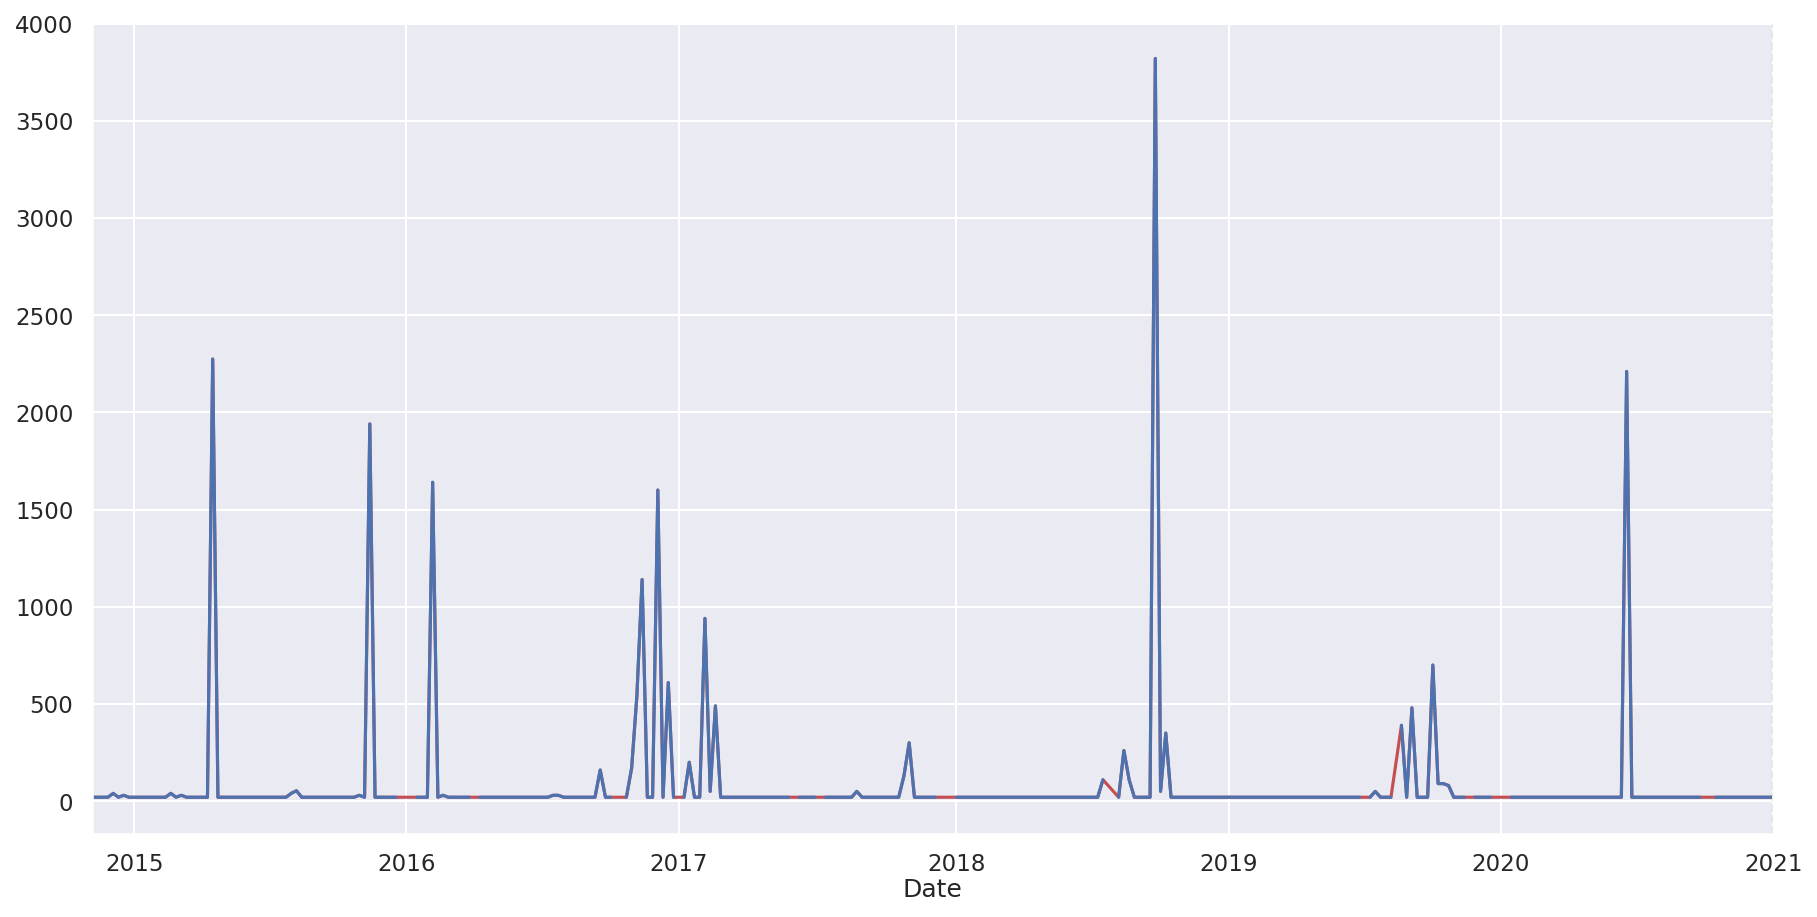

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,20.0,20.0,210.000000
2014-11-16,20.0,20.0,20.000000
2014-11-23,20.0,20.0,26.666667
2014-11-30,20.0,20.0,20.000000
2014-12-07,20.0,20.0,20.000000
...,...,...,...
2020-12-06,20.0,20.0,20.000000
2020-12-13,20.0,20.0,20.000000
2020-12-20,20.0,20.0,20.000000


Fractions to remove:  {'psp_phyto': 0.07}


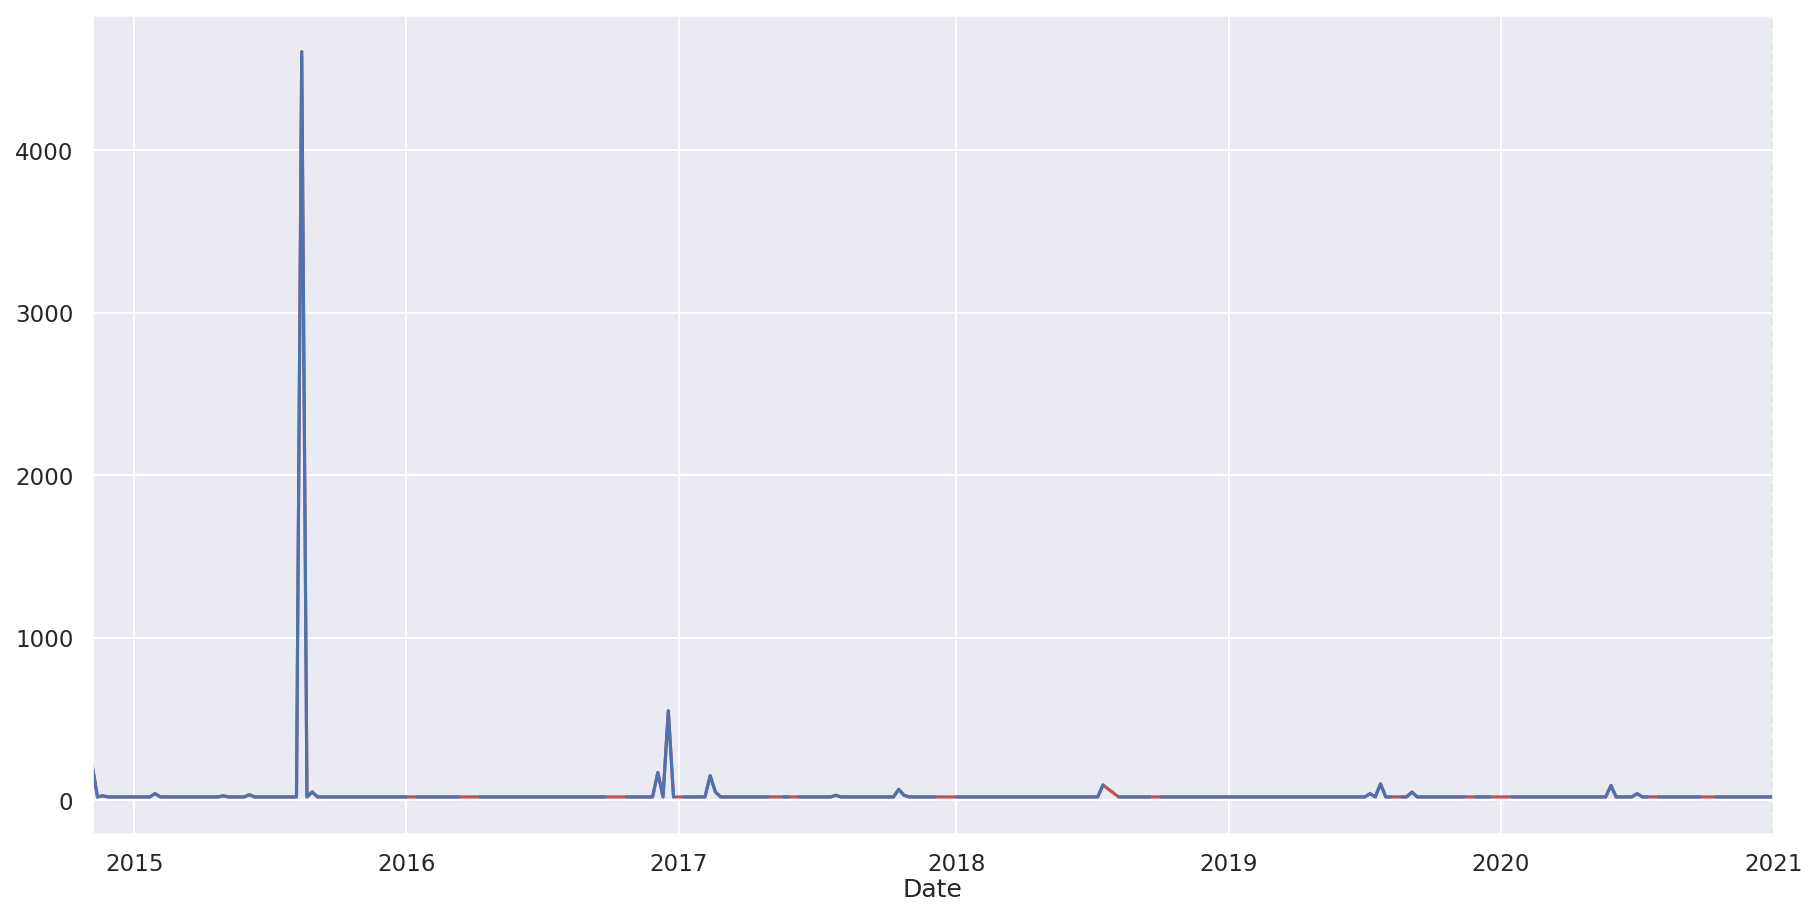

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,40.000000,4939.333333,20.000000
2014-11-16,20.000000,3031.333333,20.000000
2014-11-23,20.000000,6455.000000,612.000000
2014-11-30,60.000000,20.000000,40.000000
2014-12-07,253.333333,20.000000,193.333333
...,...,...,...
2020-10-04,NaN,NaN,NaN
2020-10-11,NaN,NaN,NaN
2020-10-18,NaN,NaN,NaN


Fractions to remove:  {'psp_phyto': 0.32}


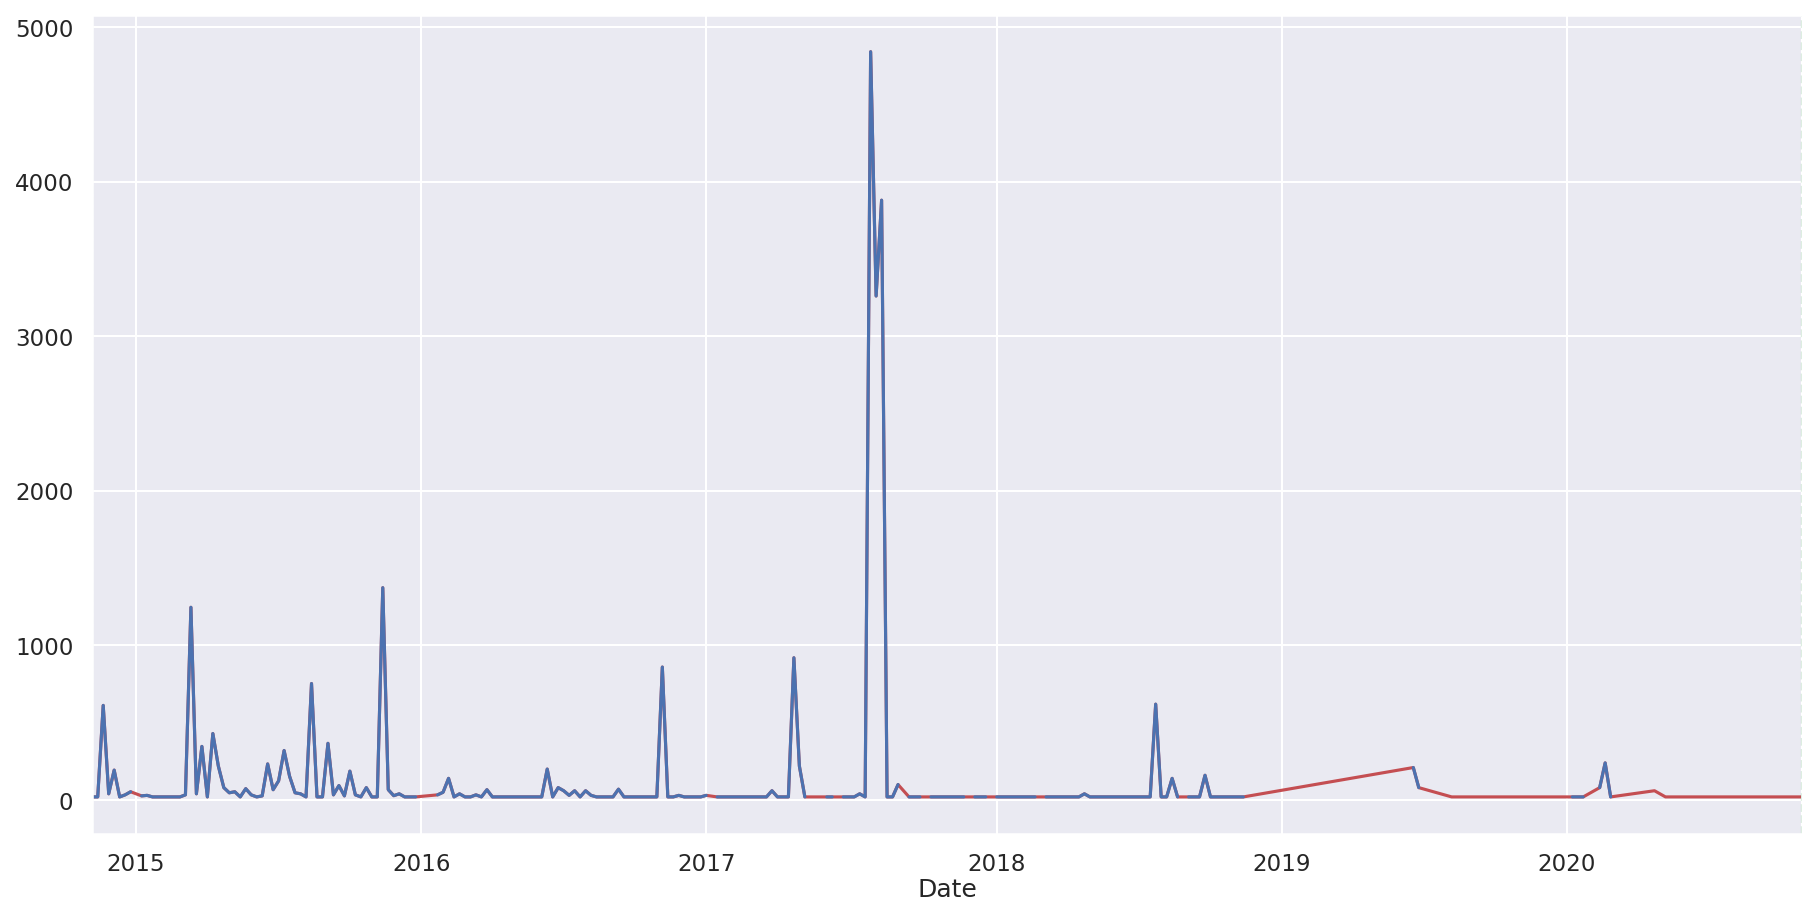

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,20.0,5276.0,20.0
2014-11-16,20.0,20.0,20.0
2014-11-23,20.0,20.0,60.0
2014-11-30,60.0,20.0,40.0
2014-12-07,20.0,20.0,80.0
...,...,...,...
2020-12-06,200.0,1080.0,20.0
2020-12-13,20.0,20.0,20.0
2020-12-20,20.0,20.0,20.0


Fractions to remove:  {'psp_phyto': 0.07}


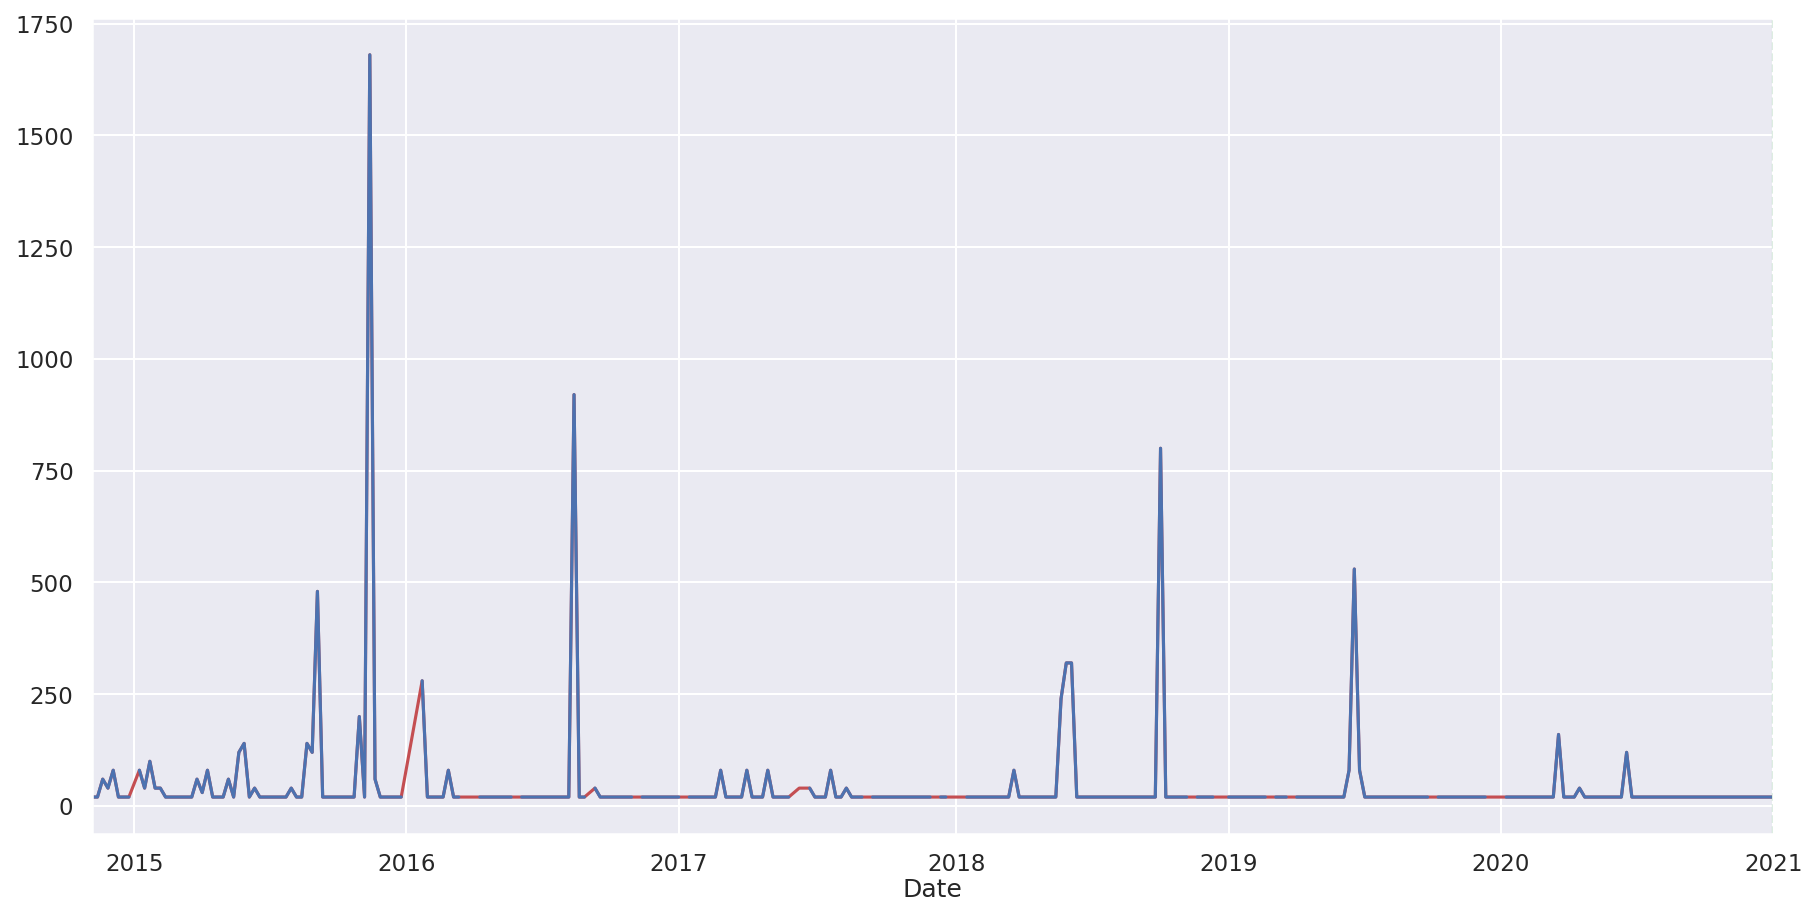

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,20.0,20.0,20.0
2014-11-16,20.0,20.0,40.0
2014-11-23,20.0,20.0,40.0
2014-11-30,20.0,20.0,20.0
2014-12-07,20.0,20.0,20.0
...,...,...,...
2020-12-06,NaN,NaN,NaN
2020-12-13,20.0,160.0,20.0
2020-12-20,20.0,260.0,20.0


Fractions to remove:  {'psp_phyto': 0.1}


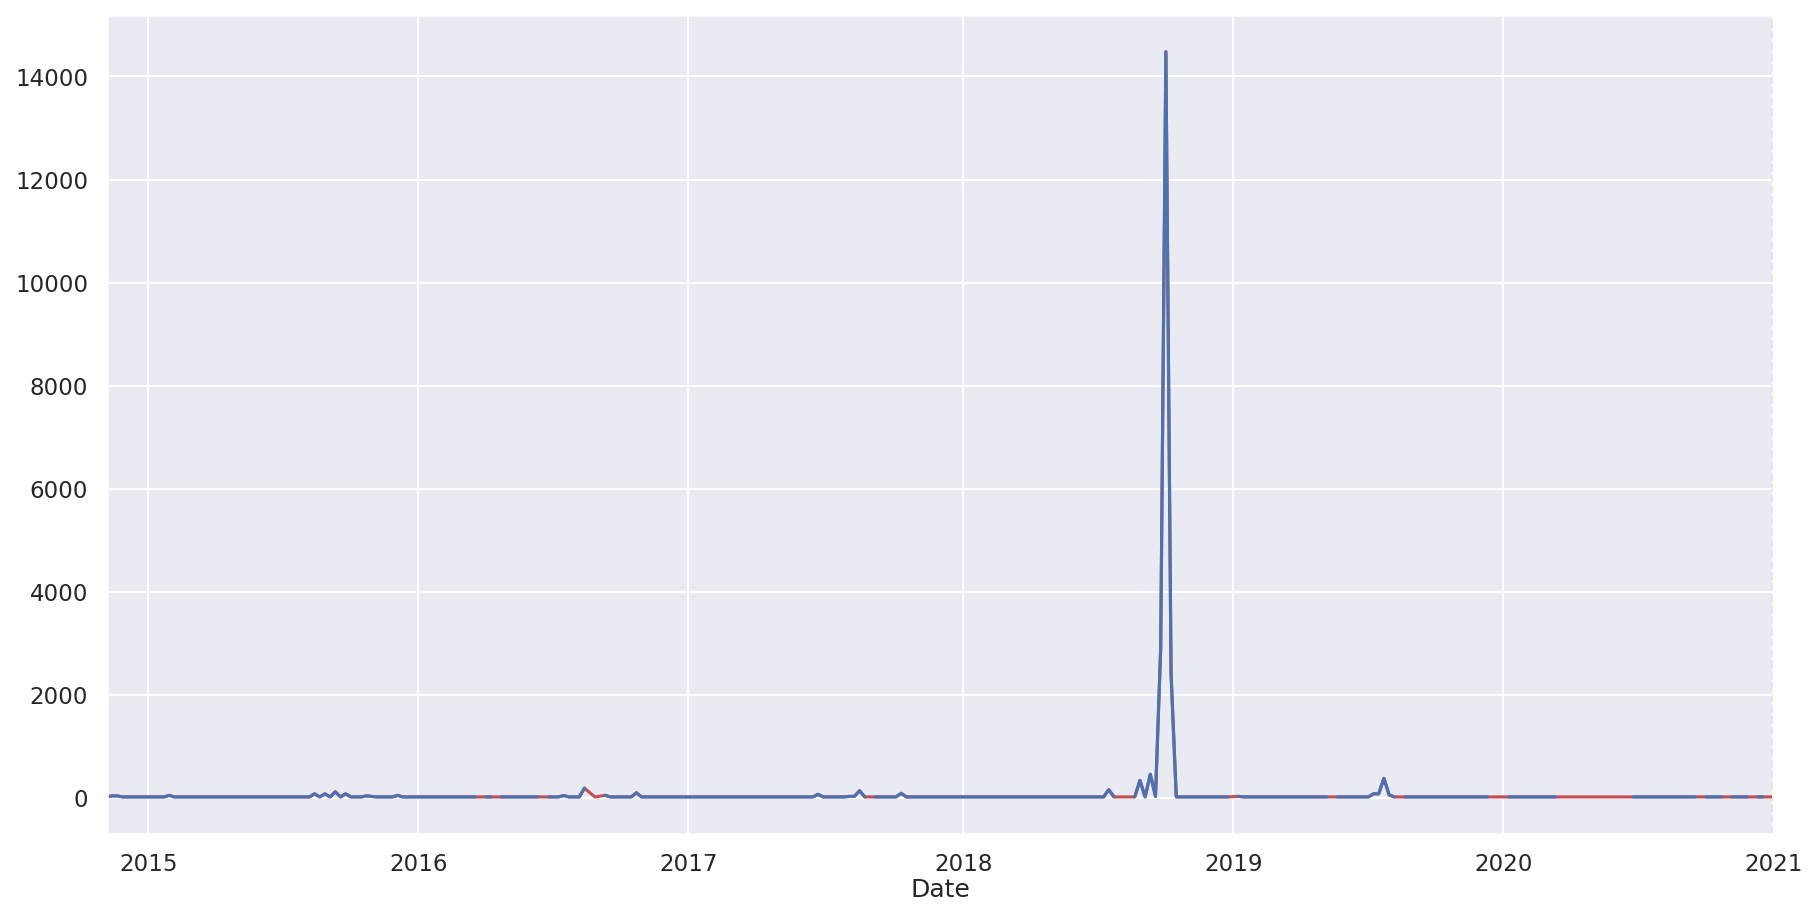

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,40.0,62524.0,200.0
2014-11-16,20.0,1705.0,40.0
2014-11-23,160.0,9094.0,40.0
2014-11-30,40.0,3978.0,240.0
2014-12-07,20.0,20.0,20.0
...,...,...,...
2020-12-06,NaN,NaN,NaN
2020-12-13,20.0,20.0,20.0
2020-12-20,20.0,840.0,20.0


Fractions to remove:  {'psp_phyto': 0.05}


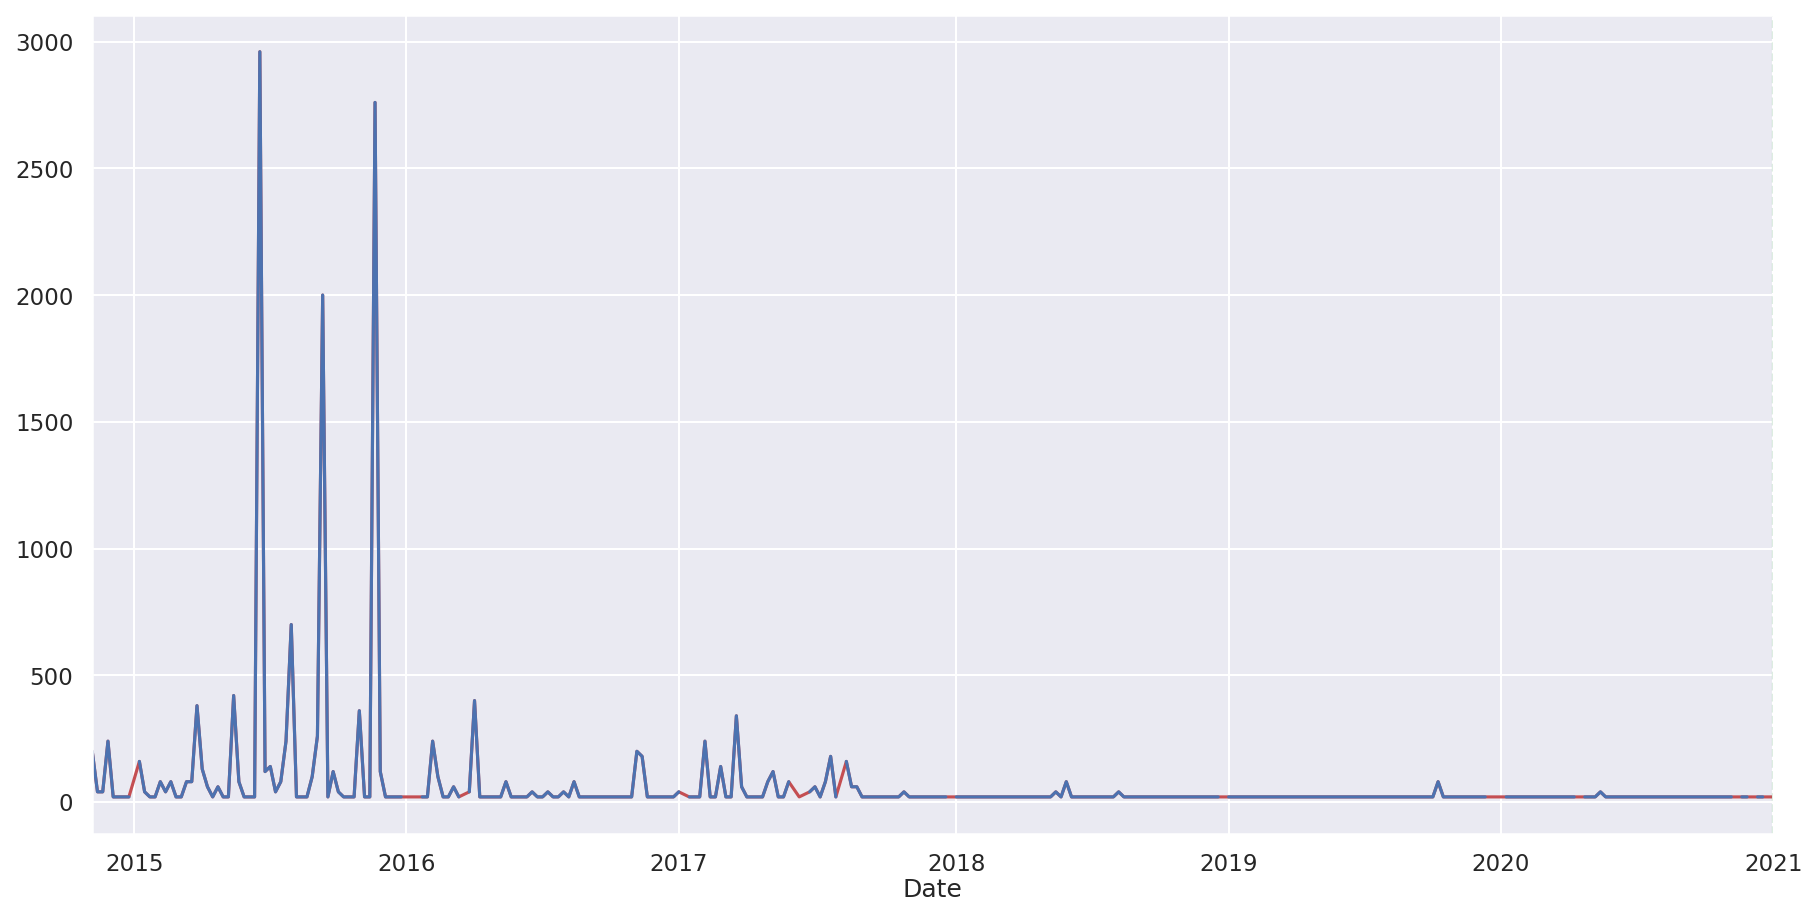

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,320.0,34672.0,360.0
2014-11-16,20.0,5936.0,20.0
2014-11-23,20.0,3409.0,540.0
2014-11-30,100.0,20.0,100.0
2014-12-07,20.0,20.0,240.0
...,...,...,...
2020-12-06,240.0,1960.0,20.0
2020-12-13,20.0,20.0,20.0
2020-12-20,40.0,20.0,20.0


Fractions to remove:  {'psp_phyto': 0.06}


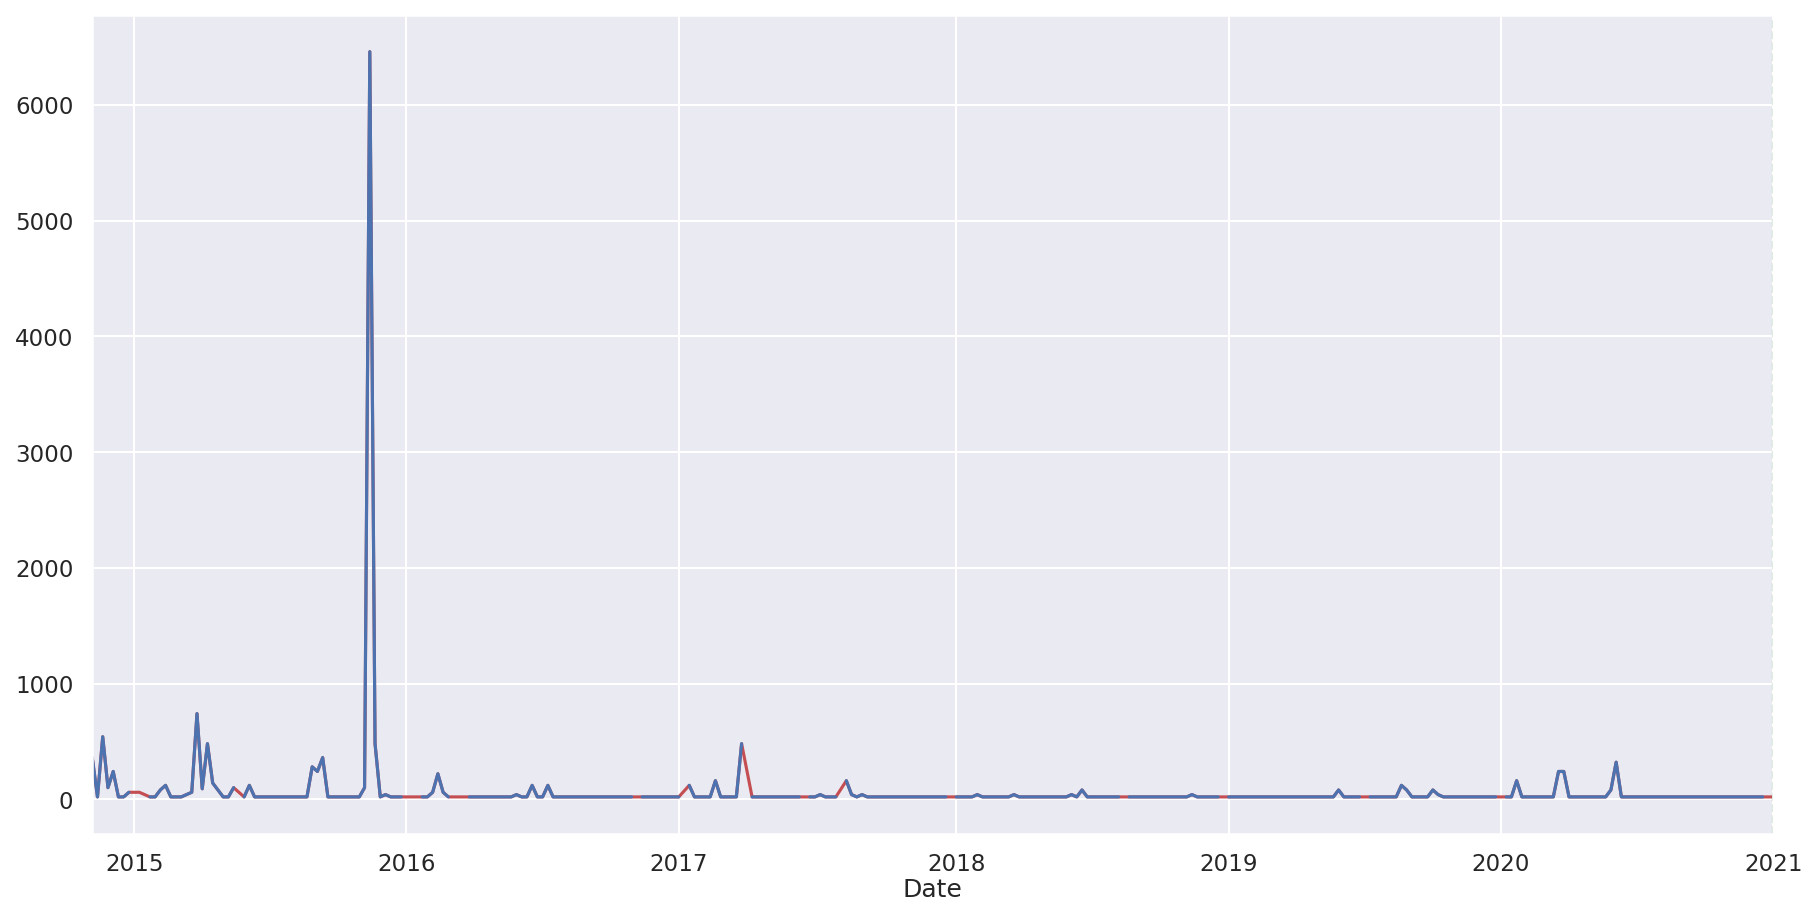

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,80.0,52292.0,20.0
2014-11-16,20.0,20.0,20.0
2014-11-23,20.0,6820.0,300.0
2014-11-30,60.0,3978.0,200.0
2014-12-07,240.0,1705.0,60.0
...,...,...,...
2020-12-06,40.0,320.0,20.0
2020-12-13,20.0,20.0,20.0
2020-12-20,20.0,1320.0,20.0


Fractions to remove:  {'psp_phyto': 0.05}


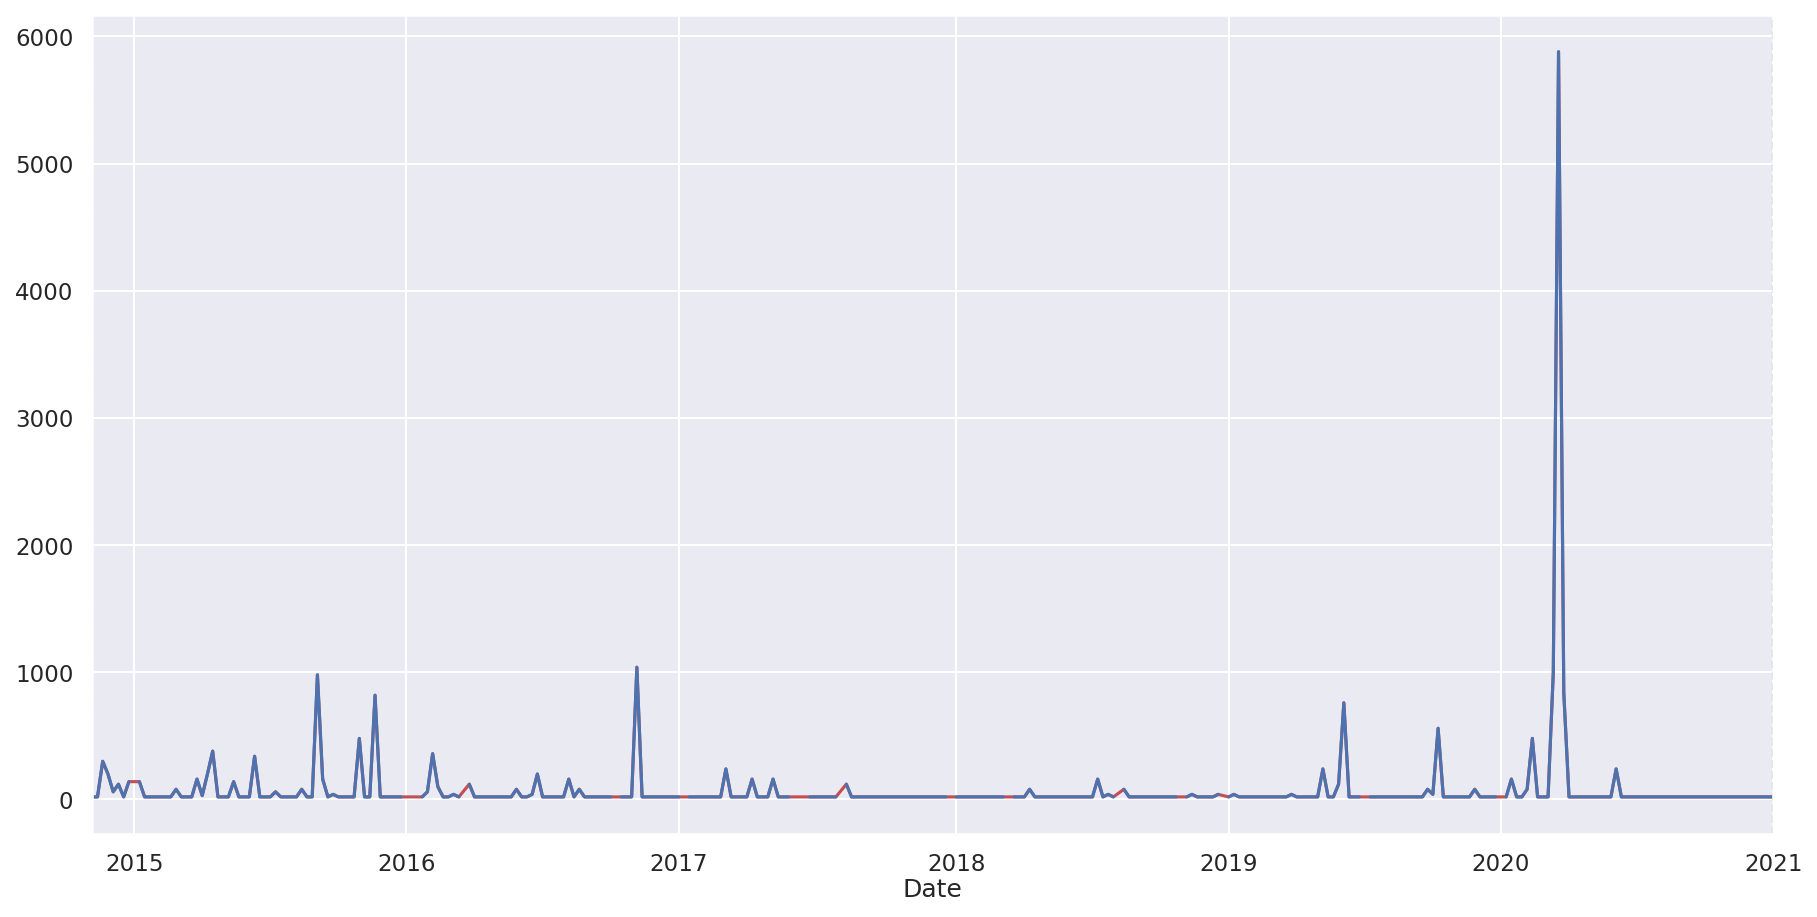

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,20.0,20.0,20.0
2014-11-16,20.0,20.0,20.0
2014-11-23,20.0,20.0,20.0
2014-11-30,20.0,20.0,20.0
2014-12-07,20.0,20.0,20.0
...,...,...,...
2020-11-29,520.0,1300.0,20.0
2020-12-06,80.0,20.0,20.0
2020-12-13,60.0,440.0,20.0


Fractions to remove:  {'psp_phyto': 0.04}


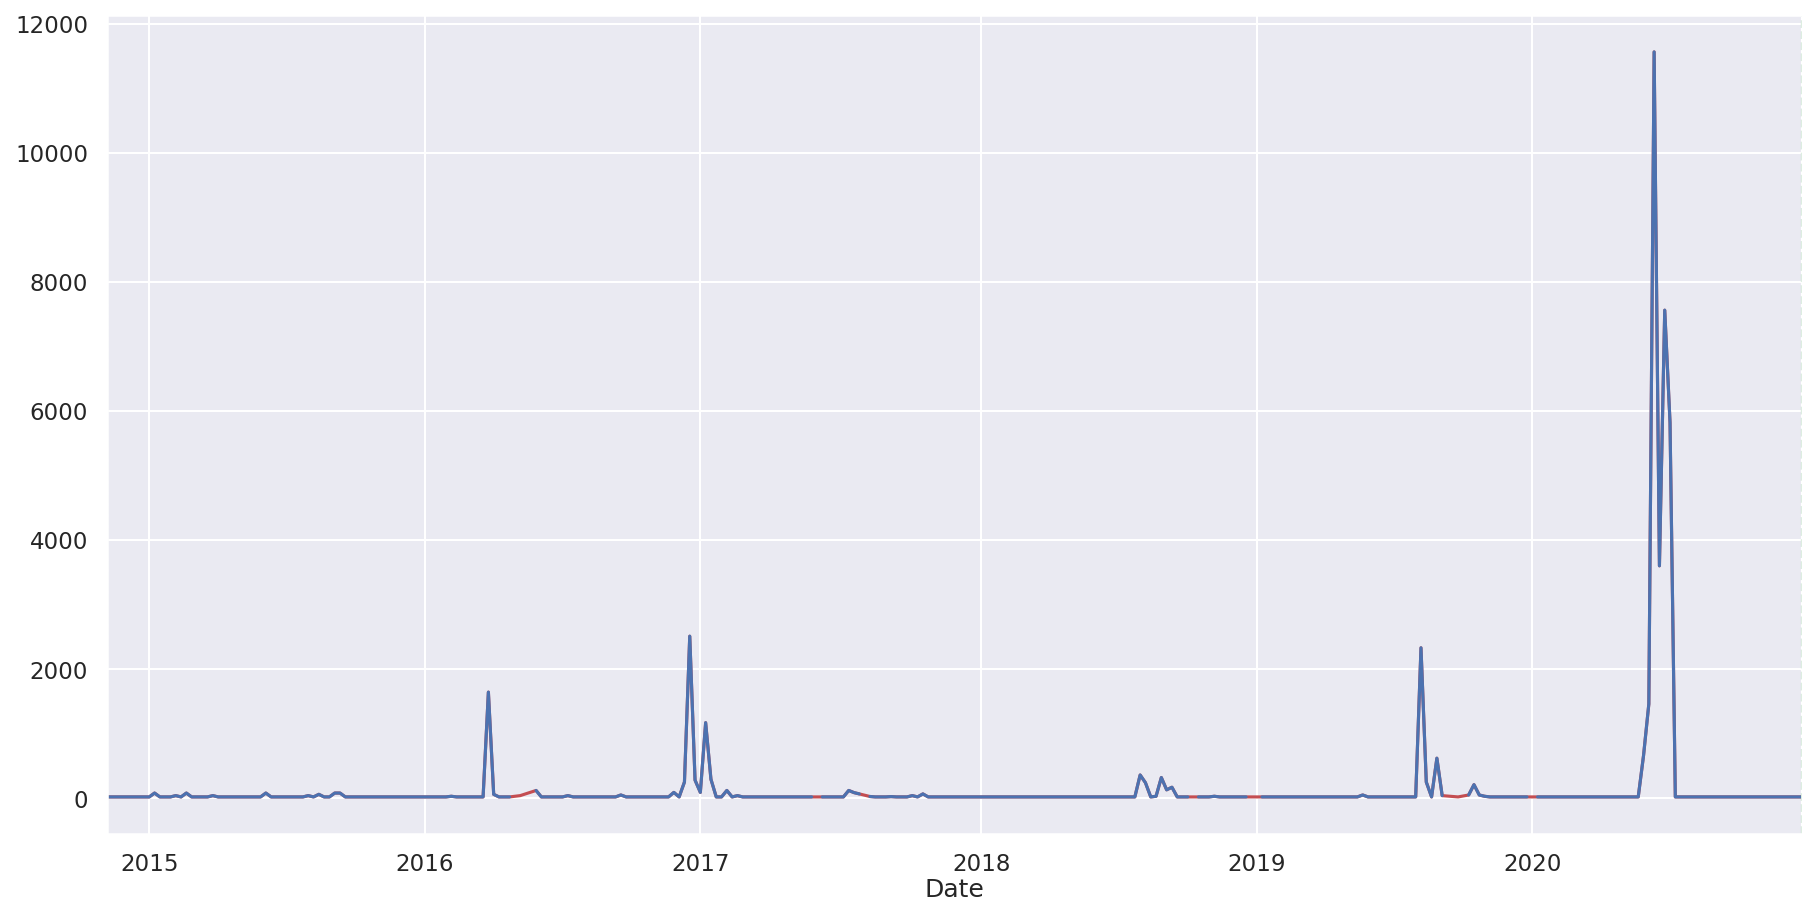

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,20.0,2523.0,20.000000
2014-11-16,20.0,392.0,20.000000
2014-11-23,20.0,20.0,26.666667
2014-11-30,20.0,20.0,33.333333
2014-12-07,20.0,20.0,20.000000
...,...,...,...
2018-08-12,20.0,20.0,20.000000
2018-08-19,NaN,NaN,NaN
2018-08-26,60.0,20.0,20.000000


Fractions to remove:  {'psp_phyto': 0.16}


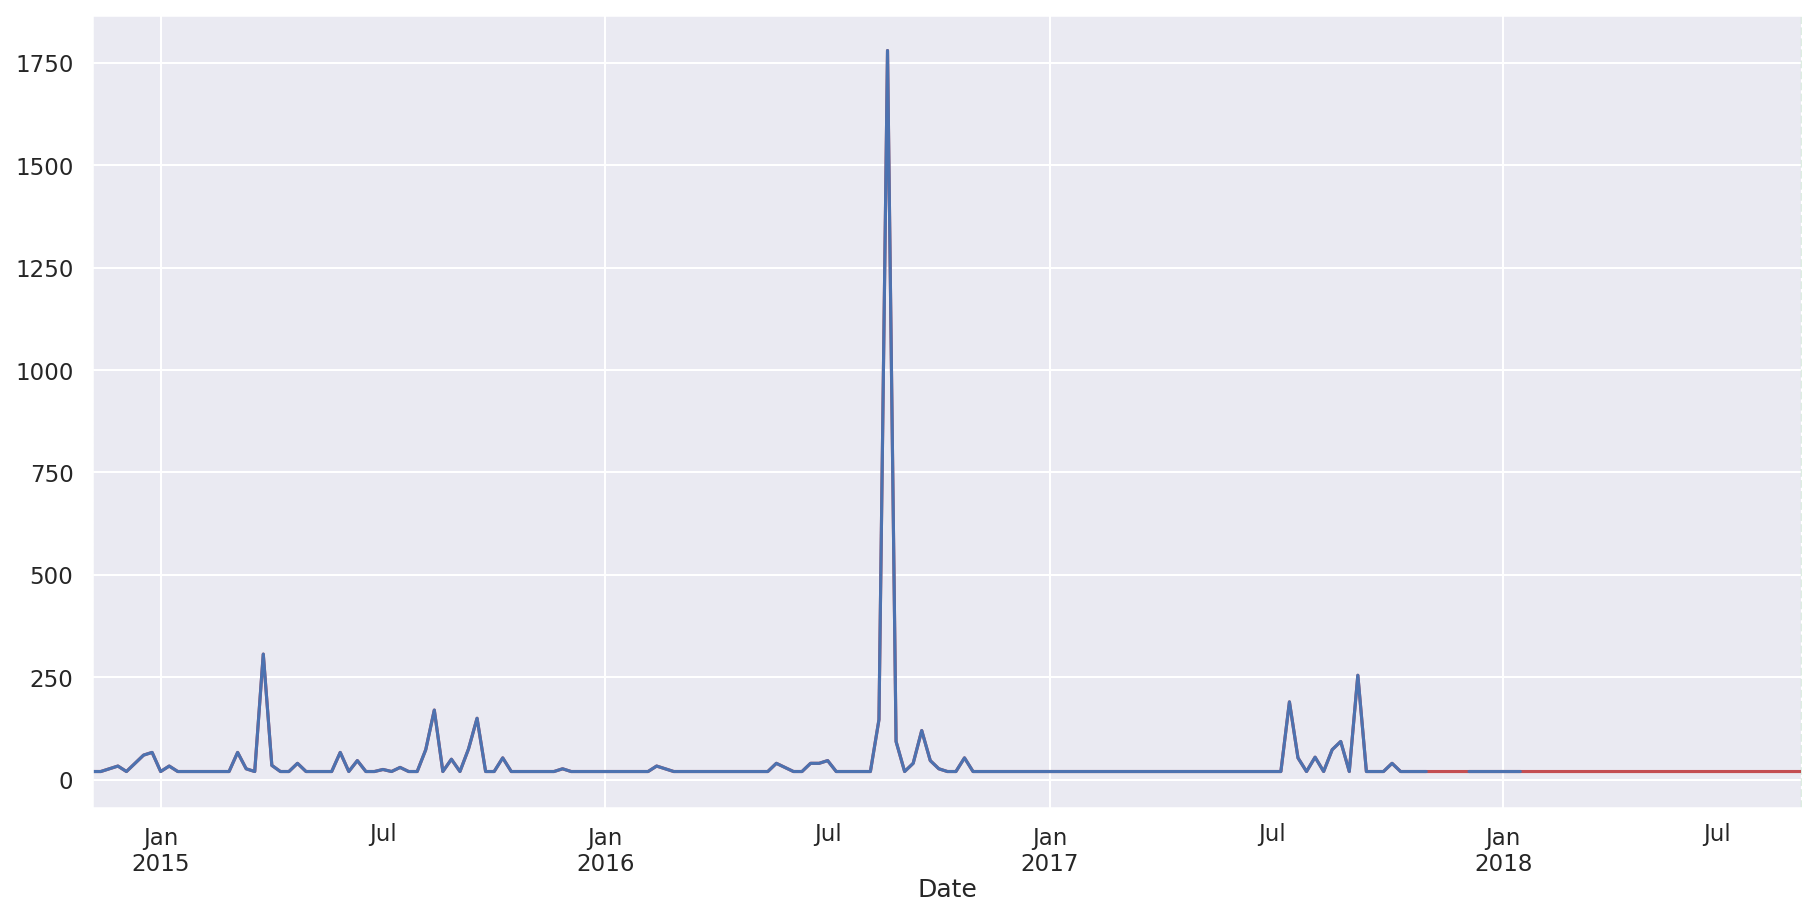

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,20.0,20.0,20.0
2014-11-16,20.0,20.0,80.0
2014-11-23,20.0,20.0,20.0
2014-11-30,240.0,20.0,20.0
2014-12-07,20.0,20.0,20.0
...,...,...,...
2020-12-06,1840.0,2920.0,20.0
2020-12-13,NaN,NaN,NaN
2020-12-20,80.0,200.0,20.0


Fractions to remove:  {'psp_phyto': 0.05}


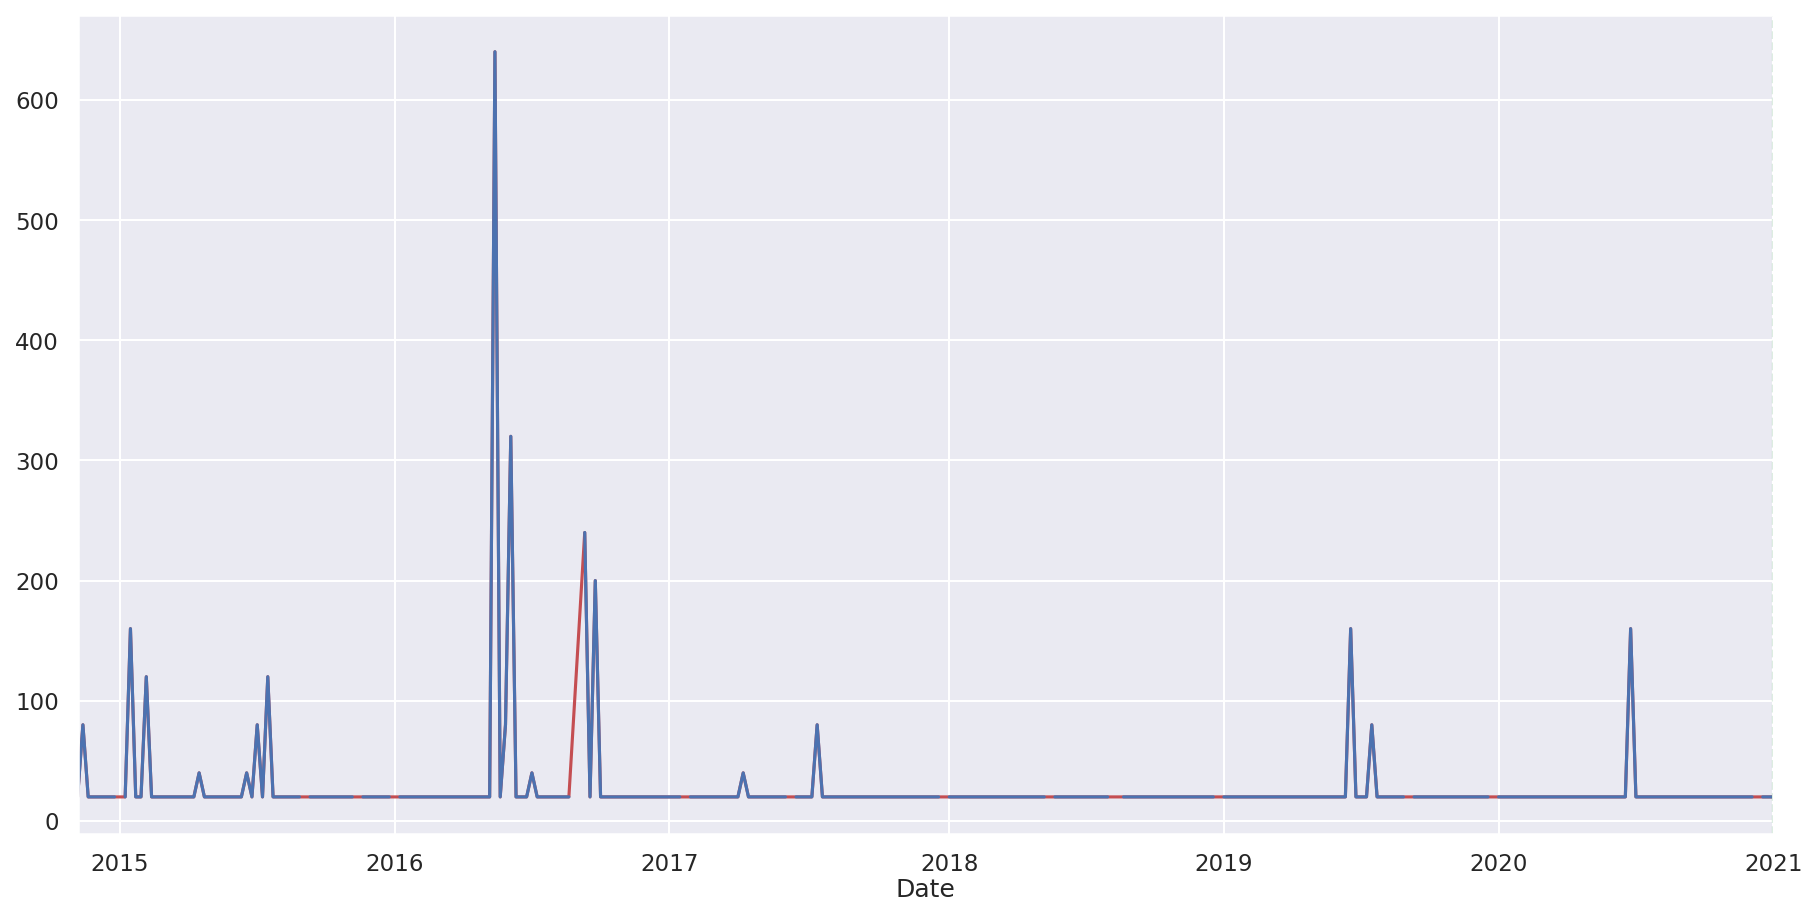

,dsp_phyto,asp_phyto,psp_phyto
Date,,,
2014-11-09,30.0,20.0,20.0
2014-11-16,20.0,2650.0,20.0
2014-11-23,20.0,20.0,20.0
2014-11-30,20.0,20.0,20.0
2014-12-07,20.0,999.0,20.0
...,...,...,...
2020-12-06,20.0,20.0,20.0
2020-12-13,NaN,NaN,NaN
2020-12-20,20.0,120.0,20.0


Fractions to remove:  {'psp_phyto': 0.04}


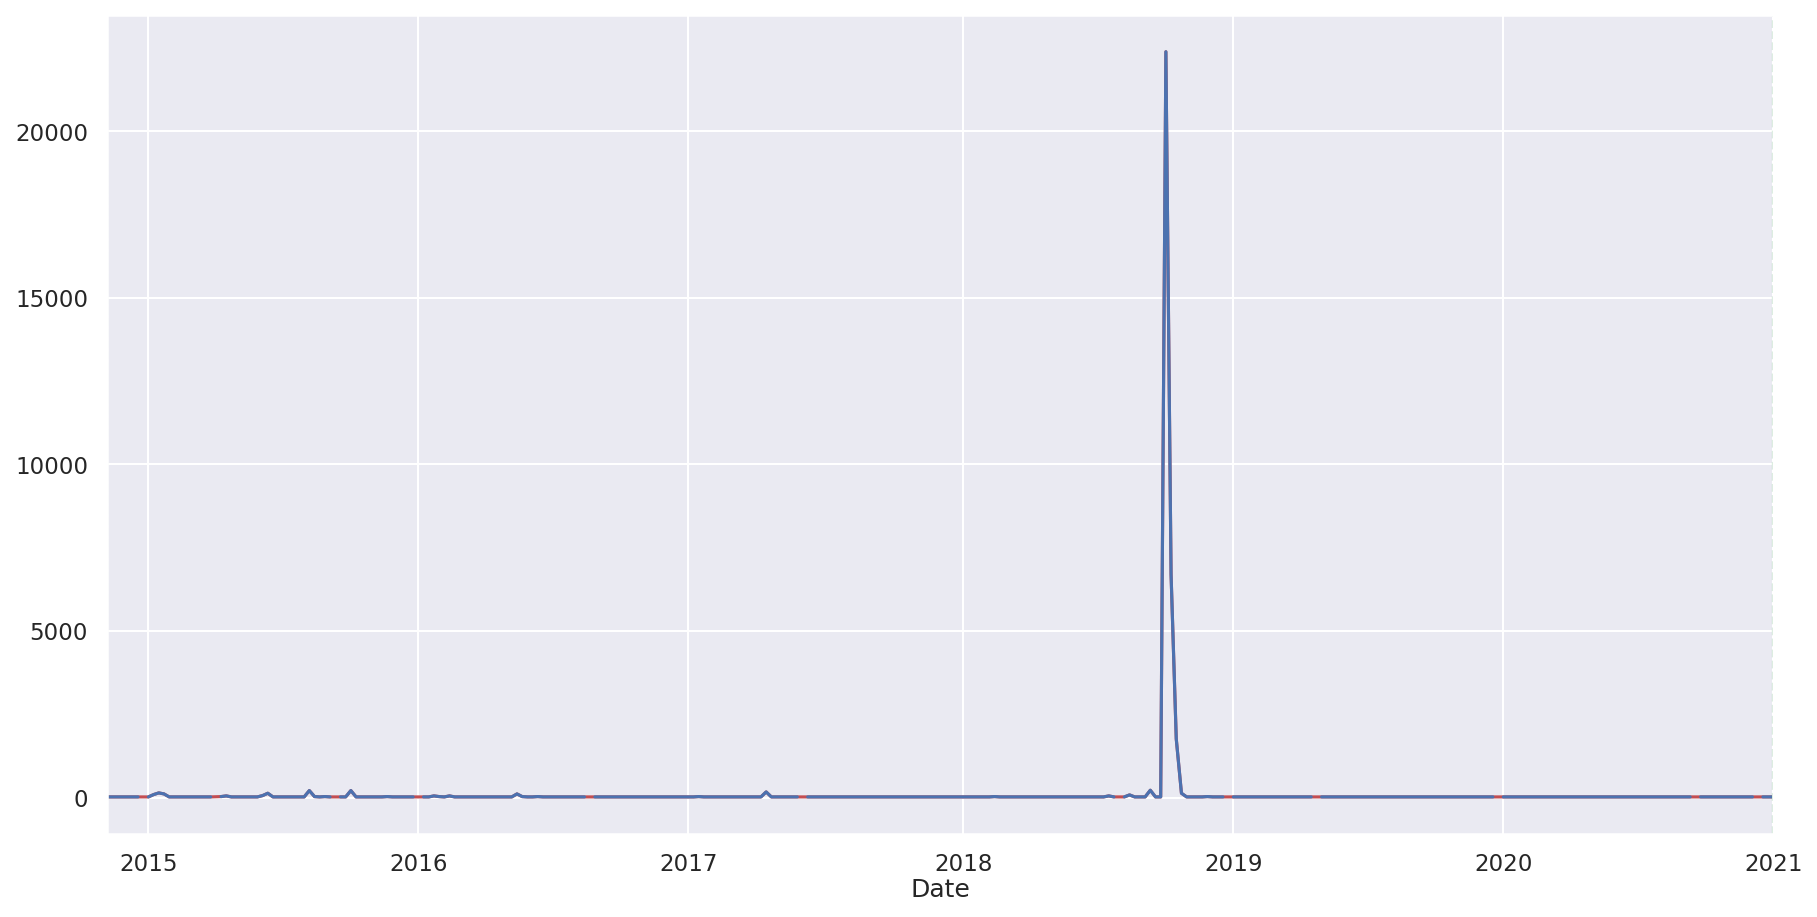

19

In [11]:
n_segments = -1
n_mult_per_segment = 5

columns_to_get = ["dsp_phyto", "asp_phyto", "psp_phyto"]
targets_imputation= ["psp_phyto"]


dfs_per_area = {}
ts_to_impute = {}

#for area in list(to_impute.keys())[1:2]:
for area in areas_to_impute:
    ts_list = []

    ts_week = get_ts(phyto_ts, area, None, columns_to_get, "W", plot=False)
    display(ts_week)
    ts_to_impute[area] = ts_week
    dfs_complete, dfs_missing = get_segments_for_imputation(ts_week.copy(), targets_imputation, n_segments, n_mult_per_segment)
    dfs_per_area[area] = {"complete": dfs_complete, "missing": dfs_missing}

len(dfs_per_area)

In [43]:
from functions.automts.bayesian import hyperparameter_tuning_bayesian

#Random Forest, Mice e Amelia precisam que seja multivariado
#Amelia nao funciona quando todas/+1 variaveis sao NaN
#Amelia pode ser cross-sectional ou time series
#RF, EM, KNN e MICE são cross-sectional, logo, não tem em conta dependencia temporal
#Algoritmos cross-sectional podem ser uteis para tirar partido de conhecermos toxicidade de outros bivalves

imp_data_dir = "./imputed_data/"
    
imputationMethods = ['Mean', 'Median', 'Random sample', 'Interpolation', 'Locf', 'Nocb', 
                     'Moving average', 'Random forests', 
                     'Expectation maximization', 'Knn', 'Mice']

imputationMethods = ['Mean', 'Median', 'Random sample', 'Interpolation', 'Locf', 'Nocb', 
                     'Moving average', 'Expectation maximization', 'Knn']

run_imputation = True
suf = ''
if run_imputation:
    for area in dfs_per_area:
        print("#"*20)
        print("#",' '*5, area)
        print("#"*20)
        #print("Before:\n\n")
        #display(dfs_per_area[area]["complete"])
        #display(dfs_per_area[area]["missing"])
        #print("\n\n")
        sensor_dict = hyperparameter_tuning_bayesian(dfs_per_area[area]["complete"], 
                                                     dfs_per_area[area]["missing"], 
                                                     imputationMethods, targets_imputation, max_evals=100)
        print(sensor_dict)
        ts_imputed = impute_missing_values(ts_to_impute[area], sensor_dict, "none", rs)
        targets_key = [t.replace("phyto", "toxins") for t in targets_imputation]
        key = f'phytocorr__{area}__{"_".join(targets_key)}{suf}'
        print(key)
        ts_imputed.to_csv(f"{imp_data_dir}{key}.csv")


####################
#       L6
####################
-------SENSOR------ psp_phyto
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|██████| 100/100 [00:00<00:00, 367.54trial/s, best loss: 41.858654462428895]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|██████| 100/100 [00:00<00:00, 152.36trial/s, best loss: 37.173139414190054]
METHOD Expectation maximization
100%|███████| 100/100 [00:01<00:00, 65.11trial/s, best loss: 54.322154507178034]
METHOD Knn
100%|████████| 100/100 [00:01<00:00, 69.71trial/s, best loss: 37.57487149335225]
{'psp_phyto': ['Mean', []]}
phytocorr__L6__psp_toxins
####################
#       LAL
####################
-------SENSOR------ psp_phyto
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|███████| 100/100 [00:00<00:00, 332.19trial/s, best loss: 961.4281397596715]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|████████| 100/100 [00:00<00:00, 143.14trial/s, best loss: 944.432829928801]
METHOD Expectation max

100%|███████| 100/100 [00:00<00:00, 325.72trial/s, best loss: 24.08337948842365]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|██████| 100/100 [00:00<00:00, 159.76trial/s, best loss: 43.995483204216875]
METHOD Expectation maximization
100%|████████| 100/100 [00:01<00:00, 53.11trial/s, best loss: 74.07347407080822]
METHOD Knn
100%|████████| 100/100 [00:01<00:00, 80.24trial/s, best loss: 24.98701197595905]
{'psp_phyto': ['Median', []]}
phytocorr__FUZ__psp_toxins
####################
#       TAV
####################
-------SENSOR------ psp_phyto
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|███████| 100/100 [00:00<00:00, 385.31trial/s, best loss: 60.66612622109601]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|██████| 100/100 [00:00<00:00, 133.75trial/s, best loss: 34.631618916002935]
METHOD Expectation maximization
100%|████████| 100/100 [00:01<00:00, 61.22trial/s, best loss: 68.86305646270173]
METHOD Knn
100%|████████| 100/100 [00:01<00:00, 83.34tria

/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:221: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:279: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  warnings.warn(


100%|███████| 100/100 [00:00<00:00, 203.22trial/s, best loss: 5.270462766947299]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|███████| 100/100 [00:01<00:00, 97.55trial/s, best loss: 3.0188168848835977]
METHOD Expectation maximization
100%|█████████| 100/100 [00:01<00:00, 52.61trial/s, best loss: 7.97198284093174]
METHOD Knn
100%|████████| 100/100 [00:01<00:00, 76.79trial/s, best loss: 2.241869943771231]
{'psp_phyto': ['Median', []]}
phytocorr__LOB__psp_toxins
####################
#       ESD1
####################
-------SENSOR------ psp_phyto
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|██████| 100/100 [00:00<00:00, 358.95trial/s, best loss: 3.2254032006016877]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|██████| 100/100 [00:00<00:00, 135.54trial/s, best loss: 3.9310819144252322]
METHOD Expectation maximization
100%|███████| 100/100 [00:01<00:00, 64.86trial/s, best loss: 216.69526502607437]
METHOD Knn
100%|████████| 100/100 [00:01<00:00, 75.62tri

## IPMA

Get dataframes

In [6]:
dataframes = {}
for file in glob.glob(f"{data_dir}/areas_data/*"):
    print(file)
    area = file.split('/')[-1].strip(".xlsx").split('_')[1]
    ts = pd.read_excel(file, index_col='Date', parse_dates=True, engine="openpyxl").resample("W").mean()
    dataframes[area] = ts
print(dataframes[area].columns.tolist())

./../data//areas_data/data_POR2_Mexilh╞o_dsp.xlsx
./../data//areas_data/data_RIAV4_Mexilh╞o_dsp.xlsx
./../data//areas_data/data_RIAV1_Mexilh╞o_dsp.xlsx
./../data//areas_data/data_FAR1_Mexilh╞o_dsp.xlsx
./../data//areas_data/data_ETJ1_Mexilh╞o_dsp.xlsx
./../data//areas_data/data_L7c1_Mexilh╞o_dsp.xlsx
./../data//areas_data/data_LAL_Mexilh╞o_dsp.xlsx
./../data//areas_data/data_L5b_Mexilh╞o_dsp.xlsx
./../data//areas_data/data_LAG_Mexilh╞o_dsp.xlsx
['dsp_toxins', 'dsp_phyto', 'mean_sst', 'mean_chl', 'mean_temp', 'max_temp', 'min_temp', 'mean_wind_intensity', 'mean_wind_dir', 'wind_dir', 'rainfall']


Select which columns to keep and impute -> columns with at least 50% not NaN
Remove other columns and store it again in dataframes

In [7]:
min_percentage = 0.5
for area in dataframes:
    df = dataframes[area]
    total_points = df.shape[0]
    nans = df.isna().sum()
    selected = nans[nans<=(total_points*min_percentage)].index.tolist()
    dataframes[area] = dataframes[area][selected]
dataframes[area]

,dsp_toxins,dsp_phyto,mean_sst,mean_chl,mean_temp,max_temp,min_temp,mean_wind_intensity,wind_dir,rainfall
Date,,,,,,,,,,
2015-01-11,15.0,20.0,289.366669,1.153789,6.342857,18.257143,-1.728571,0.528571,0.000000,0.042857
2015-01-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-25,18.0,20.0,288.161407,0.985061,9.900000,15.814286,4.571429,1.342857,5.714286,2.142857
2015-02-01,17.0,20.0,287.813812,1.208999,9.885714,15.942857,4.057143,1.042857,5.285714,1.085714
2015-02-08,29.0,20.0,287.030457,1.504713,8.000000,14.142857,1.357143,1.200000,5.428571,0.828571
...,...,...,...,...,...,...,...,...,...,...
2020-12-06,36.0,NaN,291.387146,1.797064,11.928571,18.200000,5.114286,NaN,NaN,6.600000
2020-12-13,36.0,20.0,290.150482,0.564031,15.671429,18.371429,12.728571,NaN,NaN,3.666667
2020-12-20,36.0,20.0,289.430939,3.283147,11.800000,18.142857,5.828571,NaN,NaN,4.042857


For each area do the following:

    For each column do the following:
    
        1. Get copies of dataframe with artificial NaNs for target  column
        2. Run Baeysian hyperparameterization to find best imputation for target column

In [63]:
n_segments = -1
n_mult_per_segment = 5

imp_data_dir = "./imputed_data/"

imputationMethods = ['Mean', 'Median', 'Random sample', 'Interpolation', 'Locf', 'Nocb', 
                     'Moving average', 'Expectation maximization', 'Knn']

run_imputation = True

if not run_imputation:
    a = 1/0

#area iteration
for area in dataframes:
    print("\n\n")
    print("#"*20)
    print("#"*5, area, "#"*5)
    print("#"*20)

    imp_methods = {}
    ts = dataframes[area]
    columns_to_get = ts.columns
    #column iteration
    for col in ts.columns:
        #print("##",col)
        targets_imputation= [col]

        dfs_per_col = {}
        
        #1
        dfs_complete, dfs_missing = get_segments_for_imputation(ts.copy(), targets_imputation, n_segments, 
                                                                n_mult_per_segment, verbose=0)
        dfs_per_col[col] = {"complete": dfs_complete, "missing": dfs_missing}
        
        
        sensor_dict = hyperparameter_tuning_bayesian(dfs_per_col[col]["complete"], 
                                                     dfs_per_col[col]["missing"], 
                                                     imputationMethods, targets_imputation, max_evals=100)
        #merge dicts
        imp_methods = imp_methods | sensor_dict
        
    #print(imp_methods)
    ts_imputed = impute_missing_values(ts, imp_methods, "none", rs)
    #targets_key = [t.replace("phyto", "toxins") for t in targets_imputation]
    key = f'ipmacorr__{area}'
    ts_imputed.to_csv(f"{imp_data_dir}{key}.csv")
    
    




####################
##### POR2 #####
####################
-------SENSOR------ dsp_toxins
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|███████| 100/100 [00:00<00:00, 349.52trial/s, best loss: 37.99706215359483]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|███████| 100/100 [00:00<00:00, 115.47trial/s, best loss: 42.03947820496284]
METHOD Expectation maximization
100%|████████| 100/100 [00:12<00:00,  7.99trial/s, best loss: 60.59320325992001]
METHOD Knn
100%|█████████| 100/100 [00:02<00:00, 47.64trial/s, best loss: 45.1272672881981]
-------SENSOR------ dsp_phyto
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|████████| 100/100 [00:00<00:00, 358.32trial/s, best loss: 3466.33736709665]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|██████| 100/100 [00:00<00:00, 113.20trial/s, best loss: 3380.8026494293144]
METHOD Expectation maximization
100%|███████| 100/100 [00:14<00:00,  7.14trial/s, best loss: 4019.4803529667365]
METHOD 

/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:221: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:279: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  warnings.warn(


100%|███████| 100/100 [00:00<00:00, 363.76trial/s, best loss: 78.10640256426808]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|████████| 100/100 [00:01<00:00, 95.87trial/s, best loss: 80.40766901522561]
METHOD Expectation maximization
100%|████████| 100/100 [00:20<00:00,  4.88trial/s, best loss: 113.8669739729567]
METHOD Knn
100%|████████| 100/100 [00:01<00:00, 52.67trial/s, best loss: 88.37687393810808]
-------SENSOR------ dsp_phyto
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|██████| 100/100 [00:00<00:00, 330.44trial/s, best loss: 470.85331589094943]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|███████| 100/100 [00:01<00:00, 89.71trial/s, best loss: 470.50986381206127]
METHOD Expectation maximization
100%|█████████| 100/100 [00:20<00:00,  4.85trial/s, best loss: 548.084049428536]
METHOD Knn
100%|███████| 100/100 [00:01<00:00, 56.04trial/s, best loss: 411.33091572348036]
-------SENSOR------ mean_sst
METHOD Mean
METHOD Median
METHOD Random sample


100%|██████| 100/100 [00:00<00:00, 339.92trial/s, best loss: 43.966384655934874]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|███████| 100/100 [00:01<00:00, 59.26trial/s, best loss: 38.657706993724986]
METHOD Expectation maximization
100%|████████| 100/100 [00:12<00:00,  8.22trial/s, best loss: 67.63325095178614]
METHOD Knn
100%|████████| 100/100 [00:02<00:00, 43.53trial/s, best loss: 46.26272802729072]
-------SENSOR------ wind_dir
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|██████| 100/100 [00:00<00:00, 384.11trial/s, best loss: 0.8086442847564199]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|███████| 100/100 [00:01<00:00, 60.96trial/s, best loss: 0.7535619439645412]
METHOD Expectation maximization
100%|███████| 100/100 [00:11<00:00,  8.39trial/s, best loss: 1.2341285993371998]
METHOD Knn
100%|███████| 100/100 [00:02<00:00, 48.71trial/s, best loss: 0.8354451588874661]
-------SENSOR------ rainfall
METHOD Mean
METHOD Median
METHOD Random sample
M

/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:221: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:279: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/utils.py:124: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)


100%|███████| 100/100 [00:00<00:00, 373.18trial/s, best loss: 16.14283972472747]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|██████| 100/100 [00:00<00:00, 127.72trial/s, best loss: 15.871209414032371]
METHOD Expectation maximization
100%|███████| 100/100 [00:15<00:00,  6.60trial/s, best loss: 29.022276683241483]
METHOD Knn
100%|███████| 100/100 [00:01<00:00, 54.96trial/s, best loss: 20.146304344498787]
-------SENSOR------ dsp_phyto
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|██████| 100/100 [00:00<00:00, 383.87trial/s, best loss: 450.02568179459644]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|██████| 100/100 [00:00<00:00, 126.90trial/s, best loss: 398.15122701394415]
METHOD Expectation maximization
100%|███████| 100/100 [00:15<00:00,  6.60trial/s, best loss: 450.11910022731973]
METHOD Knn
100%|███████| 100/100 [00:02<00:00, 42.90trial/s, best loss: 335.29136538454617]
-------SENSOR------ mean_sst
METHOD Mean
METHOD Median
METHOD Random sample


/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:221: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:279: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:221: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:279: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpu

100%|██████| 100/100 [00:00<00:00, 383.97trial/s, best loss: 30.536030696655235]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|██████| 100/100 [00:00<00:00, 148.49trial/s, best loss: 33.828285412349736]
METHOD Expectation maximization
100%|████████| 100/100 [00:08<00:00, 11.59trial/s, best loss: 64.87935419153231]
METHOD Knn
100%|████████| 100/100 [00:01<00:00, 52.00trial/s, best loss: 51.60538845266833]
-------SENSOR------ dsp_phyto
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|███████| 100/100 [00:00<00:00, 391.03trial/s, best loss: 4964.246480501549]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|███████| 100/100 [00:00<00:00, 123.59trial/s, best loss: 4695.664894710738]
METHOD Expectation maximization
100%|████████| 100/100 [00:08<00:00, 11.28trial/s, best loss: 5661.668844892092]
METHOD Knn
100%|███████| 100/100 [00:01<00:00, 53.99trial/s, best loss: 4682.8807373239815]
-------SENSOR------ mean_sst
METHOD Mean
METHOD Median
METHOD Random sample


/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:221: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:279: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/utils.py:124: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:221: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:279: UserWarning: There are

100%|██████| 100/100 [00:00<00:00, 377.91trial/s, best loss: 17.458012823343953]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|███████| 100/100 [00:00<00:00, 131.06trial/s, best loss: 18.06858360811773]
METHOD Expectation maximization
100%|███████| 100/100 [00:13<00:00,  7.19trial/s, best loss: 27.686149896501252]
METHOD Knn
100%|███████| 100/100 [00:02<00:00, 44.39trial/s, best loss: 21.242910359832404]
-------SENSOR------ dsp_phyto
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|███████| 100/100 [00:00<00:00, 391.01trial/s, best loss: 504.3595507342773]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|██████| 100/100 [00:00<00:00, 137.07trial/s, best loss: 200.48526441076174]
METHOD Expectation maximization
100%|████████| 100/100 [00:14<00:00,  7.13trial/s, best loss: 5760.032946817784]
METHOD Knn
100%|████████| 100/100 [00:02<00:00, 44.49trial/s, best loss: 119.6324281880247]
-------SENSOR------ mean_sst
METHOD Mean
METHOD Median
METHOD Random sample


100%|███████| 100/100 [00:00<00:00, 384.09trial/s, best loss: 0.928503345970832]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|██████| 100/100 [00:00<00:00, 118.86trial/s, best loss: 0.8812106118106598]
METHOD Expectation maximization
100%|███████| 100/100 [00:10<00:00,  9.73trial/s, best loss: 1.9367436654438916]
METHOD Knn
100%|███████| 100/100 [00:02<00:00, 47.72trial/s, best loss: 1.0104639257529129]
-------SENSOR------ mean_wind_intensity
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|█████| 100/100 [00:00<00:00, 350.81trial/s, best loss: 0.22142785849911414]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|█████| 100/100 [00:00<00:00, 117.66trial/s, best loss: 0.21293701278604937]
METHOD Expectation maximization
100%|███████| 100/100 [00:10<00:00,  9.82trial/s, best loss: 0.2907268102694641]
METHOD Knn
100%|██████| 100/100 [00:02<00:00, 46.97trial/s, best loss: 0.21894596558168003]
-------SENSOR------ wind_dir
METHOD Mean
METHOD Median
METHOD Rand

/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:221: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:279: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:221: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:279: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  warnings.warn(


100%|██████| 100/100 [00:00<00:00, 379.31trial/s, best loss: 15.503511143888375]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|██████| 100/100 [00:00<00:00, 131.48trial/s, best loss: 18.118456293025236]
METHOD Expectation maximization
100%|████████| 100/100 [00:13<00:00,  7.19trial/s, best loss: 31.00176474671739]
METHOD Knn
100%|████████| 100/100 [00:01<00:00, 53.62trial/s, best loss: 20.63556033885867]
-------SENSOR------ dsp_phyto
METHOD Mean
METHOD Median
METHOD Random sample
METHOD Interpolation
100%|███████| 100/100 [00:00<00:00, 387.25trial/s, best loss: 471.4621709046276]
METHOD Locf
METHOD Nocb
METHOD Moving average
100%|███████| 100/100 [00:00<00:00, 127.31trial/s, best loss: 429.5805182010803]
METHOD Expectation maximization
100%|███████| 100/100 [00:13<00:00,  7.15trial/s, best loss: 1967.8253663722467]
METHOD Knn
100%|████████| 100/100 [00:02<00:00, 46.44trial/s, best loss: 670.8512565668187]
-------SENSOR------ mean_sst
METHOD Mean
METHOD Median
METHOD Random sample


/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:221: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:279: UserWarning: There are rows with more than 50.0% missing values. The missing features in these rows are imputed with column means.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/utils.py:124: RuntimeWarning: invalid value encountered in sqrt
  return distances if squared else np.sqrt(distances, out=distances)
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:221: UserWarning: There are rows with more than 50.0% missing values. These rows are not included as donor neighbors.
  warnings.warn(
/home/andre/anaconda3/envs/matisse/lib/python3.9/site-packages/missingpy/knnimpute.py:279: UserWarning: There are